In [1]:
from altProts_in_communities.utils import is_alt
import pickle
from matplotlib import pyplot as plt
import networkx as nx
import markov_clustering as mc
import json
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import itertools as itt

In [6]:
G_o = pickle.load(open('G_o.pkl', 'rb'))

In [7]:
import goatools
from goatools import obo_parser
from goatools.go_enrichment import GOEnrichmentStudy
import wget
import os
import gzip

go_obo_url = 'http://purl.obolibrary.org/obo/go/go.obo'
data_folder = os.getcwd() + '/GO_data'

# Check if we have the ./GO_data directory already
if(not os.path.isfile(data_folder)):
    # Emulate mkdir -p (no error if folder exists)
    try:
        os.mkdir(data_folder)
    except OSError as e:
        if(e.errno != 17):
            raise e
else:
    raise Exception('Data path (' + data_folder + ') exists as a file. '
                   'Please rename, remove or change the desired location of the data path.')

# Check if the file exists already
if(not os.path.isfile(data_folder+'/go.obo')):
    go_obo = wget.download(go_obo_url, data_folder+'/go.obo')
else:
    go_obo = data_folder+'/go.obo'

if(not os.path.isfile(data_folder+'/goslim_agr.obo')):
    goslim_agr = wget.download(go_obo_url, data_folder+'/goslim_agr.obo')
else:
    goslim_agr = data_folder+'/goslim_agr.obo'

## Now Gene_Enrichment
import Bio.UniProt.GOA as GOA
### Get the GAF file for your species
import os
from ftplib import FTP
data_folder = '/home/sleblanc/'
human_uri = '/pub/databases/GO/goa/HUMAN/goa_human.gaf.gz'
human_fn = human_uri.split('/')[-1]

# Check if the file exists already
human_gaf = os.path.join(data_folder, human_fn)
if(not os.path.isfile(human_gaf)):
    ebi_ftp = FTP('ftp.ebi.ac.uk')
    ebi_ftp.login()
    with open(human_gaf,'wb') as human_fp:
        ebi_ftp.retrbinary('RETR {}'.format(human_uri), human_fp.write)
    ebi_ftp.quit()

GO_terms = obo_parser.GODag(go_obo)
GO_slim  = obo_parser.GODag(goslim_agr)

with gzip.open(human_gaf, 'rt') as human_gaf_fp:
    human_funcs = {}
    for entry in GOA.gafiterator(human_gaf_fp):
        gene_name = entry.pop('DB_Object_Symbol')
        human_funcs[gene_name] = entry
    pop = human_funcs.keys()

assoc = {}
for x in human_funcs:
    if x not in assoc:
        assoc[x] = set()
    assoc[x].add(str(human_funcs[x]['GO_ID']))

/home/sleblanc/GO_data/go.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
/home/sleblanc/GO_data/goslim_agr.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms


In [8]:
predictions = pickle.load(open('HCIP_pred_BioPlex_OP16.pkl', 'rb'))

In [9]:
all_genes = set([x for y in [[b, p] for batch, b, p, t, y in predictions] for x in y if 'IP_' not in x])

In [10]:
GOEA = GOEnrichmentStudy(all_genes, assoc, GO_terms, propagate_counts=True, alpha=0.05, methods=['fdr'])


Load GOEA Gene Ontology Analysis ...
Propagating term counts up: is_a
 95%  8,120 of  8,536 population items found in association


4 GO IDs NOT FOUND IN ASSOCIATION: GO:0050662 GO:0048037 GO:0051184 GO:0051186


In [14]:
GOEA = GOEnrichmentStudy(pop, assoc, GO_terms, propagate_counts=True, alpha=0.05, methods=['fdr'])


Load GOEA Gene Ontology Analysis ...
Propagating term counts up: is_a


4 GO IDs NOT FOUND IN ASSOCIATION: GO:0050662 GO:0048037 GO:0051184 GO:0051186


100% 19,435 of 19,435 population items found in association


In [7]:
def get_GO(gene_list, title):
    ratios, gterms = [], []
    GOEA_result = GOEA.run_study_nts(gene_list)
    print('\n --------------')
    for g in GOEA_result[:10]:
        ratios.append(np.divide(*g.ratio_in_study))
        gterms.append(g.name)
        #print(ratios, g.name, g.kws['p_uncorrected'])
    n_sig_gterms = 10
    fig, ax = plt.subplots(facecolor='w', figsize=(4,2))
    y_pos = range(1, n_sig_gterms+1)
    ax.set_title(title)
    ax.barh(y_pos, ratios[:n_sig_gterms])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(gterms)
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.set_aspect(0.01)
    ax.set_xlabel('frequency')
    plt.savefig('GO_barcharts/{}_GOenrichment.svg'.format(title))
    plt.show()
    return GOEA_result

In [9]:
G = G_o
matrix_o = nx.to_scipy_sparse_matrix(G)
result_o = mc.run_mcl(matrix_o, inflation=2.0, verbose=True)
clusters = mc.get_clusters(result_o)
node_idx = {n:x for n,x in enumerate(G.nodes())}
cluster_sizes = sorted([(c, len(c)) for c in clusters if len(c)>2], key=lambda x: -x[-1])
len(cluster_sizes)

--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 2.0
Pruning threshold: 0.001, frequency: 1 iteration
Convergence check: 1 iteration
Maximum iterations: 100
Sparse matrix mode
--------------------------------------------------
Iteration 1
Pruning
Checking for convergence
Iteration 2
Pruning
Checking for convergence
Iteration 3
Pruning
Checking for convergence
Iteration 4
Pruning
Checking for convergence
Iteration 5
Pruning
Checking for convergence
Iteration 6
Pruning
Checking for convergence
Iteration 7
Pruning
Checking for convergence
Iteration 8
Pruning
Checking for convergence
Iteration 9
Pruning
Checking for convergence
Iteration 10
Pruning
Checking for convergence
Iteration 11
Pruning
Checking for convergence
Iteration 12
Pruning
Checking for convergence
Iteration 13
Pruning
Checking for convergence
Iteration 14
Pruning
Checking for convergence
Iteration 15
Pruning
Checking for convergence
Iteration 16
Pruning
Checking for convergence
Itera

1054

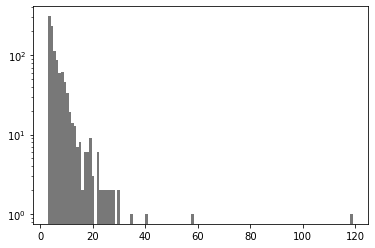

In [10]:
hist = plt.hist([x[1] for x in cluster_sizes], color='#787878', bins=max([x[1] for x in cluster_sizes]))
plt.yscale('log')
plt.savefig('bioplex_figures/cluster_sizes.svg')
plt.show()

In [11]:
def get_out_edges(subG, G):
    clust_out_edges = []
    for node in subG.nodes():
        out_first_neighbor_nodes = nx.neighbors(G, node) - subG.nodes()
        clust_out_edges.extend([frozenset((node, n)) for n in out_first_neighbor_nodes])
    return set(clust_out_edges)

In [12]:
clusters_dict = {}
node_tt_type = nx.get_node_attributes(G_o, 'tt_type')
for n, clust in enumerate(cluster_sizes):
    cluster_G = nx.subgraph(G_o, [node_idx[x] for x in clust[0]])
    cluster_G_nodes = set(cluster_G.nodes())
    clusters_dict[n] = {'graph':cluster_G, 'contains_alt': False}
    if any(node_tt_type[n]=='alt' for n in cluster_G.nodes()):
        clusters_dict[n]['contains_alt'] = True
        clusters_dict[n]['alts'] = [n for n in cluster_G.nodes() if node_tt_type[n]=='alt']
    #compute the number of connections each cluster has with nodes not in the cluster
    clusters_dict[n]['outward_edges'] = get_out_edges(cluster_G, G_o)
    clusters_dict[n]['node_type'] = 'clust'

In [13]:
cnt_alt_clust = sum(clust['contains_alt'] for clust in clusters_dict.values())
cnt_alt_clust/len(clusters_dict)

0.15180265654648956

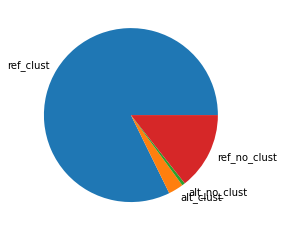

In [14]:
clust_nodes = set(x for y in [clust['graph'].nodes() for clust in clusters_dict.values()] for x in y)
ref_clust_nodes = sum(not is_alt(n) for n in clust_nodes)
alt_clust_nodes = sum(is_alt(n) for n in clust_nodes)
all_nodes = set(G_o.nodes())
ref_all_nodes = sum(not is_alt(n) and n not in clust_nodes for n in all_nodes)
alt_all_nodes = sum(is_alt(n) and n not in clust_nodes for n in all_nodes)
labels = 'ref_clust', 'alt_clust', 'alt_no_clust', 'ref_no_clust'
plt.pie([ref_clust_nodes, alt_clust_nodes, alt_all_nodes, ref_all_nodes], labels=labels)
plt.savefig('bioplex_figures/clust_nodes_pie.svg')
plt.show()

In [15]:
outward_edges_set = set([x for y in [list(x['outward_edges']) for x in clusters_dict.values()] for x in y])
clust_pairs = {}
clust_pairs_set = set()
for clust_n1, clust_dict1 in clusters_dict.items():
    for clust_n2, clust_dict2 in clusters_dict.items():   
        clust_pair = frozenset((clust_n1, clust_n2))
        if clust_n1 == clust_n2 or clust_pair in clust_pairs_set:continue # pass if its the same cluster or if the pair has already been processed
        clust_pairs_set.add(clust_pair)
        
        clust1_out_edges = clust_dict1['outward_edges']
        clust2_out_edges = clust_dict2['outward_edges']
        
        outward_edges_intersect = clust1_out_edges.intersection(clust2_out_edges)
        cnt_int = len(outward_edges_intersect)
        if cnt_int >0:
            clust_pairs[clust_pair] = {'cnt_int':cnt_int}
            clust1_out_edges_only   = clust1_out_edges.difference(clust2_out_edges)
            clust2_out_edges_only   = clust2_out_edges.difference(clust1_out_edges)
            cont_table = [
                [cnt_int,                    len(clust2_out_edges_only)],
                [len(clust1_out_edges_only), len(outward_edges_set.difference(clust1_out_edges.union(clust2_out_edges)))]
            ]
            odds_ratio, pval = stats.fisher_exact(cont_table, alternative='greater')
            clust_pairs[clust_pair]['odds_ratio'] = odds_ratio
            clust_pairs[clust_pair]['pval'] = pval

In [16]:
clust_pairs_arr = sorted(clust_pairs.items(), key = lambda x: x[1]['pval'])
clust_pairs_pvals = [x[1]['pval'] for x in clust_pairs_arr]
clust_pairs_pvals = sorted(clust_pairs_pvals)
fdr_bh = multipletests(clust_pairs_pvals, method='fdr_bh', alpha=0.01, is_sorted=True)
corrected_pvals = fdr_bh[1]
fdr_bh = fdr_bh[0]
clust_net = list(itt.compress(clust_pairs_arr, fdr_bh))

clusters_with_alts = [clust for clust_n, clust in clusters_dict.items() if clust['contains_alt']]
print('clusters with alts:', len(clusters_with_alts))
G_clust = nx.Graph()
G_clust.add_edges_from([tuple(e[0]) for e in clust_net])
free_floating = [n for n in clusters_dict.keys() if n not in G_clust]
G_clust.add_nodes_from(free_floating)
print('nodes: {}\nedges: {}'.format(len(G_clust.nodes), len(G_clust.edges)))

clusters with alts: 160
nodes: 1054
edges: 351


In [17]:
def get_sig_go(GO_result, pval_key='p_fdr', fdr=0.05):
    GO = sorted([(x.NS, x.GO, x.name, '|'.join(list(x.study_items)), x.p_fdr) for x in GO_result if x.p_fdr<fdr])
    go_hierar = {}
    for NS, GOs in itt.groupby(GO, key=lambda x: x[0]):
        go_hierar[NS] = []
        for _, go_id, go_name, study_items, pval in GOs:
            if not study_items: continue
            go_hierar[NS].append({
                'go_id':go_id, 
                'go_name':go_name,
                pval_key:pval,
                'study_items':study_items,
            })
    
    return go_hierar

In [18]:
full_GO_results = {}
for clust_n, clust_dict in clusters_dict.items():
    gene_list = set(n for n in clust_dict['graph'].nodes() if 'IP_' not in n and 'II_' not in n)
    GO_result = GOEA.run_study_nts(gene_list)
    full_GO_results[clust_n] = GO_result
    
    clust_dict['GO_result'] = get_sig_go(GO_result)


Run GOEA Gene Ontology Analysis: current study set of 118 IDs ...
 97%    114 of    118 study items found in association
100%    118 of    118 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     379 GO terms are associated with    114 of    118 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00014168742594369892
Sample 10 / 500: p-value 1.019913109546247e-05
Sample 20 / 500: p-value 0.0027410230370945718
Sample 30 / 500: p-value 0.0018440056434173148
Sample 40 / 500: p-value 0.009606021439907316
Sample 50 / 500: p-value 0.0005497818916873214
Sample 60 / 500: p-value 0.0027410230370945718
Sample 70 / 500: p-value 0.006402164701776701
Sample 80 / 500: p-value 0.00012410083318728732
Sample 90 / 500: p-value 0.0023234355998370338
Sample 100 / 500: p-value 0.0005633493089203199
Sample 110 / 500: p-value 0.009539665884241287
Sample 120 / 500: p-value 0.0015201788807353465
Sample 130 / 500: p-value 0.0005633493089203199
Sample 140 / 500: p-value 0.0005633493089203199
Sample 150 / 500: p-value 0.0005633493089203199
Sample 160 / 500: p-value 0.0018059305283686055
Sample 170 / 500: p-value 0.001116499486745273
Sample 180 / 500: p-value 0.0018440056434173148
Sample 190 / 500:

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 58 IDs ...
100%     58 of     58 study items found in association
100%     58 of     58 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     194 GO terms are associated with     58 of     58 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005777112743982342
Sample 10 / 500: p-value 0.001971740255427835
Sample 20 / 500: p-value 0.0016293914389894676
Sample 30 / 500: p-value 0.006794751639999746
Sample 40 / 500: p-value 0.0018129696895538608
Sample 50 / 500: p-value 0.0020675624479339822
Sample 60 / 500: p-value 0.002866738416054573
Sample 70 / 500: p-value 0.00512212274309739
Sample 80 / 500: p-value 0.0023994013778936537
Sample 90 / 500: p-value 0.0006157747924056017
Sample 100 / 500: p-value 0.005779842928053878
Sample 110 / 500: p-value 0.004316822291807515
Sample 120 / 500: p-value 0.0015843004848617932
Sample 130 / 500: p-value 0.002866738416054573
Sample 140 / 500: p-value 0.006474076851859995
Sample 150 / 500: p-value 0.0011308892185497167
Sample 160 / 500: p-value 0.0009322936874782845
Sample 170 / 500: p-value 0.006794751639999746
Sample 180 / 500: p-value 0.000544501035310974
Sample 190 / 500: p-value 0

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
      44 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 41 IDs ...
 98%     40 of     41 study items found in association
100%     41 of     41 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     158 GO terms are associated with     40 of     41 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004803186504120442
Sample 10 / 500: p-value 0.004803186504120442
Sample 20 / 500: p-value 0.0018254091695046352
Sample 30 / 500: p-value 0.004803186504120442
Sample 40 / 500: p-value 0.004803186504120442
Sample 50 / 500: p-value 0.0006188692030113254
Sample 60 / 500: p-value 0.004803186504120442
Sample 70 / 500: p-value 0.00046556822755468714
Sample 80 / 500: p-value 0.004803186504120442
Sample 90 / 500: p-value 0.000584511436449323
Sample 100 / 500: p-value 0.0001941048452856227
Sample 110 / 500: p-value 0.004803186504120442
Sample 120 / 500: p-value 0.004803186504120442
Sample 130 / 500: p-value 0.0022718453922030398
Sample 140 / 500: p-value 3.175216601951074e-05
Sample 150 / 500: p-value 0.0019749281681833175
Sample 160 / 500: p-value 0.004803186504120442
Sample 170 / 500: p-value 2.7766808775993383e-05
Sample 180 / 500: p-value 0.0019749281681833175
Sample 190 / 500: p-val

  METHOD fdr:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): local fdr
      17 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 35 IDs ...
100%     35 of     35 study items found in association
100%     35 of     35 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     131 GO terms are associated with     35 of     35 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008777524327135723
Sample 10 / 500: p-value 0.001441105052762271
Sample 20 / 500: p-value 0.0008496318563248682
Sample 30 / 500: p-value 0.0023981478591288633
Sample 40 / 500: p-value 0.004100281162080388
Sample 50 / 500: p-value 0.004100281162080388
Sample 60 / 500: p-value 0.0026733995865626413
Sample 70 / 500: p-value 0.0004460135253315231
Sample 80 / 500: p-value 0.0005774972531097539
Sample 90 / 500: p-value 0.00021082400749506658
Sample 100 / 500: p-value 0.0029628173358226075
Sample 110 / 500: p-value 0.0011493573389576228
Sample 120 / 500: p-value 0.001050593362889915
Sample 130 / 500: p-value 0.004100281162080388
Sample 140 / 500: p-value 0.004100281162080388
Sample 150 / 500: p-value 0.004100281162080388
Sample 160 / 500: p-value 0.004100281162080388
Sample 170 / 500: p-value 0.004100281162080388
Sample 180 / 500: p-value 0.004100281162080388
Sample 190 / 500: p-valu

  METHOD fdr:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): local fdr
      24 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 27 IDs ...
100%     27 of     27 study items found in association
100%     27 of     27 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     233 GO terms are associated with     27 of     27 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00026665224637269474
Sample 10 / 500: p-value 0.0031630740393131184
Sample 20 / 500: p-value 0.00026665224637269474
Sample 30 / 500: p-value 0.0003421696798560462
Sample 40 / 500: p-value 0.0031630740393131184
Sample 50 / 500: p-value 0.0031630740393131184
Sample 60 / 500: p-value 0.0031630740393131184
Sample 70 / 500: p-value 0.0031630740393131184
Sample 80 / 500: p-value 0.0012326919815673842
Sample 90 / 500: p-value 0.0031630740393131184
Sample 100 / 500: p-value 0.0009863748467572532
Sample 110 / 500: p-value 9.579274023403994e-05
Sample 120 / 500: p-value 0.0031630740393131184
Sample 130 / 500: p-value 0.0031630740393131184
Sample 140 / 500: p-value 0.0031630740393131184
Sample 150 / 500: p-value 0.0019498020180235547
Sample 160 / 500: p-value 0.006316512469411946
Sample 170 / 500: p-value 0.0031630740393131184
Sample 180 / 500: p-value 0.0031630740393131184
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 30 IDs ...
100%     30 of     30 study items found in association
100%     30 of     30 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     217 GO terms are associated with     30 of     30 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003514526710315129
Sample 10 / 500: p-value 1.1941567029860887e-05
Sample 20 / 500: p-value 0.003514526710315129
Sample 30 / 500: p-value 0.0015716439236661418
Sample 40 / 500: p-value 0.0010611018628571957
Sample 50 / 500: p-value 0.0001775618669580473
Sample 60 / 500: p-value 0.0013897765514780554
Sample 70 / 500: p-value 0.000653730505113733
Sample 80 / 500: p-value 7.133633245209693e-05
Sample 90 / 500: p-value 0.0031411595610830664
Sample 100 / 500: p-value 0.003514526710315129
Sample 110 / 500: p-value 0.0004233608105091786
Sample 120 / 500: p-value 0.003514526710315129
Sample 130 / 500: p-value 0.0007710870422254728
Sample 140 / 500: p-value 0.0009092951382497273
Sample 150 / 500: p-value 0.003514526710315129
Sample 160 / 500: p-value 0.003514526710315129
Sample 170 / 500: p-value 0.0007710870422254728
Sample 180 / 500: p-value 0.003514526710315129
Sample 190 / 500: p-va

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 28 IDs ...
 96%     27 of     28 study items found in association
100%     28 of     28 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      79 GO terms are associated with     27 of     28 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002878871186234744
Sample 10 / 500: p-value 0.00017874684478370046
Sample 20 / 500: p-value 0.003280224929679836
Sample 30 / 500: p-value 0.0006273743068162627
Sample 40 / 500: p-value 0.003280224929679836
Sample 50 / 500: p-value 0.003280224929679836
Sample 60 / 500: p-value 0.003280224929679836
Sample 70 / 500: p-value 0.000560383023050524
Sample 80 / 500: p-value 0.000560383023050524
Sample 90 / 500: p-value 0.003280224929679836
Sample 100 / 500: p-value 0.003280224929679836
Sample 110 / 500: p-value 0.003280224929679836
Sample 120 / 500: p-value 0.003280224929679836
Sample 130 / 500: p-value 0.0015368986912184376
Sample 140 / 500: p-value 0.0007915050992698581
Sample 150 / 500: p-value 0.003280224929679836
Sample 160 / 500: p-value 0.003280224929679836
Sample 170 / 500: p-value 0.003280224929679836
Sample 180 / 500: p-value 0.003280224929679836
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
      24 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 28 IDs ...
100%     28 of     28 study items found in association
100%     28 of     28 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     245 GO terms are associated with     28 of     28 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003280224929679836
Sample 10 / 500: p-value 0.003280224929679836
Sample 20 / 500: p-value 0.003280224929679836
Sample 30 / 500: p-value 0.002378883635722373
Sample 40 / 500: p-value 0.00031201507071615804
Sample 50 / 500: p-value 0.003280224929679836
Sample 60 / 500: p-value 0.0010611721500251405
Sample 70 / 500: p-value 0.0017142308565664447
Sample 80 / 500: p-value 0.003280224929679836
Sample 90 / 500: p-value 0.003280224929679836
Sample 100 / 500: p-value 0.0002157097069219269
Sample 110 / 500: p-value 0.003280224929679836
Sample 120 / 500: p-value 0.003280224929679836
Sample 130 / 500: p-value 0.00018383179347983893
Sample 140 / 500: p-value 0.003280224929679836
Sample 150 / 500: p-value 0.003280224929679836
Sample 160 / 500: p-value 0.003280224929679836
Sample 170 / 500: p-value 0.00010313720056347226
Sample 180 / 500: p-value 0.003280224929679836
Sample 190 / 500: p-value

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 25 IDs ...
 96%     24 of     25 study items found in association
100%     25 of     25 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      86 GO terms are associated with     24 of     25 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029287722586203812
Sample 10 / 500: p-value 0.0029287722586203812
Sample 20 / 500: p-value 0.0029287722586203812
Sample 30 / 500: p-value 0.0029287722586203812
Sample 40 / 500: p-value 0.0007334485434978389
Sample 50 / 500: p-value 0.0029287722586203812
Sample 60 / 500: p-value 0.0027638059543914277
Sample 70 / 500: p-value 0.0007334485434978389
Sample 80 / 500: p-value 0.0029287722586203812
Sample 90 / 500: p-value 0.00042125014151268885
Sample 100 / 500: p-value 0.0029287722586203812
Sample 110 / 500: p-value 0.0029287722586203812
Sample 120 / 500: p-value 0.0029287722586203812
Sample 130 / 500: p-value 0.0029287722586203812
Sample 140 / 500: p-value 0.0029287722586203812
Sample 150 / 500: p-value 0.0013659250305595272
Sample 160 / 500: p-value 0.0029287722586203812
Sample 170 / 500: p-value 0.0029287722586203812
Sample 180 / 500: p-value 0.001090255626671878
Sample 190 / 50

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
      18 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 27 IDs ...
100%     27 of     27 study items found in association
100%     27 of     27 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     169 GO terms are associated with     27 of     27 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006316512469411946
Sample 10 / 500: p-value 0.0031630740393131184
Sample 20 / 500: p-value 0.002506555636186657
Sample 30 / 500: p-value 0.0029882970342879293
Sample 40 / 500: p-value 0.0031630740393131184
Sample 50 / 500: p-value 0.0031630740393131184
Sample 60 / 500: p-value 0.0017675487229799906
Sample 70 / 500: p-value 0.0001434086216276848
Sample 80 / 500: p-value 0.0031630740393131184
Sample 90 / 500: p-value 0.0031630740393131184
Sample 100 / 500: p-value 0.0031630740393131184
Sample 110 / 500: p-value 0.0031630740393131184
Sample 120 / 500: p-value 0.0015938983157798747
Sample 130 / 500: p-value 2.8850373538666724e-05
Sample 140 / 500: p-value 0.0031630740393131184
Sample 150 / 500: p-value 0.0014289030922410666
Sample 160 / 500: p-value 0.0031630740393131184
Sample 170 / 500: p-value 0.002879207347344839
Sample 180 / 500: p-value 0.00026665224637269474
Sample 190 / 500

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 26 IDs ...
100%     26 of     26 study items found in association
100%     26 of     26 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     148 GO terms are associated with     26 of     26 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014777905658616823
Sample 10 / 500: p-value 0.0030459231489604875
Sample 20 / 500: p-value 0.0030459231489604875
Sample 30 / 500: p-value 0.0030459231489604875
Sample 40 / 500: p-value 0.0030459231489604875
Sample 50 / 500: p-value 0.0030459231489604875
Sample 60 / 500: p-value 0.00031699720201950113
Sample 70 / 500: p-value 0.0006816973639287464
Sample 80 / 500: p-value 0.0030459231489604875
Sample 90 / 500: p-value 5.333063925986191e-05
Sample 100 / 500: p-value 0.0030459231489604875
Sample 110 / 500: p-value 0.0030459231489604875
Sample 120 / 500: p-value 0.0030459231489604875
Sample 130 / 500: p-value 0.0030459231489604875
Sample 140 / 500: p-value 0.0030459231489604875
Sample 150 / 500: p-value 0.0030459231489604875
Sample 160 / 500: p-value 0.0013247114122380496
Sample 170 / 500: p-value 0.0030459231489604875
Sample 180 / 500: p-value 0.0014777905658616823
Sample 190 / 5

  METHOD fdr:
      22 GO terms found significant (< 0.05=alpha) ( 22 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 26 IDs ...
 96%     25 of     26 study items found in association
100%     26 of     26 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     249 GO terms are associated with     25 of     26 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0002470160887230207
Sample 10 / 500: p-value 8.921860424654072e-06
Sample 20 / 500: p-value 0.0030459231489604875
Sample 30 / 500: p-value 0.0027721204387492647
Sample 40 / 500: p-value 0.0030459231489604875
Sample 50 / 500: p-value 0.0030459231489604875
Sample 60 / 500: p-value 0.0014777905658616823
Sample 70 / 500: p-value 0.006082924437482505
Sample 80 / 500: p-value 0.0030459231489604875
Sample 90 / 500: p-value 0.0003270524691875933
Sample 100 / 500: p-value 0.0030459231489604875
Sample 110 / 500: p-value 0.001985136112482979
Sample 120 / 500: p-value 0.0030459231489604875
Sample 130 / 500: p-value 0.0030459231489604875
Sample 140 / 500: p-value 0.0030459231489604875
Sample 150 / 500: p-value 0.0016389187917098104
Sample 160 / 500: p-value 0.0030459231489604875
Sample 170 / 500: p-value 0.0030459231489604875
Sample 180 / 500: p-value 0.0030459231489604875
Sample 190 / 500:

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 24 IDs ...
100%     24 of     24 study items found in association
100%     24 of     24 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     241 GO terms are associated with     24 of     24 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0001045037559343002
Sample 10 / 500: p-value 0.0028116213683063254
Sample 20 / 500: p-value 0.00011287164824487271
Sample 30 / 500: p-value 0.0028116213683063254
Sample 40 / 500: p-value 0.0028116213683063254
Sample 50 / 500: p-value 0.0028116213683063254
Sample 60 / 500: p-value 0.0006754053850237054
Sample 70 / 500: p-value 0.0028116213683063254
Sample 80 / 500: p-value 0.0028116213683063254
Sample 90 / 500: p-value 0.0028116213683063254
Sample 100 / 500: p-value 7.537726048136531e-05
Sample 110 / 500: p-value 0.0056156660182246285
Sample 120 / 500: p-value 0.0028116213683063254
Sample 130 / 500: p-value 0.0028116213683063254
Sample 140 / 500: p-value 0.0028116213683063254
Sample 150 / 500: p-value 0.0028116213683063254
Sample 160 / 500: p-value 0.0028116213683063254
Sample 170 / 500: p-value 0.0028116213683063254
Sample 180 / 500: p-value 0.00379316733578014
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 24 IDs ...
 96%     23 of     24 study items found in association
100%     24 of     24 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     112 GO terms are associated with     23 of     24 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028116213683063254
Sample 10 / 500: p-value 0.0028116213683063254
Sample 20 / 500: p-value 0.0028116213683063254
Sample 30 / 500: p-value 2.2691090772148295e-05
Sample 40 / 500: p-value 0.0028116213683063254
Sample 50 / 500: p-value 0.0028116213683063254
Sample 60 / 500: p-value 0.0028116213683063254
Sample 70 / 500: p-value 6.966714804768209e-06
Sample 80 / 500: p-value 0.0004103212662007833
Sample 90 / 500: p-value 0.00041843064808225086
Sample 100 / 500: p-value 0.0028116213683063254
Sample 110 / 500: p-value 0.0028116213683063254
Sample 120 / 500: p-value 0.0010042103496275907
Sample 130 / 500: p-value 1.837554567033373e-05
Sample 140 / 500: p-value 0.0028116213683063254
Sample 150 / 500: p-value 0.0004103212662007833
Sample 160 / 500: p-value 0.0011277988001444396
Sample 170 / 500: p-value 0.0028116213683063254
Sample 180 / 500: p-value 0.0028116213683063254
Sample 190 / 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 24 IDs ...
 96%     23 of     24 study items found in association
100%     24 of     24 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     162 GO terms are associated with     23 of     24 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028116213683063254
Sample 10 / 500: p-value 6.802468203544734e-05
Sample 20 / 500: p-value 0.0028116213683063254
Sample 30 / 500: p-value 0.0028116213683063254
Sample 40 / 500: p-value 0.0028116213683063254
Sample 50 / 500: p-value 0.0028116213683063254
Sample 60 / 500: p-value 0.0002099705778041544
Sample 70 / 500: p-value 0.0018489886198634542
Sample 80 / 500: p-value 0.0028116213683063254
Sample 90 / 500: p-value 0.00026949856584178257
Sample 100 / 500: p-value 0.0013957348249710616
Sample 110 / 500: p-value 0.0028116213683063254
Sample 120 / 500: p-value 0.0028116213683063254
Sample 130 / 500: p-value 7.537726048136531e-05
Sample 140 / 500: p-value 0.00041843064808225086
Sample 150 / 500: p-value 0.0028116213683063254
Sample 160 / 500: p-value 0.0028116213683063254
Sample 170 / 500: p-value 0.001540009189290829
Sample 180 / 500: p-value 0.0016811326110470406
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 23 IDs ...
100%     23 of     23 study items found in association
100%     23 of     23 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      81 GO terms are associated with     23 of     23 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0026944704779188846
Sample 10 / 500: p-value 0.0026944704779188846
Sample 20 / 500: p-value 0.0026944704779188846
Sample 30 / 500: p-value 0.0026944704779188846
Sample 40 / 500: p-value 0.0008862910110331468
Sample 50 / 500: p-value 0.0026944704779188846
Sample 60 / 500: p-value 0.0026944704779188846
Sample 70 / 500: p-value 0.0026944704779188846
Sample 80 / 500: p-value 0.00014465968030021256
Sample 90 / 500: p-value 0.0026944704779188846
Sample 100 / 500: p-value 0.0026944704779188846
Sample 110 / 500: p-value 0.002682804273252791
Sample 120 / 500: p-value 0.001281221790027652
Sample 130 / 500: p-value 0.0026944704779188846
Sample 140 / 500: p-value 6.911203891219048e-05
Sample 150 / 500: p-value 0.002338437089949321
Sample 160 / 500: p-value 0.0026944704779188846
Sample 170 / 500: p-value 0.0026944704779188846
Sample 180 / 500: p-value 0.0026944704779188846
Sample 190 / 500:

  METHOD fdr:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 23 IDs ...
100%     23 of     23 study items found in association
100%     23 of     23 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     129 GO terms are associated with     23 of     23 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0026944704779188846
Sample 10 / 500: p-value 0.0026944704779188846
Sample 20 / 500: p-value 0.0026944704779188846
Sample 30 / 500: p-value 0.0026944704779188846
Sample 40 / 500: p-value 0.0026944704779188846
Sample 50 / 500: p-value 0.0026944704779188846
Sample 60 / 500: p-value 0.0026944704779188846
Sample 70 / 500: p-value 0.0026944704779188846
Sample 80 / 500: p-value 0.0026944704779188846
Sample 90 / 500: p-value 0.00018319552023033647
Sample 100 / 500: p-value 0.0013536416535450822
Sample 110 / 500: p-value 0.0026944704779188846
Sample 120 / 500: p-value 0.0026944704779188846
Sample 130 / 500: p-value 0.0026944704779188846
Sample 140 / 500: p-value 0.0026944704779188846
Sample 150 / 500: p-value 0.00251578064961163
Sample 160 / 500: p-value 0.0026944704779188846
Sample 170 / 500: p-value 0.0026944704779188846
Sample 180 / 500: p-value 0.00251578064961163
Sample 190 / 500: 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 23 IDs ...
100%     23 of     23 study items found in association
100%     23 of     23 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     193 GO terms are associated with     23 of     23 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007138696000157385
Sample 10 / 500: p-value 0.0002471755703290562
Sample 20 / 500: p-value 0.00037639245532466515
Sample 30 / 500: p-value 0.0026944704779188846
Sample 40 / 500: p-value 0.0003084630181104585
Sample 50 / 500: p-value 0.0026944704779188846
Sample 60 / 500: p-value 0.0026944704779188846
Sample 70 / 500: p-value 0.0026944704779188846
Sample 80 / 500: p-value 0.0026944704779188846
Sample 90 / 500: p-value 0.0018489886198578575
Sample 100 / 500: p-value 0.0026944704779188846
Sample 110 / 500: p-value 0.0015628908713189993
Sample 120 / 500: p-value 0.0003271060030546378
Sample 130 / 500: p-value 0.0015526005798182669
Sample 140 / 500: p-value 0.0026944704779188846
Sample 150 / 500: p-value 0.0007138696000157385
Sample 160 / 500: p-value 0.0003084630181104585
Sample 170 / 500: p-value 0.0026944704779188846
Sample 180 / 500: p-value 0.0026944704779188846
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
100%     22 of     22 study items found in association
100%     22 of     22 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     175 GO terms are associated with     22 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025773195876068627
Sample 10 / 500: p-value 0.0025773195876068627
Sample 20 / 500: p-value 0.0025773195876068627
Sample 30 / 500: p-value 0.0006524560538135903
Sample 40 / 500: p-value 0.00041831043895152923
Sample 50 / 500: p-value 0.0004861978108535742
Sample 60 / 500: p-value 9.452778720299978e-05
Sample 70 / 500: p-value 0.00013213222799826719
Sample 80 / 500: p-value 0.0011714554913868462
Sample 90 / 500: p-value 0.0004861978108535742
Sample 100 / 500: p-value 7.71197191970046e-05
Sample 110 / 500: p-value 0.0025773195876068627
Sample 120 / 500: p-value 0.0025773195876068627
Sample 130 / 500: p-value 0.0019851361124943703
Sample 140 / 500: p-value 0.0025773195876068627
Sample 150 / 500: p-value 0.0002692875940627656
Sample 160 / 500: p-value 0.0025773195876068627
Sample 170 / 500: p-value 0.005148297791421988
Sample 180 / 500: p-value 0.0025773195876068627
Sample 190 / 50

  METHOD fdr:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 21 IDs ...
100%     21 of     21 study items found in association
100%     21 of     21 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     137 GO terms are associated with     21 of     21 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024601686972317532
Sample 10 / 500: p-value 0.0004423780037592211
Sample 20 / 500: p-value 0.0024601686972317532
Sample 30 / 500: p-value 0.0005937443857776678
Sample 40 / 500: p-value 0.0024601686972317532
Sample 50 / 500: p-value 0.0024601686972317532
Sample 60 / 500: p-value 0.0024601686972317532
Sample 70 / 500: p-value 0.0024601686972317532
Sample 80 / 500: p-value 0.0024601686972317532
Sample 90 / 500: p-value 0.0018080494552038403
Sample 100 / 500: p-value 0.0024601686972317532
Sample 110 / 500: p-value 0.0024601686972317532
Sample 120 / 500: p-value 0.001671443919329309
Sample 130 / 500: p-value 0.0024601686972317532
Sample 140 / 500: p-value 0.0024601686972317532
Sample 150 / 500: p-value 0.0024601686972317532
Sample 160 / 500: p-value 0.0024601686972317532
Sample 170 / 500: p-value 0.0024601686972317532
Sample 180 / 500: p-value 0.0024601686972317532
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 21 IDs ...
 95%     20 of     21 study items found in association
100%     21 of     21 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     174 GO terms are associated with     20 of     21 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024601686972317532
Sample 10 / 500: p-value 0.0008671477577271836
Sample 20 / 500: p-value 0.0008613290047756017
Sample 30 / 500: p-value 0.0024601686972317532
Sample 40 / 500: p-value 0.0022486534891980755
Sample 50 / 500: p-value 0.0019498020180263294
Sample 60 / 500: p-value 0.0024601686972317532
Sample 70 / 500: p-value 0.0010664565849844816
Sample 80 / 500: p-value 0.00015998520936019177
Sample 90 / 500: p-value 0.0024601686972317532
Sample 100 / 500: p-value 0.0024601686972317532
Sample 110 / 500: p-value 0.0009612352493991194
Sample 120 / 500: p-value 0.0024601686972317532
Sample 130 / 500: p-value 0.0022486534891980755
Sample 140 / 500: p-value 0.0024601686972317532
Sample 150 / 500: p-value 0.0024601686972317532
Sample 160 / 500: p-value 0.0024601686972317532
Sample 170 / 500: p-value 0.0009612352493991194
Sample 180 / 500: p-value 0.0024601686972317532
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
 95%     21 of     22 study items found in association
100%     22 of     22 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     156 GO terms are associated with     21 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025773195876068627
Sample 10 / 500: p-value 0.0025773195876068627
Sample 20 / 500: p-value 0.0025773195876068627
Sample 30 / 500: p-value 0.0005663456073606418
Sample 40 / 500: p-value 0.0002818163016890641
Sample 50 / 500: p-value 0.0025773195876068627
Sample 60 / 500: p-value 0.0009462792317803908
Sample 70 / 500: p-value 0.0004861978108535742
Sample 80 / 500: p-value 0.0025773195876068627
Sample 90 / 500: p-value 0.0025773195876068627
Sample 100 / 500: p-value 0.0004861978108535742
Sample 110 / 500: p-value 0.0025773195876068627
Sample 120 / 500: p-value 0.0025773195876068627
Sample 130 / 500: p-value 0.0025773195876068627
Sample 140 / 500: p-value 0.0025773195876068627
Sample 150 / 500: p-value 0.0025773195876068627
Sample 160 / 500: p-value 0.002483054851176056
Sample 170 / 500: p-value 0.0025773195876068627
Sample 180 / 500: p-value 0.0009462792317803908
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
 95%     21 of     22 study items found in association
100%     22 of     22 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     160 GO terms are associated with     21 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009554336510249371
Sample 10 / 500: p-value 0.0025773195876068627
Sample 20 / 500: p-value 0.0025773195876068627
Sample 30 / 500: p-value 0.0025773195876068627
Sample 40 / 500: p-value 0.0014619415917723159
Sample 50 / 500: p-value 0.0009462792317803908
Sample 60 / 500: p-value 0.0025773195876068627
Sample 70 / 500: p-value 0.0025773195876068627
Sample 80 / 500: p-value 6.341383871098967e-06
Sample 90 / 500: p-value 3.7929510841422435e-05
Sample 100 / 500: p-value 0.0025773195876068627
Sample 110 / 500: p-value 0.0025773195876068627
Sample 120 / 500: p-value 0.0025773195876068627
Sample 130 / 500: p-value 0.0025773195876068627
Sample 140 / 500: p-value 0.00013213222799826719
Sample 150 / 500: p-value 0.0025773195876068627
Sample 160 / 500: p-value 0.00013213222799826719
Sample 170 / 500: p-value 0.0025773195876068627
Sample 180 / 500: p-value 0.0025773195876068627
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 22 IDs ...
100%     22 of     22 study items found in association
100%     22 of     22 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     192 GO terms are associated with     22 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022241021004393746
Sample 10 / 500: p-value 0.001870585709143661
Sample 20 / 500: p-value 0.0009462792317803908
Sample 30 / 500: p-value 0.0025773195876068627
Sample 40 / 500: p-value 0.0025773195876068627
Sample 50 / 500: p-value 0.0025773195876068627
Sample 60 / 500: p-value 0.001055956694335867
Sample 70 / 500: p-value 0.0025773195876068627
Sample 80 / 500: p-value 0.0009462792317803908
Sample 90 / 500: p-value 0.0025773195876068627
Sample 100 / 500: p-value 0.00010041832024724719
Sample 110 / 500: p-value 0.0025773195876068627
Sample 120 / 500: p-value 0.0004861978108535742
Sample 130 / 500: p-value 0.0013690644220951582
Sample 140 / 500: p-value 0.0025773195876068627
Sample 150 / 500: p-value 0.0025773195876068627
Sample 160 / 500: p-value 0.0018352935563419816
Sample 170 / 500: p-value 0.0025773195876068627
Sample 180 / 500: p-value 0.0025773195876068627
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 20 IDs ...
100%     20 of     20 study items found in association
100%     20 of     20 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     114 GO terms are associated with     20 of     20 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002343017806907395
Sample 10 / 500: p-value 0.002343017806907395
Sample 20 / 500: p-value 3.12071962258227e-05
Sample 30 / 500: p-value 0.002343017806907395
Sample 40 / 500: p-value 0.002343017806907395
Sample 50 / 500: p-value 0.002038782444235078
Sample 60 / 500: p-value 0.002343017806907395
Sample 70 / 500: p-value 0.0016389187917127104
Sample 80 / 500: p-value 0.002343017806907395
Sample 90 / 500: p-value 0.0006137002791940235
Sample 100 / 500: p-value 0.002343017806907395
Sample 110 / 500: p-value 0.002343017806907395
Sample 120 / 500: p-value 0.002343017806907395
Sample 130 / 500: p-value 0.002343017806907395
Sample 140 / 500: p-value 0.002343017806907395
Sample 150 / 500: p-value 0.0003394383817585251
Sample 160 / 500: p-value 0.0009662457891874118
Sample 170 / 500: p-value 0.004680819756959019
Sample 180 / 500: p-value 0.002343017806907395
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 20 IDs ...
 95%     19 of     20 study items found in association
100%     20 of     20 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with     19 of     20 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002343017806907395
Sample 10 / 500: p-value 0.002343017806907395
Sample 20 / 500: p-value 0.0018195401378149156
Sample 30 / 500: p-value 0.0008708438852114798
Sample 40 / 500: p-value 0.002343017806907395
Sample 50 / 500: p-value 0.002343017806907395
Sample 60 / 500: p-value 0.002343017806907395
Sample 70 / 500: p-value 0.002343017806907395
Sample 80 / 500: p-value 0.00011508054530480451
Sample 90 / 500: p-value 0.002343017806907395
Sample 100 / 500: p-value 0.002343017806907395
Sample 110 / 500: p-value 0.00040059087193235486
Sample 120 / 500: p-value 0.002343017806907395
Sample 130 / 500: p-value 0.002343017806907395
Sample 140 / 500: p-value 0.002343017806907395
Sample 150 / 500: p-value 0.002343017806907395
Sample 160 / 500: p-value 0.0013957348249623483
Sample 170 / 500: p-value 0.002343017806907395
Sample 180 / 500: p-value 0.002343017806907395
Sample 190 / 500: p-value 0

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 20 IDs ...
100%     20 of     20 study items found in association
100%     20 of     20 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     193 GO terms are associated with     20 of     20 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002343017806907395
Sample 10 / 500: p-value 0.00040059087193235486
Sample 20 / 500: p-value 0.002343017806907395
Sample 30 / 500: p-value 0.002343017806907395
Sample 40 / 500: p-value 0.0011714554913821998
Sample 50 / 500: p-value 0.002343017806907395
Sample 60 / 500: p-value 0.0009662457891874118
Sample 70 / 500: p-value 0.002343017806907395
Sample 80 / 500: p-value 0.002343017806907395
Sample 90 / 500: p-value 0.002343017806907395
Sample 100 / 500: p-value 0.0012211771353444628
Sample 110 / 500: p-value 0.0012878536464759531
Sample 120 / 500: p-value 0.002343017806907395
Sample 130 / 500: p-value 0.002343017806907395
Sample 140 / 500: p-value 0.002343017806907395
Sample 150 / 500: p-value 0.0001859308863688395
Sample 160 / 500: p-value 0.002343017806907395
Sample 170 / 500: p-value 0.0009662457891874118
Sample 180 / 500: p-value 0.0022641922967598436
Sample 190 / 500: p-value

  METHOD fdr:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%     18 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      94 GO terms are associated with     18 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.0011277988001383054
Sample 30 / 500: p-value 0.0007802717170402668
Sample 40 / 500: p-value 0.001356344405453921
Sample 50 / 500: p-value 0.002108716026205638
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.002108716026205638
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.002108716026205638
Sample 110 / 500: p-value 0.002108716026205638
Sample 120 / 500: p-value 0.002108716026205638
Sample 130 / 500: p-value 0.00046481511510840023
Sample 140 / 500: p-value 0.0004339049130226709
Sample 150 / 500: p-value 0.0005697825722097644
Sample 160 / 500: p-value 0.002108716026205638
Sample 170 / 500: p-value 0.002108716026205638
Sample 180 / 500: p-value 0.0014289030922436084
Sample 190 / 500: p-value 0

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 95%     18 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      82 GO terms are associated with     18 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.0022258669165418805
Sample 20 / 500: p-value 0.0002734008799204484
Sample 30 / 500: p-value 4.6755951903883776e-05
Sample 40 / 500: p-value 0.0003057333377325011
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.00025359228049086184
Sample 100 / 500: p-value 0.0009612352493936732
Sample 110 / 500: p-value 0.0018387708141380937
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0006258277660484058
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0022258669165418805
Sample 160 / 500: p-value 0.0022258669165418805
Sample 170 / 500: p-value 0.0018387708141380937
Sample 180 / 500: p-value 0.0017142308565435427
Sample 190 / 

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 95%     18 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     143 GO terms are associated with     18 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.00025511634114902635
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0007848003254409727
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0022258669165418805
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.0022258669165418805
Sample 120 / 500: p-value 0.0007031223441713493
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0012583191830255948
Sample 150 / 500: p-value 0.0014777905658566349
Sample 160 / 500: p-value 0.00034415944126709347
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.00010161801265668687
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
100%     19 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     153 GO terms are associated with     19 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.0022258669165418805
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0014777905658566349
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0005529344663614731
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0022258669165418805
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.0006893928829253514
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0003608417533196226
Sample 150 / 500: p-value 0.00048446037119504565
Sample 160 / 500: p-value 0.0003057333377325011
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.0022258669165418805
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 95%     18 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     150 GO terms are associated with     18 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.0003608417533196226
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0006258277660484058
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.0022258669165418805
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0022258669165418805
Sample 160 / 500: p-value 0.0022258669165418805
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.0022258669165418805
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 95%     18 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      99 GO terms are associated with     18 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.0022258669165418805
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0019721984019679347
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0022258669165418805
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.0022258669165418805
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0022258669165418805
Sample 160 / 500: p-value 0.001365925030538144
Sample 170 / 500: p-value 0.0003608417533196226
Sample 180 / 500: p-value 0.0022258669165418805
Sample 190 / 500

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 95%     18 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     115 GO terms are associated with     18 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007848003254409727
Sample 10 / 500: p-value 0.0022258669165418805
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 4.694271177264212e-06
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.0022258669165418805
Sample 120 / 500: p-value 0.0009612352493936732
Sample 130 / 500: p-value 0.0007848003254409727
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0022258669165418805
Sample 160 / 500: p-value 0.0003057333377325011
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.0022258669165418805
Sample 190 / 50

  METHOD fdr:
      16 GO terms found significant (< 0.05=alpha) ( 16 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
100%     19 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     175 GO terms are associated with     19 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010621199484405132
Sample 10 / 500: p-value 0.0022258669165418805
Sample 20 / 500: p-value 0.0006258277660484058
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0021004037310163068
Sample 100 / 500: p-value 0.0004204234575104413
Sample 110 / 500: p-value 0.0022258669165418805
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0007031223441713493
Sample 160 / 500: p-value 0.004447039561913047
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.0066635272872687095
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 19 IDs ...
 89%     17 of     19 study items found in association
100%     19 of     19 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     105 GO terms are associated with     17 of     19 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022258669165418805
Sample 10 / 500: p-value 0.004447039561913047
Sample 20 / 500: p-value 0.0022258669165418805
Sample 30 / 500: p-value 0.0022258669165418805
Sample 40 / 500: p-value 0.0022258669165418805
Sample 50 / 500: p-value 0.0022258669165418805
Sample 60 / 500: p-value 0.0022258669165418805
Sample 70 / 500: p-value 0.0022258669165418805
Sample 80 / 500: p-value 0.0022258669165418805
Sample 90 / 500: p-value 0.0022258669165418805
Sample 100 / 500: p-value 0.0022258669165418805
Sample 110 / 500: p-value 0.001365925030538144
Sample 120 / 500: p-value 0.0022258669165418805
Sample 130 / 500: p-value 0.0022258669165418805
Sample 140 / 500: p-value 0.0022258669165418805
Sample 150 / 500: p-value 0.0022258669165418805
Sample 160 / 500: p-value 0.0003608417533196226
Sample 170 / 500: p-value 0.0022258669165418805
Sample 180 / 500: p-value 0.0022258669165418805
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
 94%     17 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with     17 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.0014289030922436084
Sample 20 / 500: p-value 0.002108716026205638
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.002108716026205638
Sample 50 / 500: p-value 0.002108716026205638
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.002108716026205638
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.002108716026205638
Sample 110 / 500: p-value 0.0001871249654751937
Sample 120 / 500: p-value 0.001099256858669308
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.0015368986912071348
Sample 150 / 500: p-value 0.002108716026205638
Sample 160 / 500: p-value 0.004213231915068333
Sample 170 / 500: p-value 0.002108716026205638
Sample 180 / 500: p-value 0.002108716026205638
Sample 190 / 500: p-value 0.002

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%     18 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     112 GO terms are associated with     18 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.0008613290047758646
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.002108716026205638
Sample 50 / 500: p-value 0.002108716026205638
Sample 60 / 500: p-value 0.0015368986912071348
Sample 70 / 500: p-value 0.002108716026205638
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.002108716026205638
Sample 110 / 500: p-value 0.002108716026205638
Sample 120 / 500: p-value 0.002108716026205638
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.002108716026205638
Sample 150 / 500: p-value 0.002108716026205638
Sample 160 / 500: p-value 0.0006298959017478857
Sample 170 / 500: p-value 0.002108716026205638
Sample 180 / 500: p-value 0.0002737647083112423
Sample 190 / 500: p-value 0.00

  METHOD fdr:
      32 GO terms found significant (< 0.05=alpha) ( 32 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%     18 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     164 GO terms are associated with     18 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.002108716026205638
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.002108716026205638
Sample 50 / 500: p-value 0.002108716026205638
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.002108716026205638
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.0013247114122414837
Sample 110 / 500: p-value 0.0015368986912071348
Sample 120 / 500: p-value 0.0012243383890948281
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.002108716026205638
Sample 150 / 500: p-value 0.0005697825722097644
Sample 160 / 500: p-value 0.002108716026205638
Sample 170 / 500: p-value 0.0003765211491638753
Sample 180 / 500: p-value 0.002108716026205638
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
 94%     17 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     103 GO terms are associated with     17 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.002108716026205638
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.0015368986912071348
Sample 50 / 500: p-value 0.00014988722647260244
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.004213231915068333
Sample 80 / 500: p-value 0.00048354387994059783
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.002108716026205638
Sample 110 / 500: p-value 0.002108716026205638
Sample 120 / 500: p-value 0.0016486835104231102
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.002108716026205638
Sample 150 / 500: p-value 0.002108716026205638
Sample 160 / 500: p-value 0.002108716026205638
Sample 170 / 500: p-value 0.004213231915068333
Sample 180 / 500: p-value 0.0017642428905315353
Sample 190 / 500: p-value 0

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%     18 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     122 GO terms are associated with     18 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00028890792201788335
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.002108716026205638
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.002108716026205638
Sample 50 / 500: p-value 0.00014988722647260244
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.002006626891260027
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 1.2584662822854449e-05
Sample 100 / 500: p-value 0.0004339049130226709
Sample 110 / 500: p-value 0.002108716026205638
Sample 120 / 500: p-value 0.002108716026205638
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.002108716026205638
Sample 150 / 500: p-value 0.002108716026205638
Sample 160 / 500: p-value 0.002108716026205638
Sample 170 / 500: p-value 0.0015368986912071348
Sample 180 / 500: p-value 0.002108716026205638
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 18 IDs ...
100%     18 of     18 study items found in association
100%     18 of     18 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with     18 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002108716026205638
Sample 10 / 500: p-value 0.002108716026205638
Sample 20 / 500: p-value 0.0007031223441755441
Sample 30 / 500: p-value 0.002108716026205638
Sample 40 / 500: p-value 0.002108716026205638
Sample 50 / 500: p-value 0.002108716026205638
Sample 60 / 500: p-value 0.002108716026205638
Sample 70 / 500: p-value 0.002108716026205638
Sample 80 / 500: p-value 0.002108716026205638
Sample 90 / 500: p-value 0.002108716026205638
Sample 100 / 500: p-value 0.002108716026205638
Sample 110 / 500: p-value 0.002108716026205638
Sample 120 / 500: p-value 0.002108716026205638
Sample 130 / 500: p-value 0.002108716026205638
Sample 140 / 500: p-value 0.0017642428905315353
Sample 150 / 500: p-value 0.002108716026205638
Sample 160 / 500: p-value 0.002108716026205638
Sample 170 / 500: p-value 0.002108716026205638
Sample 180 / 500: p-value 0.002108716026205638
Sample 190 / 500: p-value 0.0021

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     15 of     15 study items found in association
100%     15 of     15 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      69 GO terms are associated with     15 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017572633551604577
Sample 10 / 500: p-value 0.0017572633551604577
Sample 20 / 500: p-value 0.0017572633551604577
Sample 30 / 500: p-value 0.0017572633551604577
Sample 40 / 500: p-value 0.0017572633551604577
Sample 50 / 500: p-value 0.0017572633551604577
Sample 60 / 500: p-value 0.0017572633551604577
Sample 70 / 500: p-value 0.0009631382806045405
Sample 80 / 500: p-value 0.0017572633551604577
Sample 90 / 500: p-value 0.0017572633551604577
Sample 100 / 500: p-value 0.0017572633551604577
Sample 110 / 500: p-value 0.00022233250070927021
Sample 120 / 500: p-value 0.0017572633551604577
Sample 130 / 500: p-value 0.0017572633551604577
Sample 140 / 500: p-value 0.0007138696000149565
Sample 150 / 500: p-value 0.0017572633551604577
Sample 160 / 500: p-value 0.00022233250070927021
Sample 170 / 500: p-value 0.0017572633551604577
Sample 180 / 500: p-value 0.0035116442631186765
Sample 190 / 

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
 94%     15 of     16 study items found in association
100%     16 of     16 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     157 GO terms are associated with     15 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012985430369177105
Sample 10 / 500: p-value 0.00021505323212900635
Sample 20 / 500: p-value 0.0002958649090695043
Sample 30 / 500: p-value 0.0018744142455347878
Sample 40 / 500: p-value 0.0018744142455347878
Sample 50 / 500: p-value 0.0018744142455347878
Sample 60 / 500: p-value 0.0018744142455347878
Sample 70 / 500: p-value 0.0018744142455347878
Sample 80 / 500: p-value 0.0018744142455347878
Sample 90 / 500: p-value 0.0007445006963005829
Sample 100 / 500: p-value 0.0018744142455347878
Sample 110 / 500: p-value 0.0018744142455347878
Sample 120 / 500: p-value 0.0018744142455347878
Sample 130 / 500: p-value 0.0018744142455347878
Sample 140 / 500: p-value 4.9197584377814866e-05
Sample 150 / 500: p-value 0.0018744142455347878
Sample 160 / 500: p-value 0.0018744142455347878
Sample 170 / 500: p-value 0.0018744142455347878
Sample 180 / 500: p-value 0.0018744142455347878
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
 94%     16 of     17 study items found in association
100%     17 of     17 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     103 GO terms are associated with     16 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019915651358649667
Sample 10 / 500: p-value 0.0019915651358649667
Sample 20 / 500: p-value 0.0002198908851392474
Sample 30 / 500: p-value 0.0019915651358649667
Sample 40 / 500: p-value 0.0019915651358649667
Sample 50 / 500: p-value 0.0019915651358649667
Sample 60 / 500: p-value 0.0011797281565751425
Sample 70 / 500: p-value 0.0019915651358649667
Sample 80 / 500: p-value 0.0019915651358649667
Sample 90 / 500: p-value 0.0019915651358649667
Sample 100 / 500: p-value 0.0010902556266719375
Sample 110 / 500: p-value 0.0019915651358649667
Sample 120 / 500: p-value 0.0019915651358649667
Sample 130 / 500: p-value 0.0019915651358649667
Sample 140 / 500: p-value 0.00028747895469442
Sample 150 / 500: p-value 0.003979396816283379
Sample 160 / 500: p-value 0.0019915651358649667
Sample 170 / 500: p-value 0.0013000255605445036
Sample 180 / 500: p-value 0.0019915651358649667
Sample 190 / 500: 

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
      10 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
 94%     16 of     17 study items found in association
100%     17 of     17 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     131 GO terms are associated with     16 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019915651358649667
Sample 10 / 500: p-value 0.0019915651358649667
Sample 20 / 500: p-value 0.0019915651358649667
Sample 30 / 500: p-value 0.00038608510980789285
Sample 40 / 500: p-value 0.0006703208171800354
Sample 50 / 500: p-value 0.003979396816283379
Sample 60 / 500: p-value 0.0006258277660582704
Sample 70 / 500: p-value 0.0019915651358649667
Sample 80 / 500: p-value 0.0019915651358649667
Sample 90 / 500: p-value 0.0019915651358649667
Sample 100 / 500: p-value 0.0019915651358649667
Sample 110 / 500: p-value 0.00028747895469442
Sample 120 / 500: p-value 0.0019915651358649667
Sample 130 / 500: p-value 0.0019915651358649667
Sample 140 / 500: p-value 0.0019915651358649667
Sample 150 / 500: p-value 0.0019915651358649667
Sample 160 / 500: p-value 0.00010380404298023863
Sample 170 / 500: p-value 0.0019915651358649667
Sample 180 / 500: p-value 0.0019915651358649667
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
100%     17 of     17 study items found in association
100%     17 of     17 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with     17 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019915651358649667
Sample 10 / 500: p-value 0.0019915651358649667
Sample 20 / 500: p-value 0.0005606074452778144
Sample 30 / 500: p-value 0.0019915651358649667
Sample 40 / 500: p-value 0.0019915651358649667
Sample 50 / 500: p-value 0.00038608510980789285
Sample 60 / 500: p-value 0.0019915651358649667
Sample 70 / 500: p-value 0.0011367973683883703
Sample 80 / 500: p-value 0.0019915651358649667
Sample 90 / 500: p-value 0.0019915651358649667
Sample 100 / 500: p-value 0.0019915651358649667
Sample 110 / 500: p-value 0.0019915651358649667
Sample 120 / 500: p-value 0.0019915651358649667
Sample 130 / 500: p-value 0.00038602714783399607
Sample 140 / 500: p-value 0.0019915651358649667
Sample 150 / 500: p-value 0.0019915651358649667
Sample 160 / 500: p-value 0.0019915651358649667
Sample 170 / 500: p-value 0.0019915651358649667
Sample 180 / 500: p-value 0.0019915651358649667
Sample 190 / 

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 17 IDs ...
 88%     15 of     17 study items found in association
100%     17 of     17 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     108 GO terms are associated with     15 of     17 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019915651358649667
Sample 10 / 500: p-value 0.0019915651358649667
Sample 20 / 500: p-value 0.00044072348606967747
Sample 30 / 500: p-value 0.0013689055372765615
Sample 40 / 500: p-value 0.0019009639770015978
Sample 50 / 500: p-value 0.0019915651358649667
Sample 60 / 500: p-value 0.0019915651358649667
Sample 70 / 500: p-value 0.00047859441425717944
Sample 80 / 500: p-value 0.0019915651358649667
Sample 90 / 500: p-value 0.0019915651358649667
Sample 100 / 500: p-value 0.0019915651358649667
Sample 110 / 500: p-value 0.0019915651358649667
Sample 120 / 500: p-value 0.0019915651358649667
Sample 130 / 500: p-value 0.0019915651358649667
Sample 140 / 500: p-value 0.0019915651358649667
Sample 150 / 500: p-value 0.0019915651358649667
Sample 160 / 500: p-value 0.0019915651358649667
Sample 170 / 500: p-value 0.0019915651358649667
Sample 180 / 500: p-value 0.0019915651358649667
Sample 190 / 

  METHOD fdr:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
 20%      3 of     15 study items found in association
100%     15 of     15 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      3 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017572633551604577
Sample 10 / 500: p-value 0.0017572633551604577
Sample 20 / 500: p-value 0.0017572633551604577
Sample 30 / 500: p-value 0.00022233250070927021
Sample 40 / 500: p-value 0.0017572633551604577
Sample 50 / 500: p-value 0.0017572633551604577
Sample 60 / 500: p-value 0.0017572633551604577
Sample 70 / 500: p-value 0.0017572633551604577
Sample 80 / 500: p-value 0.0017572633551604577
Sample 90 / 500: p-value 0.0017572633551604577
Sample 100 / 500: p-value 0.0017572633551604577
Sample 110 / 500: p-value 0.0017572633551604577
Sample 120 / 500: p-value 0.0017572633551604577
Sample 130 / 500: p-value 0.0017572633551604577
Sample 140 / 500: p-value 0.0017572633551604577
Sample 150 / 500: p-value 0.0017572633551604577
Sample 160 / 500: p-value 0.0017572633551604577
Sample 170 / 500: p-value 0.0017572633551604577
Sample 180 / 500: p-value 0.0005937443857786719
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ...
100%     16 of     16 study items found in association
100%     16 of     16 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      70 GO terms are associated with     16 of     16 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018744142455347878
Sample 10 / 500: p-value 0.0018744142455347878
Sample 20 / 500: p-value 0.002588514951588701
Sample 30 / 500: p-value 0.0018744142455347878
Sample 40 / 500: p-value 0.0018744142455347878
Sample 50 / 500: p-value 0.0009637184545530383
Sample 60 / 500: p-value 0.0018744142455347878
Sample 70 / 500: p-value 0.0005529344663657007
Sample 80 / 500: p-value 0.0018744142455347878
Sample 90 / 500: p-value 0.0018744142455347878
Sample 100 / 500: p-value 0.0018744142455347878
Sample 110 / 500: p-value 0.0018744142455347878
Sample 120 / 500: p-value 4.9197584377814866e-05
Sample 130 / 500: p-value 0.0018744142455347878
Sample 140 / 500: p-value 0.0018744142455347878
Sample 150 / 500: p-value 0.0018744142455347878
Sample 160 / 500: p-value 0.0018744142455347878
Sample 170 / 500: p-value 0.0018744142455347878
Sample 180 / 500: p-value 0.0016596175118759882
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     134 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0032777268087997033
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0001928538485155629
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.0032777268087997033
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     108 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0032777268087997033
Sample 10 / 500: p-value 0.0008381024849112576
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 1.4960637433487156e-05
Sample 170 / 500: p-value 0.0032777268087997033
Sample 180 / 500: p-value 0.0016401124648426186
Sample 190 / 5

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.002809809544311265
Sample 80 / 500: p-value 7.660964621003301e-07
Sample 90 / 500: p-value 5.049375742490968e-05
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.0022233090788315113
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.0025230963391006875
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.0014058106841350

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
 93%     14 of     15 study items found in association
100%     15 of     15 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with     14 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017572633551604577
Sample 10 / 500: p-value 0.0017572633551604577
Sample 20 / 500: p-value 0.00034100945069888205
Sample 30 / 500: p-value 0.0035116442631186765
Sample 40 / 500: p-value 0.0017572633551604577
Sample 50 / 500: p-value 0.0006524560538124285
Sample 60 / 500: p-value 0.0017572633551604577
Sample 70 / 500: p-value 0.0017572633551604577
Sample 80 / 500: p-value 0.0017572633551604577
Sample 90 / 500: p-value 0.0015653530800319732
Sample 100 / 500: p-value 0.0001286601943868657
Sample 110 / 500: p-value 0.0017572633551604577
Sample 120 / 500: p-value 7.343135717106872e-05
Sample 130 / 500: p-value 0.001032406101978085
Sample 140 / 500: p-value 0.0017572633551604577
Sample 150 / 500: p-value 0.0017572633551604577
Sample 160 / 500: p-value 0.0017572633551604577
Sample 170 / 500: p-value 0.0017572633551604577
Sample 180 / 500: p-value 0.0017572633551604577
Sample 190 / 50

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
 93%     14 of     15 study items found in association
100%     15 of     15 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      87 GO terms are associated with     14 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022759776404378644
Sample 10 / 500: p-value 0.0017572633551604577
Sample 20 / 500: p-value 0.0017572633551604577
Sample 30 / 500: p-value 0.0017572633551604577
Sample 40 / 500: p-value 0.0009631382806045405
Sample 50 / 500: p-value 0.0017572633551604577
Sample 60 / 500: p-value 0.0017572633551604577
Sample 70 / 500: p-value 0.0017572633551604577
Sample 80 / 500: p-value 0.0017572633551604577
Sample 90 / 500: p-value 0.0017572633551604577
Sample 100 / 500: p-value 0.0017572633551604577
Sample 110 / 500: p-value 8.63855987216268e-06
Sample 120 / 500: p-value 0.0017572633551604577
Sample 130 / 500: p-value 0.0017572633551604577
Sample 140 / 500: p-value 0.0017572633551604577
Sample 150 / 500: p-value 0.0017572633551604577
Sample 160 / 500: p-value 0.0017572633551604577
Sample 170 / 500: p-value 0.0017572633551604577
Sample 180 / 500: p-value 0.0015653530800319732
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012812280579221741
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0032777268087997033
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0032777268087997033
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 2.49110229302222e-05
Sample 180 / 500: p-value 0.0016401124648426186
Sample 190 / 500

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
 92%     12 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     119 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.00304378190248127
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.001072293207916843
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.00036084175332070544
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0011008550411036198
Sample 190 / 500:

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 15 IDs ...
100%     15 of     15 study items found in association
100%     15 of     15 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with     15 of     15 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017572633551604577
Sample 10 / 500: p-value 0.0017572633551604577
Sample 20 / 500: p-value 0.0017572633551604577
Sample 30 / 500: p-value 0.0017572633551604577
Sample 40 / 500: p-value 0.0017572633551604577
Sample 50 / 500: p-value 0.0017572633551604577
Sample 60 / 500: p-value 0.0007597493047131442
Sample 70 / 500: p-value 0.0017572633551604577
Sample 80 / 500: p-value 0.000537743013162712
Sample 90 / 500: p-value 0.0017572633551604577
Sample 100 / 500: p-value 0.00022233250070927021
Sample 110 / 500: p-value 0.0017572633551604577
Sample 120 / 500: p-value 0.0017572633551604577
Sample 130 / 500: p-value 0.0017572633551604577
Sample 140 / 500: p-value 0.0017572633551604577
Sample 150 / 500: p-value 0.0017572633551604577
Sample 160 / 500: p-value 0.0017572633551604577
Sample 170 / 500: p-value 0.0017572633551604577
Sample 180 / 500: p-value 0.0017572633551604577
Sample 190 / 50

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
      10 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     111 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.934392713335655e-05
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0032777268087997033
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.001204706171995136
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.00016333709678304875
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 6.955491217193955e-05
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.000793824919635768
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 5.2215124753322094e-05
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.0016401124648426186
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     116 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.00013624193006321367
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.0016401124648426186
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     113 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 6.955491217193955e-05
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0002591246117863478
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0013600298851952069
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 2.4981209189304133e-06
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0007781218489481369
Sample 60 / 500: p-value 0.0012812280579221741
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0006754053850255554
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0032777268087997033
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.00037652114916696805
Sample 180 / 500: p-value 0.00046669949055092806
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     116 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0003349993628172353
Sample 70 / 500: p-value 0.004912846544557593
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.001204706171995136
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.0002591246117863478
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     158 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.0016401124648426186
Sample 90 / 500: p-value 0.000793824919635768
Sample 100 / 500: p-value 0.0016401124648426186
Sample 110 / 500: p-value 0.0016401124648426186
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.0016401124648426186
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.0016401124648426186
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 14 IDs ...
 93%     13 of     14 study items found in association
100%     14 of     14 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      83 GO terms are associated with     13 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016401124648426186
Sample 10 / 500: p-value 0.0016401124648426186
Sample 20 / 500: p-value 0.0016401124648426186
Sample 30 / 500: p-value 0.0016401124648426186
Sample 40 / 500: p-value 0.0016401124648426186
Sample 50 / 500: p-value 0.0016401124648426186
Sample 60 / 500: p-value 0.0016401124648426186
Sample 70 / 500: p-value 0.0016401124648426186
Sample 80 / 500: p-value 0.0003349993628172353
Sample 90 / 500: p-value 0.0016401124648426186
Sample 100 / 500: p-value 0.00014550339575422313
Sample 110 / 500: p-value 0.00046669949055092806
Sample 120 / 500: p-value 0.0016401124648426186
Sample 130 / 500: p-value 0.000793824919635768
Sample 140 / 500: p-value 0.0016401124648426186
Sample 150 / 500: p-value 0.0016401124648426186
Sample 160 / 500: p-value 0.0016401124648426186
Sample 170 / 500: p-value 0.0016401124648426186
Sample 180 / 500: p-value 0.001058528693391604
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
 92%     12 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.000971170370706853
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 0.0013838149567403533
Sample 50 / 500: p-value 0.0004861978108505965
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0009092951382540917
Sample 80 / 500: p-value 0.0006816973639285248
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0005320449647556694
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011686540188948398
Sample 10 / 500: p-value 0.0007356008087605132
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 4.477331692849309e-05
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0025165015937116605
Sample 80 / 500: p-value 0.00014011266816412555
Sample 90 / 500: p-value 0.0004005908719314756
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.00304378190248127
Sample 130 / 500: p-value 9.856934267846013e-06
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0001654454361913835
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0009067611282971455
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.000218720043500159
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.000971170370706853
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.000218720043500159
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0014967616957906446
Sample 120 / 500: p-value 0.0010350254165290265
Sample 130 / 500: p-value 0.00304378190248127
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0001985250767723858
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500: p-

  METHOD fdr:
      22 GO terms found significant (< 0.05=alpha) ( 22 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 71%      5 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      5 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0040945196444841705
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.003744218736949347
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0028093159510666024
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.002575809734330926
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0011992724746958741
Sample 180 / 500: p-value 0.0012639216436233576
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
 92%     12 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      82 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.00304378190248127
Sample 40 / 500: p-value 0.00304378190248127
Sample 50 / 500: p-value 9.569573048576207e-05
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.00048627351697298705
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.0004423780037580397
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.00304378190248127
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
 85%     11 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     112 GO terms are associated with     11 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00456246374401135
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 0.0011686540188948398
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0009092951382540917
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0002223325007082933
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0007356008087605132
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.00456246374401135
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     119 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 6.7494708217065e-05
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0014967616957906446
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.00014011266816412555
Sample 110 / 500: p-value 0.0006991913353359828
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0004005908719314756
Sample 140 / 500: p-value 0.0002874789546907409
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0003231359952883811
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     109 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0002223325007082933
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0004861978108505965
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      77 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00304378190248127
Sample 10 / 500: p-value 0.00304378190248127
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.0015229615744827515
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 0.0015229615744827515
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0015229615744827515
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 8.982516062103049e-05
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
 92%     12 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     169 GO terms are associated with     12 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.0011008550411036198
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 3.774317298354778e-05
Sample 60 / 500: p-value 0.0002223325007082933
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.00178131856498121
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.00029057412791337443
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0003522906904816364
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0007537137886164766
Sample 170 / 500: p-value 0.0015229615744827515
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 13 IDs ...
100%     13 of     13 study items found in association
100%     13 of     13 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     104 GO terms are associated with     13 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744827515
Sample 10 / 500: p-value 0.0015229615744827515
Sample 20 / 500: p-value 0.0015229615744827515
Sample 30 / 500: p-value 0.00304378190248127
Sample 40 / 500: p-value 0.0015229615744827515
Sample 50 / 500: p-value 9.569573048576207e-05
Sample 60 / 500: p-value 0.0015229615744827515
Sample 70 / 500: p-value 0.0015229615744827515
Sample 80 / 500: p-value 0.0015229615744827515
Sample 90 / 500: p-value 0.0015229615744827515
Sample 100 / 500: p-value 0.0015229615744827515
Sample 110 / 500: p-value 0.0015229615744827515
Sample 120 / 500: p-value 0.0014594392787633866
Sample 130 / 500: p-value 0.0015229615744827515
Sample 140 / 500: p-value 0.0015229615744827515
Sample 150 / 500: p-value 0.0015229615744827515
Sample 160 / 500: p-value 0.0015229615744827515
Sample 170 / 500: p-value 0.0002538759978864186
Sample 180 / 500: p-value 0.0015229615744827515
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     100 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.002575809734330926
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.00017940715096144265
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0038614514138566487
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.002575809734330926
Sample 140 / 500: p-value 0.000482489001056085
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.00011686095841363151
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
 92%     11 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with     11 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809809544311265
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00105059336289493
Sample 40 / 500: p-value 0.000991333615395859
Sample 50 / 500: p-value 5.4312257588690484e-06
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.000877843765210404
Sample 100 / 500: p-value 0.0013015298930408466
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.002809809544311265
Sample 170 / 500: p-value 3.5569953010959825e-05
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.0013718793641

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      95 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1.4791614887794865e-05
Sample 10 / 500: p-value 0.004211505688665081
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0052619154927529355
Sample 50 / 500: p-value 0.0009985236280883381
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.00034216967986042845
Sample 130 / 500: p-value 0.0021077277586252826
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0021077277586252826
Sample 170 / 500: p-value 0.0031601100471303303
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     131 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.002809809544311265
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.0013718793641080815
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.0008236217395335085
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.0004120412142294829
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502


  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
 83%     10 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with     10 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.004211998703622084
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00021505323213007072
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00021505323213007072
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502


  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     120 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 6.943660605182736e-06
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.000991333615395859
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.002809809544311265
Sample 60 / 500: p-value 1.0853965974009451e-05
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.0004915402725830632
Sample 120 / 500: p-value 0.00020553089066625252
Sample 130 / 500: p-value 0.000720243728089037
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.002809809544311265
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00253787727

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
 92%     11 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with     11 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.0002690836171165595
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.001967294313715445
Sample 140 / 500: p-value 0.0013718793641080815
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 9.895191939900607e-05
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502


  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     104 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0006738440900549079
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.00047658971816069934
Sample 120 / 500: p-value 3.445986592556623e-05
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.0011454014108703914
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.0004915402725830632
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.0004915402725830632
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502
S

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00031388861027981633
Sample 80 / 500: p-value 0.002121779416597263
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00029054382717154246
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502


  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
 83%     10 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     103 GO terms are associated with     10 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.486983307804384e-05
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.0003057333377363393
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 8.102395127652696e-05
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 3.789992359875028e-05
Sample 130 / 500: p-value 0.005612380282793952
Sample 140 / 500: p-value 0.002809809544311265
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.001405810684135

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.00140581068413502
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.0008236217395335085
Sample 50 / 500: p-value 0.002809809544311265
Sample 60 / 500: p-value 0.002809809544311265
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.002809809544311265
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.0013718793641080815
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00018971420474892239
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.000188318671253

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
 33%      4 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      4 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019976034483925095
Sample 10 / 500: p-value 0.002809809544311265
Sample 20 / 500: p-value 0.000720243728089037
Sample 30 / 500: p-value 0.0005779027284926076
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.002809809544311265
Sample 90 / 500: p-value 0.002809809544311265
Sample 100 / 500: p-value 0.002809809544311265
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.002053881708812222
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.0002435366265594608
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.0014058106841

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 12 IDs ...
100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      98 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00140581068413502
Sample 10 / 500: p-value 0.000991333615395859
Sample 20 / 500: p-value 0.00140581068413502
Sample 30 / 500: p-value 0.00140581068413502
Sample 40 / 500: p-value 0.00140581068413502
Sample 50 / 500: p-value 0.00140581068413502
Sample 60 / 500: p-value 0.00140581068413502
Sample 70 / 500: p-value 0.00140581068413502
Sample 80 / 500: p-value 0.00140581068413502
Sample 90 / 500: p-value 0.00140581068413502
Sample 100 / 500: p-value 0.00140581068413502
Sample 110 / 500: p-value 0.00140581068413502
Sample 120 / 500: p-value 0.00140581068413502
Sample 130 / 500: p-value 0.00140581068413502
Sample 140 / 500: p-value 0.00140581068413502
Sample 150 / 500: p-value 0.00140581068413502
Sample 160 / 500: p-value 0.00140581068413502
Sample 170 / 500: p-value 0.00140581068413502
Sample 180 / 500: p-value 0.00140581068413502
Sample 190 / 500: p-value 0.00140581068413502
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     125 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.002575809734330926
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012639216436233576
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0038614514138566487
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.0021077277586252826
Sample 30 / 500: p-value 0.00018593088637104024
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.0021077277586252826
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0009556325562745759
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0021077277586252826
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     119 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0005603830230466041
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.000981111631043116
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.002575809734330926
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.00011686095841363151
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     145 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0010900628116886407
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.00031286038265768775
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.00035645246350095246
Sample 120 / 500: p-value 0.0004017516195387129
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.002575809734330926
Sample 150 / 500: p-value 0.0006439787568385262
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.00034216967986042845
Sample 20 / 500: p-value 0.0021077277586252826
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0005665355680095324
Sample 50 / 500: p-value 0.0031601100471303303
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 8.934392713361507e-05
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.004211505688665081
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.0009730309418967997
Sample 160 / 500: p-value 0.002498173292818112
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      73 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.0488365276808703e-05
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.002575809734330926
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0038614514138566487
Sample 160 / 500: p-value 0.0005817246088356063
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.002575809734330926
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.002575809734330926
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0006439787568385262
Sample 140 / 500: p-value 0.008988967315653698
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0002551163411506608
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.002575809734330926
Sample 190 / 500: p

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.002575809734330926
Sample 30 / 500: p-value 0.0012639216436233576
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.002575809734330926
Sample 60 / 500: p-value 0.002575809734330926
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.00025963256222677613
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 8.251794862063365e-05
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0003575824064481053
Sample 170 / 500: p-value 0.002575809734330926
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500: 

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0007200137128497127
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0023417824723451753
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0010575588523041807
Sample 140 / 500: p-value 8.102395127533091e-05
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     119 GO terms are associated with      9 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 3.37027974900952e-05
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.002575809734330926
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0007800094799267415
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.002575809734330926
Sample 140 / 500: p-value 0.002575809734330926
Sample 150 / 500: p-value 0.00011686095841363151
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      98 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012045817805340575
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0006879071049042738
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0038614514138566487
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0006014697091950634
Sample 140 / 500: p-value 0.0004456878090612528
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002575809734330926
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.00011686095841363151
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.000520721763759069
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0006879071049042738
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0036737951903150785
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.617129973358013e-05
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0046786282377765005
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     125 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0011466278320630635
Sample 70 / 500: p-value 0.0007332516967148323
Sample 80 / 500: p-value 0.002575809734330926
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.002209195601928935
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.002575809734330926
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.002575809734330926
Sample 70 / 500: p-value 0.0007800094799267415
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.007709342786873997
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0038614514138566487
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.002575809734330926
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.002575809734330926
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0006014697091950634
Sample 190 / 500: p-

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0005641090330769318
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.007010546549221908
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.005845202747532846
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0023417824723451753
Sample 140 / 500: p-value 0.0023417824723451753
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      94 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 0.0012886597938055531
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.002575809734330926
Sample 70 / 500: p-value 0.0038614514138566487
Sample 80 / 500: p-value 0.002399401377873592
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0012886597938055531
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 6.525742686256724e-05
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.0001165140104766405
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      70 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012886597938055531
Sample 10 / 500: p-value 9.517920536343381e-05
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0012886597938055531
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.0012886597938055531
Sample 60 / 500: p-value 0.0012886597938055531
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.002575809734330926
Sample 110 / 500: p-value 0.0017178540580070724
Sample 120 / 500: p-value 0.0012886597938055531
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.0012886597938055531
Sample 150 / 500: p-value 0.0012886597938055531
Sample 160 / 500: p-value 0.0012886597938055531
Sample 170 / 500: p-value 0.002575809734330926
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 11 IDs ...
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      83 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0038614514138566487
Sample 10 / 500: p-value 0.002575809734330926
Sample 20 / 500: p-value 0.0012886597938055531
Sample 30 / 500: p-value 0.0009287315192444956
Sample 40 / 500: p-value 0.0012886597938055531
Sample 50 / 500: p-value 0.00020318515111273703
Sample 60 / 500: p-value 0.002575809734330926
Sample 70 / 500: p-value 0.0012886597938055531
Sample 80 / 500: p-value 0.0012886597938055531
Sample 90 / 500: p-value 0.0012886597938055531
Sample 100 / 500: p-value 0.0038614514138566487
Sample 110 / 500: p-value 0.0012886597938055531
Sample 120 / 500: p-value 0.0001570917031635803
Sample 130 / 500: p-value 0.0012886597938055531
Sample 140 / 500: p-value 0.002575809734330926
Sample 150 / 500: p-value 5.408777633736045e-05
Sample 160 / 500: p-value 0.002575809734330926
Sample 170 / 500: p-value 0.0012886597938055531
Sample 180 / 500: p-value 0.0012886597938055531
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0023417824723451753
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0023417824723451753
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0023417824723451753
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023417824723451753
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0004931502638684906
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.005845202747532846
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.003510821864811954
Sample 120 / 500: p-value 0.0023417824723451753
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.00110836056684108
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.00011157523887131967
Sample 180 / 500: p-value 0.0046786282377765005
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005760742391336096
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0008324767342024797
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0021077277586252826
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.00023579682385009302
Sample 100 / 500: p-value 0.004211505688665081
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.004211505688665081
Sample 180 / 500: p-value 0.0031601100471303303
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      79 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007300579839132824
Sample 10 / 500: p-value 0.0023417824723451753
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.00033629476973483783
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0015275252929263493
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0007200137128497127
Sample 150 / 500: p-value 0.0023417824723451753
Sample 160 / 500: p-value 8.102395127533091e-05
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.001839250284597595
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.003510821864811954
Sample 120 / 500: p-value 0.0023417824723451753
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      79 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0023417824723451753
Sample 170 / 500: p-value 0.0023417824723451753
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      81 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.0021077277586252826
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.00048220056066859056
Sample 150 / 500: p-value 0.00048220056066859056
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0005597716307300473
Sample 30 / 500: p-value 0.006544327058593662
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 62%      5 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      88 GO terms are associated with      5 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.004678354490617266
Sample 80 / 500: p-value 0.0028093159510666024
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0028093159510666024
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0001469483177982096
Sample 60 / 500: p-value 0.0002668263101085438
Sample 70 / 500: p-value 0.0023417824723451753
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000653868212330081
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0006792947243549122
Sample 40 / 500: p-value 0.0023417824723451753
Sample 50 / 500: p-value 0.0023417824723451753
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.007010546549221908
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0001331853186637352
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0023417824723451753
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 500:

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     108 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0023417824723451753
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0023417824723451753
Sample 150 / 500: p-value 0.0023417824723451753
Sample 160 / 500: p-value 0.0023417824723451753
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0023417824723451753
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.005611723751408793
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0011134153760604274
Sample 110 / 500: p-value 0.0009206326195228032
Sample 120 / 500: p-value 0.00028702926216065506
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.003744218736949347
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.00035037268650614474
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.003510821864811954
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023417824723451753
Sample 10 / 500: p-value 0.0023417824723451753
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0023417824723451753
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 6.798625423208754e-06
Sample 130 / 500: p-value 0.0023417824723451753
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     105 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023417824723451753
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0023417824723451753
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.000894449184326374
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.00036530930256417773
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 6.756218610986449e-05
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0008693092773551167
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0023417824723451753
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0023417824723451753
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0023417824723451753
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0023417824723451753
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0023417824723451753
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0018084436962029422
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0021077277586252826
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0009136600171552912
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000894449184326374
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0002807705081453003
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0023417824723451753
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0006792947243549122
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0015876330499117579
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.00011157523887131967
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      85 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023417824723451753
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0023417824723451753
Sample 90 / 500: p-value 0.00110836056684108
Sample 100 / 500: p-value 0.0023417824723451753
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.00033629476973483783
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 9.569573048527023e-05
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     100 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0032750788404735877
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0010872735898922491
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011383364053685382
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0001514453879483505
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023417824723451753
Sample 10 / 500: p-value 0.0023417824723451753
Sample 20 / 500: p-value 0.00025635687723034035
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0007737998140399469
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 2.586106212439911e-05
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.00033629476973483783
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0023417824723451753
Sample 170 / 500: p-value 0.0023417824723451753
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.003510821864811954
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0023417824723451753
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0023417824723451753
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.003510821864811954
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 5.531272267882259e-05
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 5.531272267882259e-05
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0023417824723451753
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0023417824723451753
Sample 180 / 500: p-value 0.0021086613871772754
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004931502638684906
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 4.427785150255192e-05
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0023417824723451753
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0014685405062277157
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 1.3106963258175499e-05
Sample 90 / 500: p-value 0.004382140429570968
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.007010546549221908
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0023417824723451753
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.00036530930256417773
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      99 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.0011715089034385786
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 1.2330198737418782e-05
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0021086613871772754
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011383364053685382
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 5

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.003510821864811954
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0009885716088964254
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0023417824723451753
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0023417824723451753
Sample 50 / 500: p-value 0.0011715089034385786
Sample 60 / 500: p-value 0.001366012949145895
Sample 70 / 500: p-value 0.00036530930256417773
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 3.4541402487320416e-05
Sample 170 / 500: p-value 0.0011715089034385786
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      84 GO terms are associated with     10 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0023417824723451753
Sample 20 / 500: p-value 0.0046786282377765005
Sample 30 / 500: p-value 0.0011715089034385786
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.003510821864811954
Sample 60 / 500: p-value 0.00028181630168587946
Sample 70 / 500: p-value 0.0011715089034385786
Sample 80 / 500: p-value 0.0006397361303063732
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0011715089034385786
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0046786282377765005
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 10 IDs ...
 90%      9 of     10 study items found in association
100%     10 of     10 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      9 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011715089034385786
Sample 10 / 500: p-value 0.0011715089034385786
Sample 20 / 500: p-value 0.0011715089034385786
Sample 30 / 500: p-value 0.0023417824723451753
Sample 40 / 500: p-value 0.0011715089034385786
Sample 50 / 500: p-value 0.0023417824723451753
Sample 60 / 500: p-value 0.0023417824723451753
Sample 70 / 500: p-value 0.0046786282377765005
Sample 80 / 500: p-value 0.0011715089034385786
Sample 90 / 500: p-value 0.0011715089034385786
Sample 100 / 500: p-value 0.0011715089034385786
Sample 110 / 500: p-value 0.0011715089034385786
Sample 120 / 500: p-value 0.0011715089034385786
Sample 130 / 500: p-value 0.0023417824723451753
Sample 140 / 500: p-value 0.0011715089034385786
Sample 150 / 500: p-value 0.0011715089034385786
Sample 160 / 500: p-value 0.0011715089034385786
Sample 170 / 500: p-value 0.0005641090330769318
Sample 180 / 500: p-value 0.0011715089034385786
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0031601100471303303
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0021077277586252826
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.0021077277586252826
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0021077277586252826
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.004211505688665081
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0021077277586252826
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.0005447955045790196
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0005447955045790196
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0004815939035734299
Sample 130 / 500: p-value 0.0031601100471303303
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.00042336081051714376
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     120 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.000680871393865297
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0028093159510666024
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.000813556275414187
Sample 180 / 500: p-value 0.0006188692030162137
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0031601100471303303
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0021077277586252826
Sample 110 / 500: p-value 0.0021077277586252826
Sample 120 / 500: p-value 0.0031601100471303303
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.00010303276111701388
Sample 160 / 500: p-value 0.0021077277586252826
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021077277586252826
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0007549861904900236
Sample 90 / 500: p-value 0.000788527288081572
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0009730309418967997
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0008324767342024797
Sample 180 / 500: p-value 0.00031699720202384943
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0009556325562745759
Sample 40 / 500: p-value 0.0021077277586252826
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.0022994708759939693
Sample 80 / 500: p-value 0.0008324767342024797
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.0004639155720170129
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0007549861904900236
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.00016742938359523638
Sample 190 / 500: p-value

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00029070683490799653
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.0021077277586252826
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0031601100471303303
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0009556325562745759
Sample 80 / 500: p-value 0.0031601100471303303
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.004211505688665081
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.0011792423215106651
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      83 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 7.662241751488914e-05
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.004211505688665081
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 1.4791614887794865e-05
Sample 190 / 500: p-value 0.002

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 78%      7 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.00031699720202384943
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0014776140615876956
Sample 160 / 500: p-value 0.006311340268302877
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211505688665081
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0021077277586252826
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 3.544166448325332e-05
Sample 100 / 500: p-value 0.006311340268302877
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.007383981334904734
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      69 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.000788527288081572
Sample 30 / 500: p-value 0.00023139548931153632
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 2.0696936016591563e-05
Sample 100 / 500: p-value 0.000681200823692988
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0021077277586252826
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.004253766647797364
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008240365001661213
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 7.675722321168944e-06
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.003744218736949347
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 2.7580822885333475e-05
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 7.675722321168944e-06
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0021077277586252826
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0011326925751630054
Sample 70 / 500: p-value 0.0031601100471303303
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.00020539014413145692
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 78%      7 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.00024717557033117105
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0031601100471303303
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 78%      7 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      84 GO terms are associated with      7 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0026350232257607437
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.00033037235658242147
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0031601100471303303
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0021077277586252826
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0031601100471303303
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0031601100471303303
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.0008324767342024797
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0005447955045790196
Sample 100 / 500: p-value 0.0005447955045790196
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0021077277586252826
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.007359780823748589
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0021077277586252826
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.0021077277586252826
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0006111330980852227
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      84 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-value 0.0010

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021077277586252826
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0021077277586252826
Sample 80 / 500: p-value 0.0031601100471303303
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0021077277586252826
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0021077277586252826
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0031601100471303303
Sample 170 / 500: p-value 0.0031601100471303303
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010303276111701388
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0005665355680095324
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0021077277586252826
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0019147052402465029
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     107 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021077277586252826
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0029923963577946633
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0001498872264742723
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0008324767342024797
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0005447955045790196
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0010423316853147369
Sample 180 / 500: p-value 0.004211505688665081
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.00020997057780434077
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0001167247882744993
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0028093159510666024
Sample 150 / 500: p-value 0.0003999902743372445
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     121 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.013629800727757147
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0021077277586252826
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0003682888250852309
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.00026503365920832353
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.00026665224637483523
Sample 20 / 500: p-value 0.00047658971816069934
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0006495077428734044
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0006534957733436003
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0028093159510666024
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      78 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0014256224904803559
Sample 190 / 500: p-value 0.00210

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0009042706212013755
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0010423316853147369
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0021077277586252826
Sample 110 / 500: p-value 0.0021077277586252826
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.00045231050131799003
Sample 190 / 500: p-value 

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0031601100471303303
Sample 50 / 500: p-value 0.00158430048486529
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0031601100471303303
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.00029277297050052083
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0021077277586252826
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0021077277586252826
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0009917772848311533
Sample 100 / 500: p-value 2.0696936016591563e-05
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0007176295815685044
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0005130294180358904
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.0021077277586252826
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     109 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0021077277586252826
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.0031601100471303303
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0007932690932066223
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      88 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00018862891341368224
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0005447955045790196
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0003682888250852309
Sample 60 / 500: p-value 0.004211505688665081
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0021077277586252826
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0007932690932066223
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0031601100471303303
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0021077277586252826
Sample 50 / 500: p-value 0.0003682888250852309
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.00031699720202384943
Sample 80 / 500: p-value 0.0021077277586252826
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0007176295815685044
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0021077277586252826
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     112 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0013549839538671664
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0031601100471303303
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.0031601100471303303
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0002694985658433088
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 9.88267616283026e-07
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.00018862891341368224
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0009556325562745759
Sample 40 / 500: p-value 0.0021077277586252826
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0001498872264742723
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0021077277586252826
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0009136600171552912
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001694581096604962
Sample 190 / 500: p-value 0

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 9.866472212381134e-06
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.00018593088637104024
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0008645554372853689
Sample 160 / 500: p-value 0.0008726075596131408
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     117 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.218922681171814e-05
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0009556325562745759
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.004211505688665081
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.00020539014413145692
Sample 130 / 500: p-value 3.4518762013182714e-05
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0021077277586252826
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      87 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.0021077277586252826
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0021077277586252826
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0005108769840292315
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.0021077277586252826
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0005130294180358904
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.0021077277586252826
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.00013330600737302838
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.004211505688665081
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0021077277586252826
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0007129591135787902
Sample 40 / 500: p-value 0.0007457698606047195
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.000680871393865297
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 5.908902947346471e-05
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0003759247940924127
Sample 180 / 500: p-value 0.006544327058593662
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0021077277586252826
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0009556325562745759
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0005774972531151508
Sample 160 / 500: p-value 0.00013330600737302838
Sample 170 / 500: p-value 0.0012750727138147347
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      81 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008515707898954773
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.00018593088637104024
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0021077277586252826
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0001498872264742723
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0031601100471303303
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.0031601100471303303
Sample 170 / 500: p-value 0.004211505688665081
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0003999902743372445
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021077277586252826
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.0017193537359402968
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.0007932690932066223
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0031601100471303303
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.0021077277586252826
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 5.923122408054596e-06
Sample 190 / 500: p-value 0.

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.0021077277586252826
Sample 100 / 500: p-value 0.0031601100471303303
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0031601100471303303
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009956025672948055
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.00016271716816534842
Sample 190 / 5

  METHOD fdr:
      16 GO terms found significant (< 0.05=alpha) ( 16 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      95 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.0021077277586252826
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.0005774972531151508
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.00256616109534324
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.004211505688665081
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.0021077277586252826
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      9 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.0021077277586252826
Sample 20 / 500: p-value 0.001054358013104555
Sample 30 / 500: p-value 0.0008726075596131408
Sample 40 / 500: p-value 0.001054358013104555
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.0031601100471303303
Sample 130 / 500: p-value 0.001054358013104555
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.0021077277586252826
Sample 160 / 500: p-value 0.00026503365920832353
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ...
 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      88 GO terms are associated with      8 of      9 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001054358013104555
Sample 10 / 500: p-value 0.001054358013104555
Sample 20 / 500: p-value 0.00024717557033117105
Sample 30 / 500: p-value 0.001054358013104555
Sample 40 / 500: p-value 0.001694581096604962
Sample 50 / 500: p-value 0.001054358013104555
Sample 60 / 500: p-value 0.001054358013104555
Sample 70 / 500: p-value 0.001054358013104555
Sample 80 / 500: p-value 0.001054358013104555
Sample 90 / 500: p-value 0.001054358013104555
Sample 100 / 500: p-value 0.001054358013104555
Sample 110 / 500: p-value 0.001054358013104555
Sample 120 / 500: p-value 0.001054358013104555
Sample 130 / 500: p-value 0.0006111330980852227
Sample 140 / 500: p-value 0.001054358013104555
Sample 150 / 500: p-value 0.001054358013104555
Sample 160 / 500: p-value 0.001054358013104555
Sample 170 / 500: p-value 0.001054358013104555
Sample 180 / 500: p-value 0.001054358013104555
Sample 190 / 500: p-value 0.001

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0028093159510666024
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.000144816435759734
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0032767673439435224
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      89 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.003744218736949347
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.004678354490617266
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     119 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0002229031630472593
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.00026665224637483523
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0018736455929904612
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0005342818318056096
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0028093159510666024
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 3.445986592556623e-05
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.003744218736949347
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.005611723751408793
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 6.283474103146253e-05
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 3.200844360132213e-05
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0001328273146534688
Sample 90 / 500: p-value 0.003266951611477928
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.002404707867699752
Sample 160 / 500: p-value 0.00031739174024711706
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0005597716307300473
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0028093159510666024
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0028093159510666024
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.00077930259439779
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.005611723751408793
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0028093159510666024
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500: 

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510666024
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.00030814607974156434
Sample 30 / 500: p-value 0.00020997057780434077
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0006495077428734044
Sample 120 / 500: p-value 3.678882092326661e-05
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.003744218736949347
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     107 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004678354490617266
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0028093159510666024
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0017979950793936593
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0005313146876907384
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0028093159510666024
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0005313146876907384
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0028093159510666024
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0003999902743372445
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.007359780823713106
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.002458439566726405
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0014337045194992208
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0002281218464677203
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0001446596802991095
Sample 50 / 500: p-value 0.004324672555373052
Sample 60 / 500: p-value 0.00023159761598850158
Sample 70 / 500: p-value 0.0154828153979019
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0009647267469081341
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005889568175734197
Sample 10 / 500: p-value 0.004678354490617266
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0028093159510666024
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 1.1688326447250271e-05
Sample 110 / 500: p-value 0.0011035457992182554
Sample 120 / 500: p-value 6.955491217180842e-05
Sample 130 / 500: p-value 6.955491217180842e-05
Sample 140 / 500: p-value 0.0006601121837220179
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.008407237966841072
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.011195873137399295
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 2.7580822885333475e-05
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     106 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0028093159510666024
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.00026665224637483523
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0005342818318056096
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      86 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0015795294865914582
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.005611723751408793
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.00019256334186084977
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      93 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.00151385099072522
Sample 20 / 500: p-value 0.002458439566726405
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0006079861648084463
Sample 60 / 500: p-value 0.0005030963214844653
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.00106485687615065
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0032767673439435224
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     100 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0008842223252625779
Sample 20 / 500: p-value 0.0005342818318056096
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 8.021803781198393e-05
Sample 60 / 500: p-value 0.007476164950992407
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.00015888232541958692
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.004678354490617266
Sample 150 / 500: p-value 0.005611723751408793
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.00013039594078769203
Sample 70 / 500: p-value 0.004678354490617266
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0008842223252625779
Sample 140 / 500: p-value 0.00028702926216065506
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0006188692030162137
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0018736455929904612
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 9.962731334615953e-05
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0001167247882744993
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0008240365001661213
Sample 120 / 500: p-value 0.005611723751408793
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0028093159510666024
Sample 150 / 500: p-value 0.007476164950992407
Sample 160 / 500: p-value 0.004678354490617266
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500: 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.000680871393865297
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0011134153760604274
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.00047658971816069934
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0028093159510666024
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00033000164374457437
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.003744218736949347
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.003744218736949347
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.003744218736949347
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0002017139821547679
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500:

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      78 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.00045021236590020225
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0003999902743372445
Sample 70 / 500: p-value 0.0028093159510666024
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0002229031630472593
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 4.2097868207855287e-05
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      86 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.00013039594078769203
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0007457698606047195
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0028093159510666024
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 1.1508186437658422e-05
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 2.484785945148867e-05
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 75%      6 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      6 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.001864626719196714
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0028093159510666024
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003999902743372445
Sample 10 / 500: p-value 0.0002281218464677203
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.00035259489970580396
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0028093159510666024
Sample 70 / 500: p-value 0.00019256334186084977
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0028093159510666024
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 6.955491217180842e-05
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 5.049375742489446e-05
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0008240365001661213
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.002889594813692732
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.003744218736949347
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 2.7580822885333475e-05
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0027630591821591606
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0002470160887252307
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0002281218464677203
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009956025672948055
Sample 100 / 500: p-value 0.0004108326095403762
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 3.445986592556623e-05
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0028093159510666024
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0028093159510666024
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0018736455929904612
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.002458439566726405
Sample 20 / 500: p-value 9.792695356613138e-05
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.00106485687615065
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.006544327058497181
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 5.22151247526273e-05
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003744218736949347
Sample 10 / 500: p-value 0.00030814607974156434
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009206326195228032
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0014131710539079109
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0005035870344898292
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 3.445986592556623e-05
Sample 170 / 500: p-value 0.0002281218464677203
Sample 180 / 500: p-value 0.0008593820416072722
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0018736455929904612
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0018736455929904612
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0008240365001661213
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0005861068878304309
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0028093159510666024
Sample 80 / 500: p-value 0.0028093159510666024
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.004678354490617266
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.9646462218634404e-05
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0011089296693446201
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0018736455929904612
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.00017590119870995887
Sample 180 / 500: p-value 0.0018736455929904612
Sample 190 / 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 75%      6 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      6 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0028093159510666024
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.005611723751408793
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.00035259489970580396
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     108 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0028093159510666024
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0028093159510666024
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      97 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.00013039594078769203
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0028093159510666024
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 1.610390847222192e-05
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.00015998520936124047
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.002458439566726405
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0001201671786546987
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     120 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.00021570970691922606
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.002458439566726405
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.00028260521652024044
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     112 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046556822755307504
Sample 10 / 500: p-value 0.00491169680570724
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 7.794433919374431e-05
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0006930682803178573
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 9.792695356613138e-05
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.002458439566726405
Sample 170 / 500: p-value 0.00491169680570724
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      88 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0014588192577809748
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0002470160887252307
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.0008842223252625779
Sample 140 / 500: p-value 0.006544327058593662
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0028093159510666024
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 0.0018736455929904612
Sample 130 / 500: p-value 0.005611723751408793
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.00028702926216065506
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0017979950793936593
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0018736455929904612
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0015795294865914582
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0028093159510666024
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.0018736455929904612
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.00024747175603308534
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 5

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 75%      6 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      6 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.003744218736949347
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0008240365001661213
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     100 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0028093159510666024
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0018736455929904612
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0018736455929904612
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0018736455929904612
Sample 110 / 500: p-value 0.004678354490617266
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0018736455929904612
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     110 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.003744218736949347
Sample 150 / 500: p-value 0.0018736455929904612
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0028093159510666024
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      81 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0009322936874653372
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0006123158994990196
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.00013039594078769203
Sample 20 / 500: p-value 0.0018736455929904612
Sample 30 / 500: p-value 0.0028093159510666024
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.004678354490617266
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0028093159510666024
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0001167247882744993
Sample 130 / 500: p-value 0.0018736455929904612
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      7 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003744218736949347
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0017979950793936593
Sample 30 / 500: p-value 0.0018736455929904612
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0018736455929904612
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0018736455929904612
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0028093159510666024
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227689371
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.00047658971816069934
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0009372071227689371
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.0009372071227689371
Sample 70 / 500: p-value 0.0009372071227689371
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.003744218736949347
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0003759247940924127
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 8 IDs ...
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      8 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929904612
Sample 10 / 500: p-value 0.0009372071227689371
Sample 20 / 500: p-value 0.0009372071227689371
Sample 30 / 500: p-value 0.0009372071227689371
Sample 40 / 500: p-value 0.0018736455929904612
Sample 50 / 500: p-value 0.0009372071227689371
Sample 60 / 500: p-value 0.00077930259439779
Sample 70 / 500: p-value 0.0018736455929904612
Sample 80 / 500: p-value 0.0009372071227689371
Sample 90 / 500: p-value 0.0009372071227689371
Sample 100 / 500: p-value 0.0009372071227689371
Sample 110 / 500: p-value 0.0009372071227689371
Sample 120 / 500: p-value 0.0009372071227689371
Sample 130 / 500: p-value 0.0009372071227689371
Sample 140 / 500: p-value 0.0009372071227689371
Sample 150 / 500: p-value 0.0009372071227689371
Sample 160 / 500: p-value 0.0009372071227689371
Sample 170 / 500: p-value 0.0009372071227689371
Sample 180 / 500: p-value 0.0009372071227689371
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015229615744848833
Sample 10 / 500: p-value 0.00234301780689982
Sample 20 / 500: p-value 0.000351452671034973
Sample 30 / 500: p-value 0.000351452671034973
Sample 40 / 500: p-value 0.03842549203315814
Sample 50 / 500: p-value 0.000351452671034973
Sample 60 / 500: p-value 0.0010543580131049202
Sample 70 / 500: p-value 0.00023430178068998216
Sample 80 / 500: p-value 0.00011715089034499107
Sample 90 / 500: p-value 0.000351452671034973
Sample 100 / 500: p-value 0.0012886597937948995
Sample 110 / 500: p-value 0.00023430178068998216
Sample 120 / 500: p-value 0.0393626991559142
Sample 130 / 500: p-value 0.00011715089034499107
Sample 140 / 500: p-value 0.0008200562324149376
Sample 150 / 500: p-value 0.00023430178068998216
Sample 160 / 500: p-value 0.001171508903449912
Sample 170 / 500: p-value 0.0004686035613799643
Sample 180 / 500: p-value 0.00011715089034499107
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.7581415951583725e-06
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.002458439566726405
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0040945196444841705
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 8.765311136195028e-05
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     108 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0032767673439435224
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0006656060058322661
Sample 60 / 500: p-value 0.0032767673439435224
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0012426192639518646
Sample 130 / 500: p-value 0.0008692419177036677
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.00019483411816181135
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 1.2869913685521897e-05
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0006930682803178573
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0013556768294214175
Sample 160 / 500: p-value 0.002458439566726405
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107480884699599
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 6.880130501244371e-05
Sample 110 / 500: p-value 0.0032767673439435224
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.002458439566726405
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     103 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.00010777623481386558
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008339535144989108
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 3.1968591081838554e-05
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.002458439566726405
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 1.7287928076806146e-06
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0003787244464504384
Sample 140 / 500: p-value 4.4773316928399404e-05
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.00491169680570724
Sample 190 / 50

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 1.2082651691823331e-05
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     111 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00028260521652024044
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0032767673439435224
Sample 30 / 500: p-value 0.0002650460328651253
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0004886554085866837
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.00035839302623397456
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     100 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.002458439566726405
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0032767673439435224
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0006930682803178573
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.002458439566726405
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0005364766551020551
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0015547171636890106
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.001289561885971743
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0032767673439435224
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.002586167552025489
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.002458439566726405
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0032767673439435224
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.00018560980138639536
Sample 170 / 500: p-value 0.0004886554085866837
Sample 180 / 500: p-value 0.0007496240070570712
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.002458439566726405
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 3.789992359830579e-05
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.00106485687615065
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 1.7287928076806146e-06
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0032767673439435224
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.002458439566726405
Sample 30 / 500: p-value 0.002458439566726405
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.002458439566726405
Sample 60 / 500: p-value 6.022467723475608e-05
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0012426192639518646
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.001289561885971743
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.00023159761598850158
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.002458439566726405
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0032767673439435224
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0003193902274635951
Sample 130 / 500: p-value 0.0040945196444841705
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0032767673439435224
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0005030963214844653
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 3.456235048790812e-06
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.002458439566726405
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 5.22151247526273e-05
Sample 150 / 500: p-value 0.00023159761598850158
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.007359780823713106
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 6.880130501244371e-05
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0006656060058322661
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.00024298343732775767
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0032767673439435224
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 8.765311136195028e-05
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      73 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0040945196444841705
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.002458439566726405
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.002458439566726405
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.002458439566726405
Sample 130 / 500: p-value 0.00151385099072522
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      88 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 9.792695356613138e-05
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0007496240070570712
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.002458439566726405
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0004513218626149125
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0013556768294214175
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0032767673439435224
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 8.633838350112977e-06
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      82 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.009105705900600076
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002809151471214313
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007397673452952119
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: p

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.002458439566726405
Sample 90 / 500: p-value 0.0003007201683566136
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.00028260521652024044
Sample 150 / 500: p-value 0.00023159761598850158
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0040945196444841705
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0007496240070570712
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.002458439566726405
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 2.5861062124478e-05
Sample 40 / 500: p-value 0.0007210744982176919
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0040945196444841705
Sample 80 / 500: p-value 0.0032767673439435224
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0005864893749935511
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0005864893749935511
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0032767673439435224
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0003193902274635951
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0018799031875087484
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0032767673439435224
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005709492492844681
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 8.633838350112977e-06
Sample 30 / 500: p-value 0.002458439566726405
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.005728299164710732
Sample 80 / 500: p-value 0.0003193902274635951
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.006544327058497181
Sample 100 / 500: p-value 0.002458439566726405
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.012240465559636265
Sample 140 / 500: p-value 0.002458439566726405
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.0032767673439435224
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0003386147334055137
Sample 80 / 500: p-value 0.0040945196444841705
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.002458439566726405
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.002458439566726405
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 500: p-

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0001713991318855534
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.00015774886997061205
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.006544327058497181
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0009322936874653372
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 8.765311136195028e-05
Sample 40 / 500: p-value 0.00491169680570724
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 1.805751003192271e-05
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.004191219472732851
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500: 

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1.7287928076806146e-06
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 8.765311136195028e-05
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.002458439566726405
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.002458439566726405
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004191219472732851
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.002458439566726405
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      97 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0032767673439435224
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.005728299164710732
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.0008692419177036677
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0032767673439435224
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0032767673439435224
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.002458439566726405
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500: 

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.002458439566726405
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.00035839302623397456
Sample 60 / 500: p-value 0.00042104403335934955
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0040945196444841705
Sample 140 / 500: p-value 0.0007415702274336938
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0003007201683566136
Sample 40 / 500: p-value 0.002458439566726405
Sample 50 / 500: p-value 0.00020038021430712364
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.002458439566726405
Sample 90 / 500: p-value 0.0006123158994990196
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.000279039297697077
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0003386147334055137
Sample 150 / 500: p-value 0.0016395359753786061
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0006656060058322661
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      78 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0003007201683566136
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0018109749430549151
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.00035839302623397456
Sample 140 / 500: p-value 0.0006656060058322661
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 5

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      69 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.003510410858391174
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0005643077314011453
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0063113402682935475
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.002458439566726405
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0032767673439435224
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.002458439566726405
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.002458439566726405
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.00018560980138639536
Sample 50 / 500: p-value 0.002458439566726405
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0016395359753786061
Sample 100 / 500: p-value 0.002458439566726405
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.00015774886997061205
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.002107480884699599
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.002809151471214313
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0004771822592568707
Sample 110 / 500: p-value 6.505916252745548e-06
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.002809151471214313
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002458439566726405
Sample 10 / 500: p-value 0.0016395359753786061
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0032767673439435224
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.006544327058497181
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0040945196444841705
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0016395359753786061
Sample 50 / 500: p-value 0.0032767673439435224
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.002458439566726405
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0008200562324107262
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0016395359753786061
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008200562324107262
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0032767673439435224
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0016395359753786061
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0001446596802991095
Sample 110 / 500: p-value 0.0008200562324107262
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.00018560980138639536
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0009322936874653372
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      6 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0008200562324107262
Sample 30 / 500: p-value 0.0016395359753786061
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0008200562324107262
Sample 60 / 500: p-value 0.0008200562324107262
Sample 70 / 500: p-value 0.0008200562324107262
Sample 80 / 500: p-value 0.0016395359753786061
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0008200562324107262
Sample 110 / 500: p-value 0.0016395359753786061
Sample 120 / 500: p-value 0.0016395359753786061
Sample 130 / 500: p-value 0.0016395359753786061
Sample 140 / 500: p-value 0.0004886554085866837
Sample 150 / 500: p-value 0.0008200562324107262
Sample 160 / 500: p-value 0.0008200562324107262
Sample 170 / 500: p-value 0.0016395359753786061
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 7 IDs ...
100%      7 of      7 study items found in association
100%      7 of      7 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      7 of      7 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016395359753786061
Sample 10 / 500: p-value 0.0008200562324107262
Sample 20 / 500: p-value 0.0016395359753786061
Sample 30 / 500: p-value 0.0008200562324107262
Sample 40 / 500: p-value 0.0008200562324107262
Sample 50 / 500: p-value 0.0016395359753786061
Sample 60 / 500: p-value 0.0016395359753786061
Sample 70 / 500: p-value 0.002458439566726405
Sample 80 / 500: p-value 0.0008200562324107262
Sample 90 / 500: p-value 0.0008200562324107262
Sample 100 / 500: p-value 0.0016395359753786061
Sample 110 / 500: p-value 0.0015547171636890106
Sample 120 / 500: p-value 0.0008200562324107262
Sample 130 / 500: p-value 0.0008200562324107262
Sample 140 / 500: p-value 0.0016395359753786061
Sample 150 / 500: p-value 0.0013545291732489835
Sample 160 / 500: p-value 0.0016395359753786061
Sample 170 / 500: p-value 0.0008200562324107262
Sample 180 / 500: p-value 0.0008200562324107262
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.007712949472798698
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0028093159510391235
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.004211998703635916
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      92 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.003510410858391174
Sample 20 / 500: p-value 0.00021315971650840982
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002107480884699599
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.003510410858391174
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0049116968057236095
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 6.26876972184483e-05
Sample 130 / 500: p-value 0.0063113402682935475
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 1.8483739112631554e-05
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007709342786796578
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 3.733150910446145e-05
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.004211259238925206
Sample 140 / 500: p-value 0.002259620246157615
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.000537541941460098
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014659748464552523
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0006459834028924599
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.002107480884699599
Sample 160 / 500: p-value 0.002107480884699599
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      96 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.010500431147896812
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 2.2584174727674413e-05
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.003510410858391174
Sample 150 / 500: p-value 0.0016320572482504828
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      96 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0003501323223426846
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.002809151471214313
Sample 20 / 500: p-value 0.002107480884699599
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007641867054183423
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.007010546549277128
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.007010546549277128
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002721251718341788
Sample 140 / 500: p-value 2.4691251967082433e-06
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.002809151471214313
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002107480884699599
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 7.779878471710854e-05
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.002107480884699599
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002809151471214313
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      85 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0006688446151474864
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002809151471214313
Sample 50 / 500: p-value 0.003510410858391174
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0049116968057236095
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.002107480884699599
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.002107480884699599
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.003510410858391174
Sample 60 / 500: p-value 0.003510410858391174
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002107480884699599
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0004969091768738948
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.002107480884699599
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: p-val

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0002712583682029965
Sample 50 / 500: p-value 0.0004771822592568707
Sample 60 / 500: p-value 0.0049116968057236095
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.003510410858391174
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0049116968057236095
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.2584174727674413e-05
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.00015439173646726893
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.00561172375134477
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 1.8483739112631554e-05
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      73 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.003510410858391174
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 3.200844360132213e-05
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.007709342786796578
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 1.1508186437661022e-05
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.002107480884699599
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.002107480884699599
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.009105705900600076
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0002812081681000042
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0023413710801993212
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.005845202747627505
Sample 120 / 500: p-value 0.0003325181967236125
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002721251718341788
Sample 10 / 500: p-value 4.9197584378056975e-05
Sample 20 / 500: p-value 0.0002648420715317312
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0006014327730091637
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 7.0080434506185335e-06
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.003510410858391174
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.002809151471214313
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 7.779878471710854e-05
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002605295265956732
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.000420363881436947
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001752283972483282
Sample 10 / 500: p-value 0.0029260280357719247
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.005845202747627505
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.00021222394591349116
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.005261915492788963
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0049116968057236095
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0049116968057236095
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0013015638068875443
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.002107480884699599
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.00025667609169930874
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 4.6755951904399694e-05
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0029260280357719247
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.001875084570262914
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.00025714779742591924
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.002107480884699599
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.00561172375134477
Sample 60 / 500: p-value 0.004211259238925206
Sample 70 / 500: p-value 0.002107480884699599
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.002107480884699599
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.004211259238925206
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.002107480884699599
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0049116968057236095
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.002107480884699599
Sample 110 / 500: p-value 0.004211259238925206
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005800596468202575
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005977669861781758
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.003510410858420417
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005118533173475495
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0003016165710853707
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.00024414619481124124
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0003016165710853707
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0002424922036751251
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.003510410858391174
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.000537541941460098
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.00039236609910232867
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0011347544063578991
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0063113402682935475
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.002107480884699599
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.00025667609169930874
Sample 160 / 500: p-value 0.002809151471214313
Sample 170 / 500: p-value 0.00031739174024711706
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953657091
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0015188362829442101
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.00019136350933574557
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0003597648168929388
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0001267858053677838
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.002107480884699599
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.00015439173646726893
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.00025667609169930874
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.002107480884699599
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.00017756186696058851
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.004211259238925206
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00561172375134477
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.00561172375134477
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.002107480884699599
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0006920959259334363
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 4.9197584378056975e-05
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0049116968057236095
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0002424922036751251
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.003510410858391174
Sample 160 / 500: p-value 0.002809151471214313
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003510410858391174
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 6.26876972184483e-05
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.004211259238925206
Sample 70 / 500: p-value 3.200844360132213e-05
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.002107480884699599
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002809151471214313
Sample 190 / 500: p-v

  METHOD fdr:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.007477913238209208
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.006079009855635893
Sample 80 / 500: p-value 0.008875339426122229
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.009806136735042043
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.002809151471210165
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.003510410858391174
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007157369607387734
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.001058365261314216
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.002107480884699599
Sample 40 / 500: p-value 0.002107480884699599
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002809151471214313
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107480884699599
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0011168653106483643
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.007010546549277128
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0004969091768738948
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005797441054203067
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.002107480884699599
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.003890907811693542
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0005170291963122671
Sample 150 / 500: p-value 0.00014340862162887192
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.002809151471214313
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0002287070832281734
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0002287070832281734
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0063113402682935475
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.008761632281291072
Sample 70 / 500: p-value 6.732587611418177e-05
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.009809575973690319
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      73 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.00467835449060282
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0004793266125821533
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0004389092349310258
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0005170291963122671
Sample 150 / 500: p-value 0.003510410858391174
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0002287070832281734
Sample 30 / 500: p-value 0.00561172375134477
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.00028623865424283446
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002107480884699599
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.002809151471214313
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002107480884699599
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.000306239525702474
Sample 30 / 500: p-value 0.002809151471214313
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.002107480884699599
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107480884699599
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.00014340862162887192
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.003510410858391174
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.002107480884699599
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 1.2349485084724144e-06
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0002818744276219139
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.004211259238925206
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 2.4911022930144084e-05
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.0029260280357719247
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0033811773041148505
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 67%      4 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      4 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 7.67572232115941e-06
Sample 10 / 500: p-value 0.0029260280357719247
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 6.17788754039852e-06
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 1.6463407378826628e-06
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005800596468202575
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0002424922036751251
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0022956227055373614
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.005145586423052255
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.004678628237806338
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0018734261323006458
Samp

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.002809151471214313
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: 

  METHOD fdr:
      22 GO terms found significant (< 0.05=alpha) ( 22 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      86 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.004211259238925206
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002809151471214313
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.00011501941715766665
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.002809151471214313
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002107480884699599
Sample 100 / 500: p-value 0.000537541941460098
Sample 110 / 500: p-value 0.002809151471214313
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0003016165710853707
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.00561172375134477
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.00561172375134477
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.002809151471214313
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.002107480884699599
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007157369607387734
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       3 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.007010546549277128
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0002153211097106502
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.003510410858391174
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 3.733150910446145e-05
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0003544029353862935
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.00011501941715766665
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107480884699599
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.03600930703182491
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002809151471214313
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.00014594845335791622
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.00017756186696058851
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.002809151471214313
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0014053989059658696
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0014053989059658696
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 7.186541195599426e-06
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.003510410858391174
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0014053989059658696
Sample 100 / 500: p-value 0.004211259238925206
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0014053989059658696
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.00011287164824500279
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     107 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0029260280357719247
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0004793266125821533
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0003325181967236125
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0023413710801993212
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002809151471214313
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 9.452778720332024e-05
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.002107480884699599
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0049116968057236095
Sample 170 / 500: p-value 0.002107480884699599
Sample 180 / 500: p-value 0.0014053989059658696
Sample 190 / 500: p-

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002107480884699599
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0002424922036751251
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0023413710801993212
Sample 20 / 500: p-value 0.0029260280357719247
Sample 30 / 500: p-value 0.003510410858420417
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0014907983319549648
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.001199226854920228
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.002107480884699599
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.002107480884699599
Sample 110 / 500: p-value 0.0014053989059658696
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      95 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0049116968057236095
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0003016165710853707
Sample 80 / 500: p-value 0.002107480884699599
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 7.004081044099979e-05
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0013990687825881443
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0014053989059658696
Sample 140 / 500: p-value 0.0014053989059658696
Sample 150 / 500: p-value 0.002107480884699599
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.0007029053420686674
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007641867054183423
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0016814064147194763
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.1450916415802033
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      74 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.000420363881436947
Sample 40 / 500: p-value 0.0007029053420686674
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.002809151471214313
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.004211259238925206
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.002107480884699599
Sample 140 / 500: p-value 0.002107480884699599
Sample 150 / 500: p-value 0.002107480884699599
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.002107480884699599
Sample 190 / 500: p-va

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.002107480884699599
Sample 50 / 500: p-value 0.002107480884699599
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.005419677462416481
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0014053989059658696
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      6 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420686674
Sample 10 / 500: p-value 0.0007029053420686674
Sample 20 / 500: p-value 0.0014053989059658696
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.003510410858391174
Sample 50 / 500: p-value 0.0007029053420686674
Sample 60 / 500: p-value 0.003510410858391174
Sample 70 / 500: p-value 0.0014053989059658696
Sample 80 / 500: p-value 0.0014053989059658696
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.002809151471214313
Sample 160 / 500: p-value 0.0007029053420686674
Sample 170 / 500: p-value 0.0007029053420686674
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 6 IDs ...
 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      85 GO terms are associated with      5 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059658696
Sample 10 / 500: p-value 0.0014053989059658696
Sample 20 / 500: p-value 0.0007029053420686674
Sample 30 / 500: p-value 0.0007029053420686674
Sample 40 / 500: p-value 0.0014053989059658696
Sample 50 / 500: p-value 0.0014053989059658696
Sample 60 / 500: p-value 0.0014053989059658696
Sample 70 / 500: p-value 0.0007029053420686674
Sample 80 / 500: p-value 0.0007029053420686674
Sample 90 / 500: p-value 0.0007029053420686674
Sample 100 / 500: p-value 0.0007029053420686674
Sample 110 / 500: p-value 0.0007029053420686674
Sample 120 / 500: p-value 0.0007029053420686674
Sample 130 / 500: p-value 0.0007029053420686674
Sample 140 / 500: p-value 0.0007029053420686674
Sample 150 / 500: p-value 0.0007029053420686674
Sample 160 / 500: p-value 0.0014053989059658696
Sample 170 / 500: p-value 0.0014053989059658696
Sample 180 / 500: p-value 0.0007029053420686674
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0006157362509935272
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0029260280357719247
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.016297672229716547
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0029260280357719247
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 2.135731382398567e-05
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      2 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.005145586423052255
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00840969476527075
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00042807430831155735
Sample 170 / 500: p-value 0.004211505688652634
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      93 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.004094519644531905
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.00933918297430696
Sample 70 / 500: p-value 0.0023413710801993212
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0023413710801993212
Sample 180 / 500: p-value 0.0005118533173475495
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 60%      3 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      3 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029260280357719247
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0012499370823846868
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.011082485294885367
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0029260280357719247
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.003510410858420417
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.00011075099230264391
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005307371152712709
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0029260280357719247
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.00467835449060282
Sample 50 / 500: p-value 0.0010066677491225547
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005261915492788963
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.00043656163416965925
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0029260280357719247
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.004094519644531905
Sample 180 / 500: p-value 9.064751261796047e-06
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0023413710801993212
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0023413710801993212
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0017564398953657091
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0023413710801993212
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0009845980527360806
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.00467835449060282
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0023413710801993212
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.00043251138226271763
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 7.67572232115941e-06
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0023413710801993212
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.007593422991248822
Sample 130 / 500: p-value 4.6755951904399694e-05
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 5.758141595217021e-06
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.00015285323327411256
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0017564398953657091
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.008757536181804375
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.004211505688652634
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.003276767343949581
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 7.133633245253567e-05
Sample 160 / 500: p-value 0.002809151471210165
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.004094519644531905
Sample 20 / 500: p-value 0.005261915492788963
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.00093088363376365
Sample 60 / 500: p-value 0.01282333254871908
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500: p-v

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 7.67572232115941e-06
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0029260280357719247
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 1.5066709433910217e-05
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0029260280357719247
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0023413710801993212
Sample 170 / 500: p-value 0.0002690449374764369
Sample 180 / 500: p-value 0.004094519644531905
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 8.646449651455043e-05
Sample 20 / 500: p-value 0.003510410858420417
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0033811773041148505
Sample 30 / 500: p-value 0.0023413710801993212
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.01282333254871908
Sample 60 / 500: p-value 0.0003880704842119692
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.00467835449060282
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.000528511068031094
Sample 150 / 500: p-value 2.4911022930144084e-05
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004478528966483923
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.004094519644531905
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0003597648168929388
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0023413710801993212
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023413710801993212
Sample 10 / 500: p-value 8.191257884597001e-05
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0023413710801993212
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.00467835449060282
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0010769463049351267
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0004793266125821533
Sample 120 / 500: p-value 0.0002812081681000042
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0023413710801993212
Sample 60 / 500: p-value 0.0029260280357719247
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0023413710801993212
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.007593422991248822
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0002888359835003995
Sample 160 / 500: p-value 0.0023413710801993212
Sample 170 / 500: p-value 0.00134387515063425
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      87 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004478528966483923
Sample 10 / 500: p-value 0.0023413710801993212
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.004094519644531905
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0029260280357719247
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0004478528966483923
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00093088363376365
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.003510410858420417
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.000652459802850317
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0023413710801993212
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 60%      3 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      3 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011008879512130467
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0037904677641098544
Sample 90 / 500: p-value 0.0002812081681000042
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.008757536181804375
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0029260280357719247
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.003510410858420417
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0023413710801993212
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.02033869756387775
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.00022379761976873836
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      77 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.003510410858420417
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 9.866472212321656e-06
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 5.1938870464640977e-05
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0017564398953657091
Sample 160 / 500: p-value 0.0029260280357719247
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00093088363376365
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 3.2834294001530936e-05
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00017157276351410675
Sample 10 / 500: p-value 0.004094519644531905
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0023413710801993212
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.00022379761976873836
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0029260280357719247
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0003192925034378156
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0029260280357719247
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953657091
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0029260280357719247
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0015188362829442101
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0003880704842119692
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.004094519644531905
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023413710801993212
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0002016601115379897
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.003276767343949581
Sample 30 / 500: p-value 0.04921414186996589
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.004678628237806338
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0023413710801993212
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.003510410858420417
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.00046467022128338645
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.008175616219518796
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0023413710801993212
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.003510410858420417
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0029260280357719247
Sample 140 / 500: p-value 0.004094519644531905
Sample 150 / 500: p-value 0.0001813343298015552
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.003510410858420417
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953657091
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.004094519644531905
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.005261915492788963
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.003510410858420417
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0029260280357719247
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.005261915492788963
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.00043251138226271763
Sample 80 / 500: p-value 0.003160463956964731
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0023413710801993212
Sample 130 / 500: p-value 0.004094519644531905
Sample 140 / 500: p-value 0.004094519644531905
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500: 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.005261915492788963
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.005261915492788963
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.00011863392427198127
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.009920556693055919
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.005261915492788963
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
     104 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.005845202747627505
Sample 30 / 500: p-value 0.00467835449060282
Sample 40 / 500: p-value 0.0004634580364848482
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0021997148554121276
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.007010956400564931
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0023413710801993212
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.00019136350933574557
Sample 160 / 500: p-value 0.00017157276351410675
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.311710565279642e-05
Sample 10 / 500: p-value 0.016297672229716547
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.005845202747627505
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0003880704842119692
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 9.579274023469237e-05
Sample 100 / 500: p-value 0.00467835449060282
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0029260280357719247
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.00015285323327411256
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0010298360167991132
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0029260280357719247
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 3.2834294001530936e-05
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0002491042859933197
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.00015285323327411256
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.004094519644531905
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0029260280357719247
Sample 100 / 500: p-value 0.0004954584358770819
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0029260280357719247
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.003160110047130859
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000673182485190023
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00015500455673101162
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      71 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029260280357719247
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.005261915492788963
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 5.1938870464640977e-05
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      85 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005118533173475495
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0023413710801993212
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0017564398953657091
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0023413710801993212
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0029260280357719247
Sample 190 / 50

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      91 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.009920556693055919
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0023413710801993212
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.00467835449060282
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.004094519644531905
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0013544316229285162
Sample 180 / 500: p-value 0.0029260280357719247
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.015140647710537993
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0017564398953657091
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 4.197227950885234e-05
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.00010178162444327417
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.003160463956964731
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.00467835449060282
Sample 190 / 500:

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0023413710801993212
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005118533173475495
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.00467835449060282
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 2.135731382398567e-05
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 3.720347178511825e-05
Sample 190 / 500:

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.005612380282794817
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0015906089265683323
Sample 180 / 500: p-value 0.0014053165889539672
Sample 

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0004793266125821533
Sample 70 / 500: p-value 0.0004793266125821533
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0023413710801993212
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.007010956400564931
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0023413710801993212
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0029260280357719247
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.01456172732961909
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.00043251138226271763
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0029260280357719247
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953657091
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0029260280357719247
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0029260280357719247
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.002809151471210165
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0005013907250955795
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      69 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0029260280357719247
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0002455169380507783
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.004094519644531905
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0023413710801993212
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.008175616219518796
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0029260280357719247
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.003510410858420417
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.014275601399658607
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0003597648168929388
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029260280357719247
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.004094519644531905
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 1.8075811905288167e-05
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 50

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.00512069260807528
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0017564398953657091
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 7.67572232115941e-06
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 8.638559872150717e-06
Sample 30 / 500: p-value 0.006663527287306356
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.008761632281291072
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003880704842119692
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.00467835449060282
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.003510410858420417
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.003510410858420417
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 2.135731382398567e-05
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0029260280357719247
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0017564398953657091
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      97 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0002690449374764369
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0023413710801993212
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0023413710801993212
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.00023415254949951683
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0023413710801993212
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 4.341980359157739e-05
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.00011075099230264391
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029260280357719247
Sample 10 / 500: p-value 0.0009387126985298584
Sample 20 / 500: p-value 0.0023413710801993212
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0029260280357719247
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0023413710801993212
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005612380282794817
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0002002612638750912
Sample 110 / 500: p-value 0.0037442187369010568
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0014053165889539672
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0004954584358770819
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0023413710801993212
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0017564398953657091
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0035108218648453146
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 9.866472212321656e-06
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0002812081681000042
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      60 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0004793266125821533
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0029260280357719247
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0029260280357719247
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.006428216351544283
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.006428216351544283
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.00040261998671270514
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0017564398953657091
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0023413710801993212
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      93 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005845202747627505
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.005261915492788963
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0023413710801993212
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0023413710801993212
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.005145586423052255
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0005668535196056664
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 1.6471126937840715e-07
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0006362750561992054
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.003276767343949581
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.003276767343949581
Sample 160 / 500: p-value 7.133633245253567e-05
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0006362750561992054
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0017564398953657091
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.003510410858420417
Sample 120 / 500: p-value 7.537726048134204e-05
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.003510410858420417
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500:

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      75 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0017564398953657091
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0029260280357719247
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      90 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005025990118609232
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0017564398953657091
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.00010313720056322912
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0023413710801993212
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.003510410858420417
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.00011075099230264391
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.00467835449060282
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0014907983319549648
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.005261915492788963
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0029260280357719247
Sample 60 / 500: p-value 5.1938870464640977e-05
Sample 70 / 500: p-value 0.0017564398953657091
Sample 80 / 500: p-value 0.01282333254871908
Sample 90 / 500: p-value 0.005261915492788963
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0011712343846863405
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0017564398953657091
Sample 160 / 500: p-value 0.00040261998671270514
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.008761632281291072
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.01571929597844396
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0023413710801993212
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.00041743368251391397
Sample 110 / 500: p-value 0.0004793266125821533
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029260280357719247
Sample 10 / 500: p-value 0.0011712343846863405
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0017564398953657091
Sample 40 / 500: p-value 0.0011712343846863405
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.00040261998671270514
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0017564398953657091
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.007593422991248822
Sample 130 / 500: p-value 0.006428216351544283
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.005145586423052255
Sample 30 / 500: p-value 2.5137868603866435e-05
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 4.408212608313667e-05
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.003276767343949581
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.005261915492788963
Sample 20 / 500: p-value 0.0011712343846863405
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0007811756558199464
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.003660075946829451
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0023413710801993212
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011712343846863405
Sample 160 / 500: p-value 0.0017564398953657091
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0017564398953657091
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 60%      3 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0017564398953657091
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005857544517287777
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0029260280357719247
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0023413710801993212
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.000983757648671393
Sample 150 / 500: p-value 3.720347178511825e-05
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846863405
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005857544517287777
Sample 40 / 500: p-value 0.0005857544517287777
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0005025990118609232
Sample 70 / 500: p-value 0.0011712343846863405
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.0005857544517287777
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0011712343846863405
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0011925506619780207
Sample 160 / 500: p-value 0.00512069260807528
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0011712343846863405
Sample 190 / 500:

  METHOD fdr:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0011712343846863405
Sample 40 / 500: p-value 0.003510410858420417
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.005845202747627505
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0011712343846863405
Sample 90 / 500: p-value 0.0005857544517287777
Sample 100 / 500: p-value 0.00014389565080922702
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0029260280357719247
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0011712343846863405
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0011712343846863405
Sample 180 / 500: p-value 0.0023413710801993212
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846767667
Sample 10 / 500: p-value 0.0014053989059661066
Sample 20 / 500: p-value 0.00023430178068959632
Sample 30 / 500: p-value 0.0004685761094998377
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.0032777268087688365
Sample 70 / 500: p-value 0.0007028229864467891
Sample 80 / 500: p-value 0.003745534265712152
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.0007028229864467891
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0025758097343054
Sample 130 / 500: p-value 0.0004685761094998377
Sample 140 / 500: p-value 0.0016395359753843242
Sample 150 / 500: p-value 0.011681460483779795
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0011712343846767667
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005857544517287777
Sample 10 / 500: p-value 0.0005857544517287777
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0023413710801993212
Sample 40 / 500: p-value 0.0023413710801993212
Sample 50 / 500: p-value 0.0005857544517287777
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0017564398953657091
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0005857544517287777
Sample 120 / 500: p-value 0.0017564398953657091
Sample 130 / 500: p-value 0.0005857544517287777
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0004478528966483923
Sample 160 / 500: p-value 0.0005857544517287777
Sample 170 / 500: p-value 0.0005857544517287777
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.005145586423052255
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0027823678872680962
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 5 IDs ...
 60%      3 of      5 study items found in association
100%      5 of      5 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953657091
Sample 10 / 500: p-value 0.004094519644531905
Sample 20 / 500: p-value 0.0005857544517287777
Sample 30 / 500: p-value 0.0005800596468202575
Sample 40 / 500: p-value 0.0017564398953657091
Sample 50 / 500: p-value 0.0011712343846863405
Sample 60 / 500: p-value 0.0011712343846863405
Sample 70 / 500: p-value 0.0005857544517287777
Sample 80 / 500: p-value 0.0005857544517287777
Sample 90 / 500: p-value 0.0011712343846863405
Sample 100 / 500: p-value 0.0011712343846863405
Sample 110 / 500: p-value 0.0011712343846863405
Sample 120 / 500: p-value 0.0005857544517287777
Sample 130 / 500: p-value 0.0017564398953657091
Sample 140 / 500: p-value 0.0005857544517287777
Sample 150 / 500: p-value 0.0005857544517287777
Sample 160 / 500: p-value 0.0011712343846863405
Sample 170 / 500: p-value 0.0029260280357719247
Sample 180 / 500: p-value 0.0005857544517287777
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.001060714540860444
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.006545475180190477
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.003276767343949581
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.002809151471210165
Sample 30 / 500: p-value 0.004678628237806338
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.003276767343949581
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.005145586423052255
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004678628237806338
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.005145586423052255
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.003276767343949581
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.008875339426122229
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 2.5137868603866435e-05
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.003276767343949581
Sample 120 / 500: p-value 0.006079009855635893
Sample 130 / 500: p-value 0.013986614035916051
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.003276767343949581
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0005668535196056664
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.0014053165889539672
Sample

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0037442187369010568
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Samp

  METHOD fdr:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0012322731459928485
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002809151471210165
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.006079009855635893
Sample 50 / 500: p-value 0.0010025163907701955
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0009370424114934472
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211505688652634
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00012134661434222351
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.00014093163868724403
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.005612380282794817
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00021670464476512773
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.004211505688652634
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.006079009855635893
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0005350757722295119
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.004211998703635916
Sample 70 / 500: p-value 0.0017564398953539477
Sample 80 / 500: p-value 0.009460343517545816
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.04921414186996589
Sample 20 / 500: p-value 0.003276767343949581
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 7.591720826902979e-06
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.002809151471210165
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.003276767343949581
Sample 70 / 500: p-value 0.003276767343949581
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.0013330231118193383
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009188241310084632
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014846749203767224
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.011665764379214133
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0037442187369010568
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.003276767343949581
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.004912846544518581
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0017564398953539477
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0021074808847030627
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0028093159510391235
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 3.792951084124104e-05
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.005612380282794817
Sample 70 / 500: p-value 0.005145586423052255
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00043989618720719317
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.006545475180190477
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0028093159510391235
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.004562463744016969
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00841215348202508
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.011665764379214133
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.003276767343949581
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003276767343949581
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.004211505688652634
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0018734261323006458
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.002341371080176343
Sample 70 / 500: p-value 1.7259574728476885e-05
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.002341371080176343
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.007477913238209208
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0003935641009066008
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.00043989618720719317
Sample 70 / 500: p-value 0.00043989618720719317
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00015479623487564247
Sample 140 / 500: p-value 0.007477913238209208
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809151471210165
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.004678628237806338
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.003276767343949581
Sample 100 / 500: p-value 0.005145586423052255
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0018734261323006458
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0037442187369010568
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.003934702850526907
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.015840348844289448
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.009809575973690319
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.005963501603518063
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0028093159510391235
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.005145586423052255
Sample 80 / 500: p-value 0.004211505688652634
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      56 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.018616048631428884
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0003935641009066008
Sample 180 / 500: p-value 0.002341371080176343
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.004678628237806338
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00012134661434222351
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0007464910353843567
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.003276767343949581
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.003276767343949581
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.004678628237806338
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.002809151471210165
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.002341371080176343
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.000451877177261378
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.005612380282794817
Sample 100 / 500: p-value 0.0037442187369010568
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.004678628237806338
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 2.809087056313433e-05
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.002809151471210165
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.002341371080176343
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00016930644636200916
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.006079009855635893
Sample 140 / 500: p-value 0.0009017917495035137
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.004211505688652634
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809151471210165
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.009460343517545816
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 2.30487693809477e-06
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.004912846544518581
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.004211505688652634
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.0006205303137189108
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 7.133633245253567e-05
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0013125629373724242
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0014053165889539672
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.005145586423052255
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Samp

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.002809151471210165
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0004164116167971705
Sample 80 / 500: p-value 0.00012771327091937269
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00021852549350287887
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014294525013627375
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0006774127476466523
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.003276767343949581
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0013330231118193383
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0006362750561992054
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 6.200822271301072e-05
Samp

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.002809151471210165
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.002809151471210165
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.004211505688652634
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.005145586423052255
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.01259459533093393
Sample 10 / 500: p-value 0.0002347896755653593
Sample 20 / 500: p-value 5.9231224079791885e-06
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 3.456235048802859e-06
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0018734261323006458
Sample 20 / 500: p-value 0.002341371080176343
Sample 30 / 500: p-value 9.879588203375522e-07
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00010909873925970767
Sample 70 / 500: p-value 0.0037442187369010568
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00019228095163745267
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.006079009855635893
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0002986501916762694
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.003276767343949581
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00039148081859801163
Sample 150 / 500: p-value 0.004211505688652634
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.004678628237806338
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
      16 GO terms found significant (< 0.05=alpha) ( 16 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.002809151471210165
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.004678628237806338
Sample 170 / 500: p-value 0.0002084025204304591
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.009340820069931264
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009188241310084632
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.004211505688652634
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0012521128068514844
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0002347896755653593
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.004211505688652634
Sample 80 / 500: p-value 0.0027823678872680962
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00043989618720719317
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.003276767343949581
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      83 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004678628237806338
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.003276767343949581
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.012130261728836847
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.006079009855635893
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.005612380282794817
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.006079009855635893
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.010736278283275842
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.004678628237806338
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0014294525013627375
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.015377160398535667
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00010909873925970767
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.014913808473842737
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.002341371080176343
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.006545475180190477
Sample 180 / 500: p-value 0.00046860356137842107
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.009806136735042043
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0016814064147194763
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.008793291697012014
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.002809151471210165
Sample 80 / 500: p-value 0.004211505688652634
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 2.809087056313433e-05
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 9.879588203375522e-07
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.014913808473842737
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0037442187369010568
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Samp

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.01228116059674545
Sample 60 / 500: p-value 0.002341371080176343
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.006079009855635893
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.003276767343949581
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0007247930556038631
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002809151471210165
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0037442187369010568
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0006205303137189108
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0037442187369010568
Sample 80 / 500: p-value 0.006545475180190477
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00015479623487564247
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 5.3330639259918396e-05
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.007712949472798698
Sample 60 / 500: p-value 0.010856780810301756
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.002341371080176343
Sample 30 / 500: p-value 0.0007247930556038631
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.0012031766174253693
Sample 70 / 500: p-value 0.01027128945990667
Sample 80 / 500: p-value 0.002809151471210165
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.002809151471210165
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.004678628237806338
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00030855678718286916
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.000665149988935716
Sample 160 / 500: p-value 0.003276767343949581
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.001839606884954401
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.006079009855635893
Sample 60 / 500: p-value 0.008875339426122229
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.006079009855635893
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.016766235456132164
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.013058765223557362
Sample

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 5.3330639259918396e-05
Sample 120 / 500: p-value 0.002341371080176343
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 1.2825408835410757e-05
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00028890369931182223
Sample 180 / 500: p-value 0.0009370424114934472
Sam

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.006079009855635893
Sample 70 / 500: p-value 0.002809151471210165
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.009806136735042043
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 1.7259574728476885e-05
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 9.74986263189077e-05
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      2 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211505688652634
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.002341371080176343
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0004164116167971705
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.004211505688652634
Sample 120 / 500: p-value 0.0018462178768006035
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 8.131435384959574e-05
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.007943886048761145
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00838965910359754
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.006079009855635893
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.003160110047130859
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.007363224243549057
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00631355554122703
Sample 140 / 500: p-value 0.003861451413824103
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 8.638559872150717e-06
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013330231118193383
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.000851634982898953
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.002809151471210165
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 2.5137868603866435e-05
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.011201103243455248
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.003276767343949581
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.003276767343949581
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.004211505688652634
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.005145586423052255
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.003276767343949581
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00016930644636200916
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.003276767343949581
Sample 70 / 500: p-value 0.0013330231118193383
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.003934702850526907
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00026062560518997724
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 3.059654391043401e-05
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.004211505688652634
Sample 170 / 500: p-value 0.015377160398535667
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.003276767343949581
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00010321767415679655
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00840969476527075
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.004211505688652634
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0037442187369010568
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0018734261323006458
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.003861451413824103
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.004211998703635916
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00031862340946822883
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.015840348844289448
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.004211505688652634
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0006080320010814158
Sample 150 / 500: p-value 0.006079009855635893
Sample 160 / 500: p-value 0.004211505688652634
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      57 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.003276767343949581
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.004211505688652634
Sample 130 / 500: p-value 0.005612380282794817
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.002809151471210165
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.002809151471210165
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.0037442187369010568
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.004211505688652634
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0037442187369010568
Sample 19

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.004211505688652634
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0006080320010814158
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004514040686392806
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0028093159510391235
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.003861451413824103
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.004211998703635916
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 1.2428850267200223e-05
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.015840348844289448
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.004211505688652634
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.002809151471210165
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.08524401579222644
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00015929225568451908
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.0009370424114934472
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 2.809087056313433e-05
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.007943886048761145
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00027931738649405834
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.007477913238209208
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.006079009855635893
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.00011514174488995678
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.005145586423052255
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004562463744016969
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 2.4662299041007525e-05
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.003861451413824103
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0009837012887654111
Sample 170 / 500: p-value 0.00631355554122703
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.004211505688652634
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00840969476527075
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00034978267316326686
Sample 130 / 500: p-value 0.003834037451043613
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.002809151471210165
Sample 80 / 500: p-value 0.003276767343949581
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00028890369931182223
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.004211505688652634
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Samp

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Samp

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.002809151471210165
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.002809151471210165
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00028890369931182223
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.004211505688652634
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0037442187369010568
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.003276767343949581
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0028093159510391235
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.004562463744016969
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.005612380282794817
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0018734261323006458
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.004678628237806338
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0037442187369010568
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.002341371080176343
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.005613365464664591
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.0008040237597427895
Sample 70 / 500: p-value 0.007363224243549057
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00025842846405794203
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.002809151471210165
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 5.758807677793415e-05
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0037442187369010568
Sample 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.003276767343949581
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0002084025204304591
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 2.809087056313433e-05
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.01259459533093393
Sample 120 / 500: p-value 0.00021670464476512773
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0005633493089183104
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0037442187369010568
Sample 70 / 500: p-value 0.005612380282794817
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.005612380282794817
Sample 170 / 500: p-value 0.0037442187369010568
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.002809151471210165
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.004211505688652634
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00024257545923152588
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sa

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.0009188241310084632
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809151471210165
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 8.654688940457696e-05
Sample 90 / 500: p-value 0.004211505688652634
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0011354061108946273
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample 1

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 1.0853965973919827e-05
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.007011776294782203
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.002341371080176343
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.005145586423052255
Sample 60 / 500: p-value 0.00030855678718286916
Sample 70 / 500: p-value 0.001060714540860444
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00034978267316326686
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0005534439569986522
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.004678628237806338
Sample 150 / 500: p-value 0.008793291697012014
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0018734261323006458
Sample 190 /

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0007555599741405078
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 5.9231224079791885e-06
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.002341371080176343
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.000371354249593838
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.000371354249593838
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00016197067701663286
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00030855678718286916
Sample 60 / 500: p-value 0.003276767343949581
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.002341371080176343
Sample 30 / 500: p-value 0.003276767343949581
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 8.654688940457696e-05
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.004678628237806338
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002341371080176343
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00028890369931182223
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.003276767343949581
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.004678628237806338
Sample 70 / 500: p-value 0.00840969476527075
Sample 80 / 500: p-value 0.013986614035916051
Sample 90 / 500: p-value 0.007011776294782203
Sample 100 / 500: p-value 0.0037442187369010568
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.002341371080176343
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.002341371080176343
Sample 80 / 500: p-value 0.0037442187369010568
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.004211505688652634
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00012134661434222351
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.005145586423052255
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.004211505688652634
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      69 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00021670464476512773
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.007477913238209208
Sample 90 / 500: p-value 0.004211505688652634
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.003276767343949581
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002809151471210165
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00010188629834683178
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      58 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.003160110047130859
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.004912846544518581
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.004912846544518581
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0006205303137189108
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.015377160398535667
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.003276767343949581
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00031862340946822883
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009188241310084632
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sam

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.007477913238209208
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0037442187369010568
Sample 60 / 500: p-value 0.00840969476527075
Sample 70 / 500: p-value 0.003276767343949581
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0003604886388606823
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00838965910359754
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0013330231118193383
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 3.120719622579522e-05
Sample 150 / 500: p-value 0.0010025163907701955
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.014913808473842737
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.0035108218648453146
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00013087485758649778
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.01120568494409275
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
      23 GO terms found significant (< 0.05=alpha) ( 23 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.01027128945990667
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.004211505688652634
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.002809151471210165
Sample 110 / 500: p-value 0.00838965910359754
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 5

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005612380282794817
Sample 10 / 500: p-value 0.004678628237806338
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.01027128945990667
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00014093163868724403
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.003276767343949581
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 9.194167248309297e-05
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004304092298600659
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.007011776294782203
Sample 90 / 500: p-value 0.0037442187369010568
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.004678628237806338
Sample 160 / 500: p-value 0.005145586423052255
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.008875339426122229
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.032406580462597194
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.004678628237806338
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.003276767343949581
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.003276767343949581
Sample 180 / 500: p-value 0.003276767343949581
Sample 190 / 5

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.004678628237806338
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.003276767343949581
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.015840348844289448
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.007943886048761145
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 9.194167248309297e-05
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 3.120719622579522e-05
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.015840348844289448
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.012162100940648185
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.002809151471210165
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.002809151471210165
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.003276767343949581
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.004211505688652634
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.0028093159510391235
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0035108218648453146
Sample 50 / 500: p-value 0.004211998703635916
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0008040237597427895
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 2.5137868603866435e-05
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002341371080176343
Sample 120 / 500: p-value 0.005145586423052255
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00010675731436064126
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.006079009855635893
Sample 60 / 500: p-value 0.002341371080176343
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 3.4486768633604886e-05
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002809151471210165
Sam

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0013330231118193383
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0037442187369010568
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002809151471210165
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.005612380282794817
Sample 30 / 500: p-value 0.00014093163868724403
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.008793291697012014
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.007011776294782203
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00030855678718286916
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.00028890369931182223
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002341371080176343
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      10 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.004211505688652634
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.005145586423052255
Sample 50 / 500: p-value 0.0003229795120830102
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.002341371080176343
Sample 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00028890369931182223
Sample 30 / 500: p-value 0.006631747327640283
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.002809151471210165
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 9.879588203375522e-07
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00034934151243008044
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 / 5

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.0037442187369010568
Sample 70 / 500: p-value 0.00840969476527075
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00034978267316326686
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.006545475180190477
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.004678628237806338
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0006774127476466523
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 1

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004678628237806338
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0027823678872680962
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0018734261323006458
Sample 130 / 500: p-value 0.002341371080176343
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0006080320010814158
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.006079009855635893
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 9.74986263189077e-05
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.004211505688652634
Sample 150 / 500: p-value 0.0009188241310084632
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0018734261323006458
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.0037442187369010568
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 8.131435384959574e-05
Sample 120 / 500: p-value 0.0016631540183356154
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00034978267316326686
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.004211505688652634
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.003276767343949581
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.002809151471210165
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00031862340946822883
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.006079009855635893
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.005145586423052255
Sample 140 / 500: p-value 0.00015137071652515768
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0005401928201259046
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.014450293032924505
Sample 110 / 500: p-value 5.758807677793415e-05
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.002809151471210165
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0014053165889539672
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.004211505688652634
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.002809151471210165
Sample 180 / 500: p-value 0.002341371080176343
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00631355554122703
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.008241401416192336
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00010188629834683178
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.004211505688652634
Sample 70 / 500: p-value 0.003276767343949581
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.002809151471210165
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 8.654688940457696e-05
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.002341371080176343
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.005612380282794817
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.004678628237806338
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0018734261323006458
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.01027128945990667
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 3.4486768633604886e-05
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.015840348844289448
Sample 140 / 500: p-value 0.0005534439569986522
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0002002612638750912
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.002341371080176343
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0018734261323006458
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00021068007608891456
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.003276767343949581
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.004211505688652634
Sample 180 / 500: p-value 0.002341371080176343
Sample 1

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003276767343949581
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.014450293032924505
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 7.133633245253567e-05
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.004678628237806338
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0037442187369010568
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0018734261323006458
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 1.9722143694498115e-05
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.002809151471210165
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.004211505688652634
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.005145586423052255
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.011665764379214133
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00019228095163745267
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Samp

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.003276767343949581
Sample 150 / 500: p-value 0.008793291697012014
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0002347896755653593
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Samp

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.005263147114889748
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.003861451413824103
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.002809151471210165
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.0018734261323006458
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0037442187369010568
Sample 20 / 500: p-value 9.531719435766156e-07
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 5.758807677793415e-05
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0014053165889539672
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0018734261323006458
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.009340820069931264
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       6 GO terms are associated with      2 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0018734261323006458
Sample 60 / 500: p-value 0.00030855678718286916
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.006079009855635893
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0018734261323006458
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.004211505688652634
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00838965910359754
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00012771327091937269
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013330231118193383
Sample 10 / 500: p-value 0.004678628237806338
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 7.624414260064245e-05
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0037442187369010568
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0024404596749114985
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0018734261323006458
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.002341371080176343
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 9.194167248309297e-05
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.02276858428441209
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002809151471210165
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.004304092298600659
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0024584395667386154
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.002809151471210165
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.002809151471210165
Sample 20 / 500: p-value 0.0002347896755653593
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0018734261323006458
Sample 50 / 500: p-value 0.01259459533093393
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.002809151471210165
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      79 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035108218648453146
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.004562463744016969
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 6.084913717501416e-05
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.005963501603518063
Sample 50 / 500: p-value 0.00631355554122703
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.0028093159510391235
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
      29 GO terms found significant (< 0.05=alpha) ( 29 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.005145586423052255
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 1.0853965973919827e-05
Sample 60 / 500: p-value 0.002341371080176343
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0014053165889539672
Sample 120 / 500: p-value 0.004678628237806338
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0009370424114934472
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003229795120830102
Sample 10 / 500: p-value 0.004211505688652634
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 8.131435384959574e-05
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0004164116167971705
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002341371080176343
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0014053165889539672
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.004678628237806338
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0014053165889539672
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00043989618720719317
Sample 160 / 500: p-value 0.002341371080176343
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.011665764379214133
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      70 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.003276767343949581
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.002341371080176343
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 5.3330639259918396e-05
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.004211505688652634
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.004678628237806338
Sample 80 / 500: p-value 0.002341371080176343
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0037442187369010568
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.007712949472798698
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.004912846544518581
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.007712949472798698
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.004912846544518581
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211505688652634
Sample 10 / 500: p-value 0.008875339426122229
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0014053165889539672
Sample 60 / 500: p-value 0.0014053165889539672
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00840969476527075
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00838965910359754
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008761632281291072
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.004562463744016969
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0174719370450903
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018734261323006458
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0037442187369010568
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.005145586423052255
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.003276767343949581
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0014053165889539672
Sample 180 / 500: p-value 9.194167248309297e-05
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.006545475180190477
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.00019228095163745267
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0037442187369010568
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Samp

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.002809151471210165
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.0009885189328689866
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.01155450702136299
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.005963501603518063
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.012600481010575544
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p-

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00010321767415679655
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.00016930644636200916
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.003276767343949581
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0018734261323006458
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.004211505688652634
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.008793291697012014
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.002809151471210165
Sample 30 / 500: p-value 0.017691468615902473
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.0018734261323006458
Sample 160 / 500: p-value 0.0037442187369010568
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0003856789101229634
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0014053165889539672
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.002341371080176343
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.004211505688652634
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      50 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0003935641009066008
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.0037442187369010568
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0018734261323006458
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809151471210165
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0018734261323006458
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0014053165889539672
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.002809151471210165
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.0014053165889539672
Sample 50 / 500: p-value 0.002341371080176343
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.004211505688652634
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.0037442187369010568
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0014053165889539672
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.006079009855635893
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.002341371080176343
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.0018734261323006458
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.0009370424114934472
Sample

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      70 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0014053165889539672
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.002809151471210165
Sample 40 / 500: p-value 0.002809151471210165
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.005609702733829555
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0012322731459928485
Sample 140 / 500: p-value 0.013058765223557362
Sample 150 / 500: p-value 0.0009370424114934472
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sample 190 /

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009372071227599288
Sample 10 / 500: p-value 0.004100281162074677
Sample 20 / 500: p-value 0.00023430178068998216
Sample 30 / 500: p-value 0.000351452671034973
Sample 40 / 500: p-value 0.00011715089034499107
Sample 50 / 500: p-value 0.00011715089034499107
Sample 60 / 500: p-value 0.0007029053420699467
Sample 70 / 500: p-value 0.0393626991559142
Sample 80 / 500: p-value 0.022024367384859123
Sample 90 / 500: p-value 0.002577319587589813
Sample 100 / 500: p-value 0.00023430178068998216
Sample 110 / 500: p-value 0.0010543580131049202
Sample 120 / 500: p-value 0.005857544517249597
Sample 130 / 500: p-value 0.00023430178068998216
Sample 140 / 500: p-value 0.003748828491039696
Sample 150 / 500: p-value 0.0004686035613799643
Sample 160 / 500: p-value 0.003865979381384731
Sample 170 / 500: p-value 0.00011715089034499107
Sample 180 / 500: p-value 0.0008200562324149376
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0028093159510391235
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.008761632281291072
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.010856780810301756
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.008761632281291072
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.004562463744016969
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006079009855635893
Sample 10 / 500: p-value 0.0009370424114934472
Sample 20 / 500: p-value 0.006079009855635893
Sample 30 / 500: p-value 7.133633245253567e-05
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.0009370424114934472
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0037442187369010568
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0007464910353843567
Sample 170 / 500: p-value 0.002341371080176343
Sample 180 / 500: p-value 0.00046860356137842107
Sample 1

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       6 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.003861451413824103
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.0174719370450903
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.0018734261323006458
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.014450293032924505
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0018734261323006458
Sample 70 / 500: p-value 0.00046860356137842107
Sample 80 / 500: p-value 0.0014053165889539672
Sample 90 / 500: p-value 0.0009370424114934472
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.006079009855635893
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114934472
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.00046860356137842107
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00012134661434222351
Sample 70 / 500: p-value 0.0009370424114934472
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.0009370424114934472
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.0009370424114934472
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.0014053165889539672
Sample 170 / 500: p-value 0.004211505688652634
Sample 180 / 500: p-value 0.00046860356137842107
Sam

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      55 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889539672
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.0009370424114934472
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.007477913238209208
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.002341371080176343
Sample 100 / 500: p-value 0.00046860356137842107
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.0009370424114934472
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.00046860356137842107
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.05010564684784293
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.003160110047130859
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.002341371080176343
Sample 20 / 500: p-value 0.0009370424114934472
Sample 30 / 500: p-value 0.0018734261323006458
Sample 40 / 500: p-value 0.0009370424114934472
Sample 50 / 500: p-value 0.0037442187369010568
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.004678628237806338
Sample 80 / 500: p-value 0.003276767343949581
Sample 90 / 500: p-value 0.00046860356137842107
Sample 100 / 500: p-value 0.002341371080176343
Sample 110 / 500: p-value 0.0009370424114934472
Sample 120 / 500: p-value 0.0009370424114934472
Sample 130 / 500: p-value 0.0018734261323006458
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.00046860356137842107
Sample 160 / 500: p-value 0.007477913238209208
Sample 170 / 500: p-value 0.00046860356137842107
Sample 180 / 500: p-value 0.002341371080176343
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002809151471210165
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.002341371080176343
Sample 30 / 500: p-value 0.00046860356137842107
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.0009370424114934472
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.0009370424114934472
Sample 90 / 500: p-value 0.015840348844289448
Sample 100 / 500: p-value 0.0014053165889539672
Sample 110 / 500: p-value 0.00046860356137842107
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00046860356137842107
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.0009370424114934472
Sample 170 / 500: p-value 0.0009370424114934472
Sample 180 / 500: p-value 0.00046860356137842107
Sample 19

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 4 IDs ...
100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      4 of      4 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00046860356137842107
Sample 10 / 500: p-value 0.00046860356137842107
Sample 20 / 500: p-value 0.0014053165889539672
Sample 30 / 500: p-value 0.004678628237806338
Sample 40 / 500: p-value 0.00046860356137842107
Sample 50 / 500: p-value 0.00046860356137842107
Sample 60 / 500: p-value 0.00046860356137842107
Sample 70 / 500: p-value 0.0014053165889539672
Sample 80 / 500: p-value 0.00046860356137842107
Sample 90 / 500: p-value 0.00010321767415679655
Sample 100 / 500: p-value 0.005145586423052255
Sample 110 / 500: p-value 0.01027128945990667
Sample 120 / 500: p-value 0.00046860356137842107
Sample 130 / 500: p-value 0.00046860356137842107
Sample 140 / 500: p-value 0.00014778319655673602
Sample 150 / 500: p-value 0.0014053165889539672
Sample 160 / 500: p-value 0.00046860356137842107
Sample 170 / 500: p-value 0.0018734261323006458
Sample 180 / 500: p-value 0.0018734261323006458
Sample 1

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
  0%      0 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       0 GO terms are associated with      0 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004685761094998377
Sample 10 / 500: p-value 0.0011712343846767667
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.002107727758622529
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0004324494377537758
Sample 60 / 500: p-value 0.0011712343846767667
Sample 70 / 500: p-value 0.0016395359753843242
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.0007028229864467891
Sample 100 / 500: p-value 0.006316512469404839
Sample 110 / 500: p-value 0.0032777268087688365
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.022136096529224214
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.00023430178068959632
Sample 170 / 500: p-value 0.0009370424114949917
Sample 180 / 500: p-value 0.00234178247236397
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.003160110047130859
Sample 20 / 500: p-value 0.007013416851545404
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0002458456589803989
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0032777268087688365
Sample 10 / 500: p-value 0.00351164426314166
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.006316512469404839
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.007250590078159825
Sample 90 / 500: p-value 0.0028098095443163606
Sample 100 / 500: p-value 0.0004685761094998377
Sample 110 / 500: p-value 0.00234178247236397
Sample 120 / 500: p-value 0.00234178247236397
Sample 130 / 500: p-value 0.0004685761094998377
Sample 140 / 500: p-value 0.0007028229864467891
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0025758097343054
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0004685761094998377
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035108218648453146
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.010856780810301756
Sample 60 / 500: p-value 0.003160110047130859
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00025865806881705334
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0028093159510391235
Sample 60 / 500: p-value 0.0003650464171674173
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0021074808847030627
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.0048106482007602164
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0202484188258047
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.004211998703635916
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.003160110047130859
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0011675125224660118
Sample 100 / 500: p-value 0.004912846544518581
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.013645716839158294
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 1.1187241913821696e-05
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.00032031281279111003
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.005613365464664591
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0024584395667386154
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.021634696073041998
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.020941721022248866
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0003275668831492998
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0004632079259155493
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.004912846544518581
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.005963501603518063
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.007712949472798698
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.005613365464664591
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0011675125224660118
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00764745715299956
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0035108218648453146
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.01155450702136299
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0035108218648453146
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028098095443163606
Sample 10 / 500: p-value 0.0007612405833120326
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.0007028229864467891
Sample 40 / 500: p-value 0.00234178247236397
Sample 50 / 500: p-value 0.00234178247236397
Sample 60 / 500: p-value 0.0014053989059661066
Sample 70 / 500: p-value 0.0009370424114949917
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.0004685761094998377
Sample 100 / 500: p-value 0.0030437819024805206
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0007028229864467891
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.03368716059133361
Sample 170 / 500: p-value 0.0009370424114949917
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 9.987854749934647e-05
Sample 10 / 500: p-value 0.008761632281291072
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0035108218648453146
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0003060466629092269
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.0024584395667386154
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.024403326372613766
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.004304092298600659
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.004562463744016969
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00043758206402151845
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 8.472719518050144e-06
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.036111738365879976
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.008761632281291072
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.004912846544518581
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0028093159510391235
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00023956074865411946
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.004514040686392806
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.1135135895670857
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.004562463744016969
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Samp

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0004292008196761593
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0028093159510391235
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0024584395667386154
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.003861451413824103
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0037761587497997795
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.004514040686392806
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 9.871867830266864e-06
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0006627978391755093
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.0005350757722295119
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.008761632281291072
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.012948974958865926
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.418219535931044e-06
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.003861451413824103
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 9.649463225162284e-05
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.005963501603518063
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.01608173127733324
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      77 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.005963501603518063
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0003349015913859589
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.003160110047130859
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.003861451413824103
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.006663527287306356
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0012795111674799209
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.010856780810301756
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 /

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0005350757722295119
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.024403326372613766
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.003160110047130859
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.005963501603518063
Sample 120 / 500: p-value 0.006465180149018475
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.011903247051658364
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.003160110047130859
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 / 500: 

  METHOD fdr:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.005263147114889748
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 2.080179422457262e-05
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.003861451413824103
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00010877702847199025
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.003861451413824103
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0018249121206013346
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00015001618310586388
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.003160110047130859
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0035108218648453146
Sample 110 / 500: p-value 0.0035108218648453146
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.001195038006720737
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0008385275860871935
Sample 110 / 500: p-value 4.33784710761855e-05
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.009809575973690319
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.005263147114889748
Sample 150 / 500: p-value 0.004562463744016969
Sample 160 / 500: p-value 0.0008040237597427895
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0013668261477269232
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.01120568494409275
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00023430178068959632
Sample 10 / 500: p-value 0.0009370424114949917
Sample 20 / 500: p-value 0.0004685761094998377
Sample 30 / 500: p-value 0.0007028229864467891
Sample 40 / 500: p-value 0.00048254911552320816
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.0004685761094998377
Sample 70 / 500: p-value 0.0016395359753843242
Sample 80 / 500: p-value 0.0030437819024805206
Sample 90 / 500: p-value 0.011448503845108239
Sample 100 / 500: p-value 0.002107727758622529
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.00234178247236397
Sample 130 / 500: p-value 0.0028098095443163606
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.00023430178068959632
Sample 170 / 500: p-value 0.0007028229864467891
Sample 180 / 500: p-value 0.0016395359753843242
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.004211998703635916
Sample 40 / 500: p-value 0.00016007410865896105
Sample 50 / 500: p-value 0.003160110047130859
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0005633493089183104
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 1.56255679138539e-05
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00014558824082367195
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0028093159510391235
Sample 40 / 500: p-value 0.007712949472798698
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.015386136903970317
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.020941721022248866
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0024584395667386154
Sample 60 / 500: p-value 7.068663064731023e-05
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.010856780810301756
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.003861451413824103
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0174719370450903
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003861451413824103
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.004304092298600659
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.0024584395667386154
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0028093159510391235
Sample 30 / 500: p-value 0.003160110047130859
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.003160110047130859
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      78 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.013297386898172782
Sample 30 / 500: p-value 0.004304092298600659
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: p-

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0025940765177853735
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.003160110047130859
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.006465180149018475
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.004912846544518581
Sample 90 / 500: p-value 0.004912846544518581
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.010856780810301756
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.003160110047130859
Sample 190 / 500: p-va

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0035108218648453146
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004217432052419675
Sample 10 / 500: p-value 0.00023430178068998216
Sample 20 / 500: p-value 0.012535145266913739
Sample 30 / 500: p-value 0.002577319587589813
Sample 40 / 500: p-value 0.0010543580131049202
Sample 50 / 500: p-value 0.0008200562324149376
Sample 60 / 500: p-value 0.013940955951053704
Sample 70 / 500: p-value 0.0024601686972448114
Sample 80 / 500: p-value 0.00023430178068998216
Sample 90 / 500: p-value 0.00023430178068998216
Sample 100 / 500: p-value 0.00011715089034499107
Sample 110 / 500: p-value 0.00351452671034974
Sample 120 / 500: p-value 0.04650890346696205
Sample 130 / 500: p-value 0.000351452671034973
Sample 140 / 500: p-value 0.0004686035613799643
Sample 150 / 500: p-value 0.004451733833109644
Sample 160 / 500: p-value 0.004100281162074677
Sample 170 / 500: p-value 0.03842549203315814
Sample 180 / 500: p-value 0.000351452671034973
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00016007410865896105
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000673182485190023
Sample 80 / 500: p-value 0.0007814194444379716
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0035108218648453146
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.01155450702136299
Sample 140 / 500: p-value 0.023365702948411986
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.006663527287306356
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.003160110047130859
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.012600481010575544
Sample 60 / 500: p-value 0.004562463744016969
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0028093159510391235
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.009809575973690319
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00021587266639364159
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      76 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0028093159510391235
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.005963501603518063
Sample 40 / 500: p-value 0.0024584395667386154
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00021335277118793137
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0006524930976303345
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.00017576964122814856
Sample 50 / 500: p-value 0.0024584395667386154
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.003861451413824103
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00023430178068959632
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.0011712343846767667
Sample 30 / 500: p-value 0.0004685761094998377
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0016395359753843242
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.00234178247236397
Sample 80 / 500: p-value 0.0004685761094998377
Sample 90 / 500: p-value 0.0004685761094998377
Sample 100 / 500: p-value 0.0007028229864467891
Sample 110 / 500: p-value 0.0004685761094998377
Sample 120 / 500: p-value 0.0016395359753843242
Sample 130 / 500: p-value 0.0004685761094998377
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0007028229864467891
Sample 180 / 500: p-value 0.0009370424114949917
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.0035108218648453146
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0024584395667386154
Sample 70 / 500: p-value 0.006663527287306356
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0028093159510391235
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.008761632281291072
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0028093159510391235
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      59 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.003861451413824103
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00021587266639364159
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.013993964791795705
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.006663527287306356
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.004211998703635916
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.006663527287306356
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.0037761587497997795
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0028093159510391235
Sample 170 / 500: p-value 0.024403326372613766
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      26 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0004632079259155493
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.004211998703635916
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00841215348202508
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.011903247051658364
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0035108218648453146
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0028093159510391235
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.004912846544518581
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.0014053165889583502
Sample

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.0003650464171674173
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.009809575973690319
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0035108218648453146
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.004562463744016969
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0028093159510391235
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0008040237597427895
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 3.574634067772096e-05
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00018663886725146998
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.009809575973690319
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006081963621809268
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.008184228456684995
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0042132319150697695
Sample 60 / 500: p-value 0.0014053989059661066
Sample 70 / 500: p-value 0.0030437819024805206
Sample 80 / 500: p-value 0.006082924437491033
Sample 90 / 500: p-value 0.0004685761094998377
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0009370424114949917
Sample 150 / 500: p-value 0.0004685761094998377
Sample 160 / 500: p-value 0.00023430178068959632
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.01005018752382304
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114949917
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.0021578823401307554
Sample 30 / 500: p-value 0.0007028229864467891
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0039793968162765495
Sample 80 / 500: p-value 0.0009370424114949917
Sample 90 / 500: p-value 0.005849308953864859
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0016395359753843242
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.002107727758622529
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.0018736455929693671
Sample 160 / 500: p-value 0.0004685761094998377
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.006316512469404839
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.01225190504487744
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.024403326372613766
Sample 150 / 500: p-value 0.0035108218648453146
Sample 160 / 500: p-value 0.009460343517545816
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.004211998703635916
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.004304092298600659
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 6.418219535931044e-06
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.004211998703635916
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.009460343517545816
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00032031281279111003
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 6.084913717501416e-05
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 9.871867830266864e-06
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0024584395667386154
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.005263147114889748
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.004211998703635916
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 8.233633409629458e-07
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 1.7287928076894936e-06
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.004211998703635916
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0024584395667386154
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.006663527287306356
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00141154801731405
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.01120568494409275
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0009963154235554561
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.009460343517545816
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.004562463744016969
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.0011675125224660118
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.006465180149018475
Sample 60 / 500: p-value 0.004211998703635916
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0035108218648453146
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004562463744016969
Sample 10 / 500: p-value 0.003160110047130859
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.030269312833923947
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.003861451413824103
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.001426612864394
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004211998703635916
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.008761632281291072
Sample 60 / 500: p-value 0.007712949472798698
Sample 70 / 500: p-value 0.009460343517545816
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.0024584395667386154
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.008761632281291072
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 1.2349485084643598e-06
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      51 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004304092298600659
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      65 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.008761632281291072
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.024403326372613766
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 5.4698887088101134e-05
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0035108218648453146
Sample 170 / 500: p-value 0.006663527287306356
Sample 180 / 500: p-value 0.00035145267103491246
Sample

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004211998703635916
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0028093159510391235
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.007712949472798698
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.001426612864394
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.003861451413824103
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.009809575973690319
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.004562463744016969
Sample 90 / 500: p-value 0.003160110047130859
Sample 100 / 500: p-value 0.005613365464664591
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0035108218648453146
Sample 140 / 500: p-value 7.068663064731023e-05
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 9.871867830266864e-06
Sample 170 / 500: p-value 0.013645716839158294
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.0035108218648453146
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0006627978391755093
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.01155450702136299
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.005963501603518063
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0028093159510391235
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.003160110047130859
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.09094360332502863
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.005613365464664591
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.046705073595548145
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.008888655464069029
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      61 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.014690214767541631
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00037778419160513046
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.009460343517545816
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0006524930976303345
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0028093159510391235
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00017676410433482213
Sample 70 / 500: p-value 0.008761632281291072
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.003160110047130859
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.003160110047130859
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.016839217676542794
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      72 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005963501603518063
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 9.987854749934647e-05
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0024584395667386154
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.030269312833923947
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 6.404670519016282e-05
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: p-

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 5.4698887088101134e-05
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.004912846544518581
Sample 50 / 500: p-value 0.005613365464664591
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.003861451413824103
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846767667
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0011712343846767667
Sample 80 / 500: p-value 0.0016395359753843242
Sample 90 / 500: p-value 0.0030437819024805206
Sample 100 / 500: p-value 0.007484040850465226
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 1.828295090103643e-05
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.0004685761094998377
Sample 160 / 500: p-value 0.0004685761094998377
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.00023430178068959632
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00011715089034499107
Sample 10 / 500: p-value 0.04650890346696205
Sample 20 / 500: p-value 0.0004686035613799643
Sample 30 / 500: p-value 0.0005857544517249554
Sample 40 / 500: p-value 0.0008200562324149376
Sample 50 / 500: p-value 0.0016401124648298753
Sample 60 / 500: p-value 0.00011715089034499107
Sample 70 / 500: p-value 0.00011715089034499107
Sample 80 / 500: p-value 0.0005857544517249554
Sample 90 / 500: p-value 0.00023430178068998216
Sample 100 / 500: p-value 0.0010543580131049202
Sample 110 / 500: p-value 0.012535145266913739
Sample 120 / 500: p-value 0.000351452671034973
Sample 130 / 500: p-value 0.0007029053420699467
Sample 140 / 500: p-value 0.00023430178068998216
Sample 150 / 500: p-value 0.00023430178068998216
Sample 160 / 500: p-value 0.0017572633551748667
Sample 170 / 500: p-value 0.03842549203315814
Sample 180 / 500: p-value 0.0015229615744848833
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0001355383250130616
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.003160110047130859
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.037140312436254395
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0005350757722295119
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0018249121206013346
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.01120568494409275
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.013297386898172782
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 1.4064111256324616e-05
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.003160110047130859
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.017124508451795414
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.005963501603518063
Sample 140 / 500: p-value 0.004912846544518581
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500: p

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.003861451413824103
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.003861451413824103
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053989059661066
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.0004685761094998377
Sample 30 / 500: p-value 0.016334828362532867
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0039793968162765495
Sample 80 / 500: p-value 0.0005517827524187279
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.0018736455929693671
Sample 110 / 500: p-value 0.0009370424114949917
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.006550073049456517
Sample 160 / 500: p-value 0.0016395359753843242
Sample 170 / 500: p-value 0.0032777268087688365
Sample 180 / 500: p-value 0.0030437819024805206
Sample 190 

  METHOD fdr:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.003861451413824103
Sample 90 / 500: p-value 0.01225190504487744
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00019783234326074716
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00035145267103491246
Samp

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.1135135895670857
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       5 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00011715089034499107
Sample 10 / 500: p-value 0.000351452671034973
Sample 20 / 500: p-value 0.0005857544517249554
Sample 30 / 500: p-value 0.0010543580131049202
Sample 40 / 500: p-value 0.020852858481407444
Sample 50 / 500: p-value 0.0005857544517249554
Sample 60 / 500: p-value 0.00011715089034499107
Sample 70 / 500: p-value 0.015112464854503698
Sample 80 / 500: p-value 0.022024367384859123
Sample 90 / 500: p-value 0.0029287722586247723
Sample 100 / 500: p-value 0.0393626991559142
Sample 110 / 500: p-value 0.04650890346696205
Sample 120 / 500: p-value 0.0007029053420699467
Sample 130 / 500: p-value 0.0019915651358648465
Sample 140 / 500: p-value 0.0015229615744848833
Sample 150 / 500: p-value 0.000351452671034973
Sample 160 / 500: p-value 0.00023430178068998216
Sample 170 / 500: p-value 0.012535145266913739
Sample 180 / 500: p-value 0.0008200562324149376
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.037140312436254395
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.003160110047130859
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0020935730696848426
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035108218648453146
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.004562463744016969
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00014028304794449337
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.004514040686392806
Sample 40 / 500: p-value 0.005963501603518063
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.003160110047130859
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005263147114889748
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0028639887436265037
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0035108218648453146
Sample 160 / 500: p-value 0.003861451413824103
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0006524930976303345
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.007013416851545404
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0028639887436265037
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.009460343517545816
Sample 160 / 500: p-value 0.030957878983997406
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.003160110047130859
Sample 100 / 500: p-value 0.0028093159510391235
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.01120568494409275
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004562463744016969
Sample 10 / 500: p-value 0.037140312436254395
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00039267058536932036
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 4.887528025297613e-05
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.008761632281291072
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.005613365464664591
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.010856780810301756
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0024584395667386154
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00911102895647096
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.006663527287306356
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.004912846544518581
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024584395667386154
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.005613365464664591
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.011903247051658364
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.019554789407236938
Sample 180 / 500: p-value 0.004912846544518581
Sample 190 / 500: p-val

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      33 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.030957878983997406
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.0035108218648453146
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00841215348202508
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024584395667386154
Sample 10 / 500: p-value 0.0035108218648453146
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.01120568494409275
Sample 40 / 500: p-value 0.004562463744016969
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00019783234326074716
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.003861451413824103
Sample 160 / 500: p-value 0.0028093159510391235
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0001451090070726787
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003861451413824103
Sample 10 / 500: p-value 0.0021074808847030627
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.008761632281291072
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.005613365464664591
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025758097343054
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.0039793968162765495
Sample 30 / 500: p-value 0.0004685761094998377
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0007028229864467891
Sample 60 / 500: p-value 0.0016395359753843242
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.0007028229864467891
Sample 100 / 500: p-value 0.0009370424114949917
Sample 110 / 500: p-value 0.0007028229864467891
Sample 120 / 500: p-value 0.0016395359753843242
Sample 130 / 500: p-value 0.0007028229864467891
Sample 140 / 500: p-value 0.002107727758622529
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0009370424114949917
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0028093159510391235
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.010507794610271666
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.004562463744016969
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00019783234326074716
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.011903247051658364
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00013087485758649778
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.005963501603518063
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.007712949472798698
Sample 120 / 500: p-value 0.01225190504487744
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000673182485190023
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.009809575973690319
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.01155450702136299
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 3.8208613961347085e-05
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.0024584395667386154
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.007363224243549057
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0174719370450903
Sample 20 / 500: p-value 0.0035108218648453146
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.00012629266495539756
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005263147114889748
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.005613365464664591
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.006465180149018475
Sample 110 / 500: p-value 0.0008040237597427895
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      67 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.009809575973690319
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.007363224243549057
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.06463597205103314
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.007013416851545404
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0024584395667386154
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 500

  METHOD fdr:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846767667
Sample 10 / 500: p-value 0.0018736455929693671
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.003745534265712152
Sample 90 / 500: p-value 0.0014053989059661066
Sample 100 / 500: p-value 0.0004685761094998377
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.0014053989059661066
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.00234178247236397
Sample 160 / 500: p-value 0.0009370424114949917
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      39 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035108218648453146
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 7.412894949539518e-05
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0009837012887654111
Sample 120 / 500: p-value 0.005613365464664591
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.004562463744016969
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.005263147114889748
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114949917
Sample 10 / 500: p-value 0.0025758097343054
Sample 20 / 500: p-value 0.002107727758622529
Sample 30 / 500: p-value 0.0030437819024805206
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 5.215856863659045e-06
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.0018736455929693671
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.0007028229864467891
Sample 110 / 500: p-value 0.0007028229864467891
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.0009370424114949917
Sample 140 / 500: p-value 0.0007028229864467891
Sample 150 / 500: p-value 0.07718040660680207
Sample 160 / 500: p-value 0.00023430178068959632
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0174719370450903
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.007013416851545404
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.009460343517545816
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.007712949472798698
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.004912846544518581
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.01155450702136299
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00021335277118793137
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      35 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.003861451413824103
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.003861451413824103
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00010877702847199025
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0028093159510391235
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.004562463744016969
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 500

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000673182485190023
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.0005350757722295119
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.04466083926089655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.009460343517545816
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.005613365464664591
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0005633493089183104
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.004211998703635916
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.003560211795408986
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.005263147114889748
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 5.4698887088101134e-05
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.007363224243549057
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.003160110047130859
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 /

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      53 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.005613365464664591
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.004562463744016969
Sample 60 / 500: p-value 0.0028093159510391235
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.039879598691521446
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.004562463744016969
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0028093159510391235
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      10 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.004562463744016969
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.003160110047130859
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 2.9631815989711248e-06
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.008761632281291072
Sample 140 / 500: p-value 2.8850373538717193e-05
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.005613365464664591
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.00631355554122703
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009370424114949917
Sample 10 / 500: p-value 0.002107727758622529
Sample 20 / 500: p-value 0.008184228456684995
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.00234178247236397
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.0014053989059661066
Sample 90 / 500: p-value 0.0028098095443163606
Sample 100 / 500: p-value 0.0028098095443163606
Sample 110 / 500: p-value 0.0004685761094998377
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.0009370424114949917
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.007950860039750799
Sample 160 / 500: p-value 0.04356618565434351
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0030437819024805206
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0002211914275915467
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 8.638559872150717e-06
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.004562463744016969
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.004912846544518581
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0035108218648453146
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0035108218648453146
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 /

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.005263147114889748
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.008761632281291072
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00023430178068959632
Sample 10 / 500: p-value 0.03345681188170425
Sample 20 / 500: p-value 0.005148297791379478
Sample 30 / 500: p-value 0.0039793968162765495
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.0007028229864467891
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.003745534265712152
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.0007028229864467891
Sample 140 / 500: p-value 0.0014053989059661066
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 8.235563468935352e-08
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.0024584395667386154
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.004562463744016969
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0028093159510391235
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00841215348202508
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.003160110047130859
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.009460343517545816
Sample 80 / 500: p-value 0.003160110047130859
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.007363224243549057
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.003160110047130859
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.01120568494409275
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0024584395667386154
Sample 170 / 500: p-value 0.017124508451795414
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0004632079259155493
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.002241975723094783
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0174719370450903
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.003861451413824103
Sample 40 / 500: p-value 0.006465180149018475
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00016007410865896105
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.06463597205103314
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.04466083926089655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.004562463744016969
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.024914610932107832
Sample 10 / 500: p-value 0.07537879474005733
Sample 20 / 500: p-value 0.0004685761094998377
Sample 30 / 500: p-value 0.0011712343846767667
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.0046808197569362005
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.0004685761094998377
Sample 100 / 500: p-value 0.00351164426314166
Sample 110 / 500: p-value 0.0009370424114949917
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.0018736455929693671
Sample 140 / 500: p-value 0.002107727758622529
Sample 150 / 500: p-value 0.009817038721666671
Sample 160 / 500: p-value 0.00023430178068959632
Sample 170 / 500: p-value 0.0011712343846767667
Sample 180 / 500: p-value 0.0004685761094998377
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.003861451413824103
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.004912846544518581
Sample 20 / 500: p-value 0.0001355383250130616
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.006663527287306356
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.004912846544518581
Sample 70 / 500: p-value 0.009460343517545816
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0021074808847030627
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.003160110047130859
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 1.620844585338858e-05
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.004912846544518581
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.004912846544518581
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.005963501603518063
Sample 20 / 500: p-value 2.9631815989711248e-06
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00841215348202508
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.01155450702136299
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.003160110047130859
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0028093159510391235
Sample 100 / 500: p-value 0.006663527287306356
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 50

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024584395667386154
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.004211998703635916
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.000702822986447824
Sample 190

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005963501603518063
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.01155450702136299
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0035108218648453146
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.004912846544518581
Sample 90 / 500: p-value 0.012600481010575544
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00010050736085299074
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.004562463744016969
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      10 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00023430178068959632
Sample 10 / 500: p-value 0.0009370424114949917
Sample 20 / 500: p-value 0.0011712343846767667
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.00023430178068959632
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0007028229864467891
Sample 80 / 500: p-value 0.0028098095443163606
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0018736455929693671
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.00771746417124551
Sample 150 / 500: p-value 0.0004685761094998377
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0011712343846767667
Sample 180 / 500: p-value 0.0011712343846767667
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0024584395667386154
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.003861451413824103
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.007363224243549057
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.003861451413824103
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0003131393996065849
Sample 90 / 500: p-value 0.00038060215553357177
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003861451413824103
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.005963501603518063
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.003861451413824103
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.046705073595548145
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0028093159510391235
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0024584395667386154
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0011268175481124094
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00023430178068959632
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.02999828700256478
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0014053989059661066
Sample 60 / 500: p-value 0.0014053989059661066
Sample 70 / 500: p-value 0.0007028229864467891
Sample 80 / 500: p-value 0.0016395359753843242
Sample 90 / 500: p-value 0.0009370424114949917
Sample 100 / 500: p-value 0.0009370424114949917
Sample 110 / 500: p-value 0.002107727758622529
Sample 120 / 500: p-value 0.0014053989059661066
Sample 130 / 500: p-value 0.0009370424114949917
Sample 140 / 500: p-value 0.004914572500102965
Sample 150 / 500: p-value 0.0014053989059661066
Sample 160 / 500: p-value 0.0028098095443163606
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0007028229864467891
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024584395667386154
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0024584395667386154
Sample 60 / 500: p-value 0.005613365464664591
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00015500455673101162
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.004562463744016969
Sample 190 / 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0028093159510391235
Sample 30 / 500: p-value 0.005263147114889748
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0024584395667386154
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.003861451413824103
Sample 80 / 500: p-value 0.00032031281279111003
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.007712949472798698
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.003160110047130859
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0028093159510391235
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.005263147114889748
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 2.6715399729582697e-05
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0004126795111997036
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00012629266495539756
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 1.8994428698782973e-05
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004211998703635916
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0013668261477269232
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.006663527287306356
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0028093159510391235
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.030957878983997406
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0028093159510391235
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0004685761094998377
Sample 10 / 500: p-value 0.0011712343846767667
Sample 20 / 500: p-value 0.0009370424114949917
Sample 30 / 500: p-value 0.0007028229864467891
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.00351164426314166
Sample 70 / 500: p-value 0.0007028229864467891
Sample 80 / 500: p-value 0.0018736455929693671
Sample 90 / 500: p-value 0.0007028229864467891
Sample 100 / 500: p-value 0.0011712343846767667
Sample 110 / 500: p-value 0.0004685761094998377
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.0030437819024805206
Sample 160 / 500: p-value 0.004447039561931604
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.0007028229864467891
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.009114075555145842
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sampl

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.011903247051658364
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0017564398953539477
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.013645716839158294
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.003160110047130859
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.006663527287306356
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      54 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004514040686392806
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.003160110047130859
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.029235852143586226
Sample 190 / 500:

  METHOD fdr:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00631355554122703
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0024584395667386154
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 19

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.009460343517545816
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.04466083926089655
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.004912846544518581
Sample 60 / 500: p-value 0.0174719370450903
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0028093159510391235
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0024584395667386154
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      49 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.010856780810301756
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0003131393996065849
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.004211998703635916
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.0028093159510391235
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107727758622529
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.007017111853559854
Sample 30 / 500: p-value 0.0009370424114949917
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0032777268087688365
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.0030437819024805206
Sample 90 / 500: p-value 0.005148297791379478
Sample 100 / 500: p-value 0.0042132319150697695
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.0007028229864467891
Sample 140 / 500: p-value 0.0030437819024805206
Sample 150 / 500: p-value 0.0004685761094998377
Sample 160 / 500: p-value 0.0019977006306597616
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0016395359753843242
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929693671
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.004447039561931604
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0011712343846767667
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.0018736455929693671
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.0018736455929693671
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0014053989059661066
Sample 170 / 500: p-value 0.006550073049456517
Sample 180 / 500: p-value 3.228340879822631e-05
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.007363224243549057
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0028093159510391235
Sample 110 / 500: p-value 0.023365702948411986
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.003861451413824103
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.004912846544518581
Sample 190 / 500: p

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00015500455673101162
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.005613365464664591
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      24 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0028093159510391235
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      41 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.003160110047130859
Sample 90 / 500: p-value 0.0024584395667386154
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0005729340418113821
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.01225190504487744
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      48 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.003160110047130859
Sample 90 / 500: p-value 4.5263753099504935e-06
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846767667
Sample 10 / 500: p-value 0.0009370424114949917
Sample 20 / 500: p-value 0.0009370424114949917
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.006082924437491033
Sample 50 / 500: p-value 0.0025758097343054
Sample 60 / 500: p-value 0.0007028229864467891
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.0056156660181624265
Sample 90 / 500: p-value 0.03874788689225563
Sample 100 / 500: p-value 0.0025758097343054
Sample 110 / 500: p-value 0.0007028229864467891
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.0009370424114949917
Sample 160 / 500: p-value 0.0016395359753843242
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      64 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00032031281279111003
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00010877702847199025
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 3.703687489728141e-06
Sample 100 / 500: p-value 0.0035108218648453146
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0039793968162765495
Sample 10 / 500: p-value 0.0016395359753843242
Sample 20 / 500: p-value 0.0004685761094998377
Sample 30 / 500: p-value 0.0056156660181624265
Sample 40 / 500: p-value 0.0028098095443163606
Sample 50 / 500: p-value 0.0030437819024805206
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.0009370424114949917
Sample 80 / 500: p-value 0.0007028229864467891
Sample 90 / 500: p-value 0.0004685761094998377
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0004685761094998377
Sample 120 / 500: p-value 0.00023430178068959632
Sample 130 / 500: p-value 0.006082924437491033
Sample 140 / 500: p-value 0.01214729140549827
Sample 150 / 500: p-value 0.0014053989059661066
Sample 160 / 500: p-value 0.00234178247236397
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0004685761094998377
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.01120568494409275
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.004912846544518581
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 4.6086016306155596e-05
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      11 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.008761632281291072
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.004562463744016969
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00035145267103491246
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 19

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 6.404670519016282e-05
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      52 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.017819283756054103
Sample 120 / 500: p-value 0.004562463744016969
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      37 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sampl

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      25 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004562463744016969
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      20 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004562463744016969
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.020941721022248866
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00012629266495539756
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 4.075266385966393e-05
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0024584395667386154
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.009809575973690319
Sample 40 / 500: p-value 2.8850373538717193e-05
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0017564398953539477
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      38 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.006663527287306356
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.01120568494409275
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.004211998703635916
Sample 150 / 500: p-value 0.005263147114889748
Sample 160 / 500: p-value 0.0017564398953539477
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028639887436265037
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0006220584927284981
Sample 50 / 500: p-value 0.05010564684784293
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 5.174624361279194e-05
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.000702822986447824
Sample 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.003160110047130859
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.004211998703635916
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      80 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.003160110047130859
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.004211998703635916
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0028093159510391235
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005849308953864859
Sample 10 / 500: p-value 0.0030437819024805206
Sample 20 / 500: p-value 0.00023430178068959632
Sample 30 / 500: p-value 0.002107727758622529
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.0018736455929693671
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.008884168996042587
Sample 100 / 500: p-value 0.0007028229864467891
Sample 110 / 500: p-value 0.007250590078159825
Sample 120 / 500: p-value 0.0042132319150697695
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.07537879474005733
Sample 160 / 500: p-value 1.633386754672177e-05
Sample 170 / 500: p-value 0.0056156660181624265
Sample 180 / 500: p-value 0.0003805104841430533
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       6 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0021074808847030627
Sample 110 / 500: p-value 0.0017564398953539477
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.010158726334449208
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.009809575973690319
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.02544021458799362
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029287722586247723
Sample 10 / 500: p-value 0.00011715089034499107
Sample 20 / 500: p-value 1
Sample 30 / 500: p-value 0.04650890346696205
Sample 40 / 500: p-value 0.04065135894970768
Sample 50 / 500: p-value 0.0014058106841398947
Sample 60 / 500: p-value 0.0007029053420699467
Sample 70 / 500: p-value 0.0007029053420699467
Sample 80 / 500: p-value 0.0005857544517249554
Sample 90 / 500: p-value 0.0010543580131049202
Sample 100 / 500: p-value 0.000351452671034973
Sample 110 / 500: p-value 0.0007029053420699467
Sample 120 / 500: p-value 0.000351452671034973
Sample 130 / 500: p-value 0.0004686035613799643
Sample 140 / 500: p-value 0.010426429240704296
Sample 150 / 500: p-value 0.0008200562324149376
Sample 160 / 500: p-value 0.0022258669165548337
Sample 170 / 500: p-value 0.010426429240704296
Sample 180 / 500: p-value 0.0008200562324149376
Sample 190 / 500: p-value 0.00023430178068

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.004211998703635916
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0003060466629092269
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0033734688980499965
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0024584395667386154
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0035108218648453146
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.0010541109558792655
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      21 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00010877702847199025
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0021074808847030627
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.004562463744016969
Sample 130 / 500: p-value 0.0021074808847030627
Sample 140 / 500: p-value 0.0024584395667386154
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 /

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 33%      1 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      1 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0014053165889583502
Sample 1

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.004211998703635916
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.003160110047130859
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0035108218648453146
Sample 100 / 500: p-value 0.003160110047130859
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.005263147114889748
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0035108218648453146
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.007363224243549057
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.003861451413824103
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      47 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002107727758622529
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.0009370424114949917
Sample 30 / 500: p-value 0.016334828362532867
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.00023430178068959632
Sample 70 / 500: p-value 0.00771746417124551
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0028098095443163606
Sample 120 / 500: p-value 0.006316512469404839
Sample 130 / 500: p-value 0.0007028229864467891
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.0007028229864467891
Sample 160 / 500: p-value 0.0014053989059661066
Sample 170 / 500: p-value 0.0025758097343054
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      44 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.003160110047130859
Sample 160 / 500: p-value 0.004562463744016969
Sample 170 / 500: p-value 0.0035108218648453146
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      23 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.017819283756054103
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.007363224243549057
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0028093159510391235
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.003160110047130859
Sample 140 / 500: p-value 1.8813022415411586e-05
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.006465180149018475
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      42 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025758097343054
Sample 10 / 500: p-value 0.002107727758622529
Sample 20 / 500: p-value 0.0011712343846767667
Sample 30 / 500: p-value 0.0004685761094998377
Sample 40 / 500: p-value 0.0014053989059661066
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.0007028229864467891
Sample 70 / 500: p-value 0.0016395359753843242
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0007028229864467891
Sample 120 / 500: p-value 0.0004685761094998377
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.014474798900928777
Sample 150 / 500: p-value 0.002107727758622529
Sample 160 / 500: p-value 0.004914572500102965
Sample 170 / 500: p-value 0.0025758097343054
Sample 180 / 500: p-value 0.009350658762748008
Sample 190 / 500: p-va

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005729340418113821
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.008761632281291072
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      46 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0028093159510391235
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 8.49450988862773e-05
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 1

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      10 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.0024584395667386154
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004912846544518581
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.012600481010575544
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.011903247051658364
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00037778419160513046
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000971166517940706
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.003160110047130859
Sample 120 / 500: p-value 0.00018116371334196143
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00013087485758649778
Sample 180 / 500: p-value 0.005963501603518063
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.0002962953851935388
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0017564398953539477
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 33%      1 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      1 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.004562463744016969
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.0021074808847030627
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00911102895647096
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      62 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00911102895647096
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.0001451090070726787
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.013993964791795705
Sample 140 / 500: p-value 0.009460343517545816
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.004211998703635916
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0014053165889583502
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.024403326372613766
Sample 20 / 500: p-value 0.012948974958865926
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0021074808847030627
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      40 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.0010541109558792655
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0021074808847030627
Sample 80 / 500: p-value 0.00043758206402151845
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 7.412894949539518e-05
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0035108218648453146
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      10 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.004211998703635916
Sample 20 / 500: p-value 0.01120568494409275
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.0002852527047298868
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.007363224243549057
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.004304092298600659
Sample 190 / 500

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      22 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003160110047130859
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.004562463744016969
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0014053165889583502
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.0021074808847030627
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.004562463744016969
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0010541109558792655
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008184228456684995
Sample 10 / 500: p-value 0.0032777268087688365
Sample 20 / 500: p-value 0.0009370424114949917
Sample 30 / 500: p-value 0.0009370424114949917
Sample 40 / 500: p-value 0.0007028229864467891
Sample 50 / 500: p-value 0.0014053989059661066
Sample 60 / 500: p-value 0.0004685761094998377
Sample 70 / 500: p-value 0.0007028229864467891
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.00023430178068959632
Sample 100 / 500: p-value 0.016334828362532867
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.0007028229864467891
Sample 130 / 500: p-value 0.09085992459491893
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.0025758097343054
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.005148297791379478
Sample 190 / 500: 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       5 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.003160110047130859
Sample 20 / 500: p-value 0.004912846544518581
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0017564398953539477
Sample 60 / 500: p-value 0.01225190504487744
Sample 70 / 500: p-value 0.01608173127733324
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0028093159510391235
Sample 100 / 500: p-value 0.0024584395667386154
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.004211998703635916
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1.258466282285577e-05
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.0024584395667386154
Sample 80 / 500: p-value 0.0024584395667386154
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0014053165889583502
Sample 130 / 500: p-value 0.005613365464664591
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003861451413824103
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0017564398953539477
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.004211998703635916
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 5

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       1 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1
Sample 10 / 500: p-value 0.0393626991559142
Sample 20 / 500: p-value 0.0012886597937948995
Sample 30 / 500: p-value 0.00023430178068998216
Sample 40 / 500: p-value 0.00011715089034499107
Sample 50 / 500: p-value 0.0393626991559142
Sample 60 / 500: p-value 0.03842549203315814
Sample 70 / 500: p-value 0.00011715089034499107
Sample 80 / 500: p-value 0.0017572633551748667
Sample 90 / 500: p-value 0.0029287722586247723
Sample 100 / 500: p-value 0.0029287722586247723
Sample 110 / 500: p-value 0.00023430178068998216
Sample 120 / 500: p-value 0.0004686035613799643
Sample 130 / 500: p-value 0.00023430178068998216
Sample 140 / 500: p-value 0.0029287722586247723
Sample 150 / 500: p-value 0.012535145266913739
Sample 160 / 500: p-value 0.009372071227599248
Sample 170 / 500: p-value 0.0014058106841398947
Sample 180 / 500: p-value 0.003748828491039696
Sample 190 / 500: p-value 0.0104264292407

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      79 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.0024584395667386154
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 /

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       8 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008786316775874358
Sample 10 / 500: p-value 0.010426429240704296
Sample 20 / 500: p-value 0.0393626991559142
Sample 30 / 500: p-value 0.00011715089034499107
Sample 40 / 500: p-value 0.001171508903449912
Sample 50 / 500: p-value 0.003631677600694733
Sample 60 / 500: p-value 0.00011715089034499107
Sample 70 / 500: p-value 1
Sample 80 / 500: p-value 0.002577319587589813
Sample 90 / 500: p-value 0.0010543580131049202
Sample 100 / 500: p-value 0.005506091846214604
Sample 110 / 500: p-value 0.0005857544517249554
Sample 120 / 500: p-value 0.015112464854503698
Sample 130 / 500: p-value 0.00023430178068998216
Sample 140 / 500: p-value 0.0005857544517249554
Sample 150 / 500: p-value 0.000351452671034973
Sample 160 / 500: p-value 0.00023430178068998216
Sample 170 / 500: p-value 0.00023430178068998216
Sample 180 / 500: p-value 0.000351452671034973
Sample 190 / 500: p-value 0.00035145267103

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      34 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.01120568494409275
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.013645716839158294
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.01225190504487744
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.007363224243549057
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.01120568494409275
Sample 190 / 500: p-val

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.004211998703635916
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.013297386898172782
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.004562463744016969
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0202484188258047
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 500: p

  METHOD fdr:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 1 IDs ...
100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       3 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007029053420699467
Sample 10 / 500: p-value 0.0010543580131049202
Sample 20 / 500: p-value 0.03842549203315814
Sample 30 / 500: p-value 0.0004686035613799643
Sample 40 / 500: p-value 0.000351452671034973
Sample 50 / 500: p-value 0.0005857544517249554
Sample 60 / 500: p-value 0.000351452671034973
Sample 70 / 500: p-value 0.0012886597937948995
Sample 80 / 500: p-value 0.0393626991559142
Sample 90 / 500: p-value 0.010426429240704296
Sample 100 / 500: p-value 0.0007029053420699467
Sample 110 / 500: p-value 0.0007029053420699467
Sample 120 / 500: p-value 0.011129334582774437
Sample 130 / 500: p-value 0.004686035613799615
Sample 140 / 500: p-value 0.000351452671034973
Sample 150 / 500: p-value 0.00023430178068998216
Sample 160 / 500: p-value 0.003748828491039696
Sample 170 / 500: p-value 1
Sample 180 / 500: p-value 0.00011715089034499107
Sample 190 / 500: p-value 0.00023430178068998

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      63 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004447039561931604
Sample 10 / 500: p-value 0.00023430178068959632
Sample 20 / 500: p-value 0.0032777268087688365
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.0016395359753843242
Sample 50 / 500: p-value 0.0009370424114949917
Sample 60 / 500: p-value 0.0014053989059661066
Sample 70 / 500: p-value 0.0030437819024805206
Sample 80 / 500: p-value 0.00023430178068959632
Sample 90 / 500: p-value 0.0025758097343054
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.00023430178068959632
Sample 120 / 500: p-value 0.002107727758622529
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0018736455929693671
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0007028229864467891
Sample 180 / 500: p-value 0.00023430178068959632
Sample 190 /

  METHOD fdr:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.011903247051658364
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.003160110047130859
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.009809575973690319
Sample 190 / 500: p-v

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      66 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 7.48733734060033e-06
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.003160110047130859
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0014053165889583502
Sample 160 / 500: p-value 3.106720116719341e-05
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0174719370450903
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.005263147114889748
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      29 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0002852527047298868
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.007363224243549057
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.010158726334449208
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0010541109558792655
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.0028093159510391235
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0021074808847030627
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      16 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00631355554122703
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0014053165889583502
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.037140312436254395
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.00037778419160513046
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.0035108218648453146
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      43 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008761632281291072
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.013993964791795705
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.030957878983997406
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 33%      1 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      1 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.0006524930976303345
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0028093159510391235
Sample 180 / 500: p-value 0.005963501603518063
Sample 19

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       9 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.125820291425532e-05
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.030957878983997406
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.0021074808847030627
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0010541109558792655
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0014053165889583502
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.000702822986447824
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014053165889583502
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0021074808847030627
Sample 70 / 500: p-value 0.0017564398953539477
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0035108218648453146
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.006663527287306356
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.003160110047130859
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 500: p

  METHOD fdr:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      36 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.06463597205103314
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0024584395667386154
Sample 140 / 500: p-value 0.0028093159510391235
Sample 150 / 500: p-value 0.007013416851545404
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.008761632281291072
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       7 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006663527287306356
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.009809575973690319
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0017564398953539477
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.003861451413824103
Sample 180 / 500: p-value 0.0010541109558792655
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      27 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.000702822986447824
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.0021074808847030627
Sample 90 / 500: p-value 0.0014053165889583502
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0024584395667386154
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0024584395667386154
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.004912846544518581
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      13 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0017564398953539477
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0014053165889583502
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.01155450702136299
Sample 120 / 500: p-value 0.003160110047130859
Sample 130 / 500: p-value 0.0037761587497997795
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.0014053165889583502
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      14 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018736455929693671
Sample 10 / 500: p-value 0.0004685761094998377
Sample 20 / 500: p-value 0.0004685761094998377
Sample 30 / 500: p-value 0.00023430178068959632
Sample 40 / 500: p-value 0.00023430178068959632
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.0004685761094998377
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.0016395359753843242
Sample 90 / 500: p-value 0.005849308953864859
Sample 100 / 500: p-value 0.0007028229864467891
Sample 110 / 500: p-value 0.0016395359753843242
Sample 120 / 500: p-value 0.0007028229864467891
Sample 130 / 500: p-value 0.0009370424114949917
Sample 140 / 500: p-value 0.0016395359753843242
Sample 150 / 500: p-value 0.002107727758622529
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0032777268087688365
Sample 180 / 500: p-value 0.0009370424114949917
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      30 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0017564398953539477
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.004562463744016969
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.0010541109558792655
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.0017564398953539477
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.009809575973690319
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0001451090070726787
Sample 170 / 500: p-value 0.0021074808847030627
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      17 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.000702822986447824
Sample 20 / 500: p-value 0.0024584395667386154
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0028093159510391235
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0014053165889583502
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 0.0014053165889583502
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      19 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0021074808847030627
Sample 30 / 500: p-value 0.00010460149935733185
Sample 40 / 500: p-value 0.007363224243549057
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.003861451413824103
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.0021074808847030627
Sample 120 / 500: p-value 0.0028093159510391235
Sample 130 / 500: p-value 0.00631355554122703
Sample 140 / 500: p-value 0.0017564398953539477
Sample 150 / 500: p-value 0.037140312436254395
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.004562463744016969
Sample 180 / 500: p-value 0.000702822986447824
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
  0%      0 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
       0 GO terms are associated with      0 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007028229864467891
Sample 10 / 500: p-value 0.0009370424114949917
Sample 20 / 500: p-value 0.0009370424114949917
Sample 30 / 500: p-value 0.00234178247236397
Sample 40 / 500: p-value 0.024914610932107832
Sample 50 / 500: p-value 0.0004685761094998377
Sample 60 / 500: p-value 0.00010269747645762129
Sample 70 / 500: p-value 0.0009370424114949917
Sample 80 / 500: p-value 0.0004685761094998377
Sample 90 / 500: p-value 0.002107727758622529
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0011712343846767667
Sample 120 / 500: p-value 0.0007028229864467891
Sample 130 / 500: p-value 0.0009370424114949917
Sample 140 / 500: p-value 0.00023430178068959632
Sample 150 / 500: p-value 0.0007028229864467891
Sample 160 / 500: p-value 0.0018736455929693671
Sample 170 / 500: p-value 0.0007028229864467891
Sample 180 / 500: p-value 0.0009370424114949917
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      31 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.0014053165889583502
Sample 20 / 500: p-value 0.0010541109558792655
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.003160110047130859
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.000702822986447824
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 5

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021074808847030627
Sample 10 / 500: p-value 0.0010541109558792655
Sample 20 / 500: p-value 0.003160110047130859
Sample 30 / 500: p-value 0.00035145267103491246
Sample 40 / 500: p-value 0.0017564398953539477
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.006663527287306356
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.0017564398953539477
Sample 130 / 500: p-value 0.00035145267103491246
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0024584395667386154
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.004514040686392806
Sample 180 / 500: p-value 0.0014053165889583502
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.000702822986447824
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.009809575973690319
Sample 90 / 500: p-value 1.56255679138539e-05
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.000702822986447824
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.0010541109558792655
Sample 150 / 500: p-value 0.0010541109558792655
Sample 160 / 500: p-value 0.0021074808847030627
Sample 170 / 500: p-value 0.0024584395667386154
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      68 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00035145267103491246
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.0014053165889583502
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.0010541109558792655
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.000702822986447824
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0017564398953539477
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.0010541109558792655
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.0017564398953539477
Sample 140 / 500: p-value 0.0014053165889583502
Sample 150 / 500: p-value 0.000702822986447824
Sample 160 / 500: p-value 0.00035145267103491246
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 1

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      15 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0021074808847030627
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.0014053165889583502
Sample 60 / 500: p-value 0.0014053165889583502
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.000702822986447824
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.00035145267103491246
Sample 110 / 500: p-value 0.000702822986447824
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.00035145267103491246
Sample 150 / 500: p-value 0.0017564398953539477
Sample 160 / 500: p-value 5.4698887088101134e-05
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 8.346661548317932e-05
Sample 190 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      45 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010541109558792655
Sample 10 / 500: p-value 0.00035145267103491246
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0017564398953539477
Sample 40 / 500: p-value 0.0010541109558792655
Sample 50 / 500: p-value 0.00035145267103491246
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.009460343517545816
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.004211998703635916
Sample 120 / 500: p-value 0.004562463744016969
Sample 130 / 500: p-value 0.0014053165889583502
Sample 140 / 500: p-value 0.0001355383250130616
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.000702822986447824
Sample 170 / 500: p-value 0.0011675125224660118
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 /

  METHOD fdr:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      12 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011712343846767667
Sample 10 / 500: p-value 0.0039793968162765495
Sample 20 / 500: p-value 0.00023430178068959632
Sample 30 / 500: p-value 0.0014053989059661066
Sample 40 / 500: p-value 0.07718040660680207
Sample 50 / 500: p-value 0.0007028229864467891
Sample 60 / 500: p-value 0.0007028229864467891
Sample 70 / 500: p-value 0.0004685761094998377
Sample 80 / 500: p-value 0.0004685761094998377
Sample 90 / 500: p-value 0.007017111853559854
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0202815574434704
Sample 120 / 500: p-value 0.0014053989059661066
Sample 130 / 500: p-value 0.00351164426314166
Sample 140 / 500: p-value 0.0014053989059661066
Sample 150 / 500: p-value 0.0004685761094998377
Sample 160 / 500: p-value 0.0007028229864467891
Sample 170 / 500: p-value 0.0004685761094998377
Sample 180 / 500: p-value 0.011681460483779795
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...
100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      28 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.04012577901560632
Sample 10 / 500: p-value 0.0007028229864467891
Sample 20 / 500: p-value 0.0007028229864467891
Sample 30 / 500: p-value 0.0014053989059661066
Sample 40 / 500: p-value 0.0004685761094998377
Sample 50 / 500: p-value 0.010749469217735213
Sample 60 / 500: p-value 0.0004685761094998377
Sample 70 / 500: p-value 0.00023430178068959632
Sample 80 / 500: p-value 0.00234178247236397
Sample 90 / 500: p-value 0.0014053989059661066
Sample 100 / 500: p-value 0.00023430178068959632
Sample 110 / 500: p-value 0.0004685761094998377
Sample 120 / 500: p-value 0.0679285746038677
Sample 130 / 500: p-value 0.00023430178068959632
Sample 140 / 500: p-value 0.0004685761094998377
Sample 150 / 500: p-value 0.00023430178068959632
Sample 160 / 500: p-value 0.0028098095443163606
Sample 170 / 500: p-value 0.00023430178068959632
Sample 180 / 500: p-value 0.0007028229864467891
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      18 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000702822986447824
Sample 10 / 500: p-value 0.05010564684784293
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.0014053165889583502
Sample 40 / 500: p-value 0.000702822986447824
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.00035145267103491246
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.00035145267103491246
Sample 100 / 500: p-value 0.0010541109558792655
Sample 110 / 500: p-value 0.0028093159510391235
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.0021074808847030627
Sample 160 / 500: p-value 0.003160110047130859
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.00035145267103491246
Sample 190 / 50

  METHOD fdr:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 3 IDs ...
100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(8536)
Calculating 6,613 uncorrected p-values using fisher
   6,613 GO terms are associated with  8,118 of  8,536 population items
      32 GO terms are associated with      3 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017564398953539477
Sample 10 / 500: p-value 0.0024584395667386154
Sample 20 / 500: p-value 0.00035145267103491246
Sample 30 / 500: p-value 0.000702822986447824
Sample 40 / 500: p-value 0.00035145267103491246
Sample 50 / 500: p-value 0.000702822986447824
Sample 60 / 500: p-value 0.00035145267103491246
Sample 70 / 500: p-value 0.0010541109558792655
Sample 80 / 500: p-value 0.00035145267103491246
Sample 90 / 500: p-value 0.0010541109558792655
Sample 100 / 500: p-value 0.000702822986447824
Sample 110 / 500: p-value 0.00035145267103491246
Sample 120 / 500: p-value 0.00035145267103491246
Sample 130 / 500: p-value 0.000702822986447824
Sample 140 / 500: p-value 0.000702822986447824
Sample 150 / 500: p-value 0.00035145267103491246
Sample 160 / 500: p-value 0.0010541109558792655
Sample 170 / 500: p-value 0.00035145267103491246
Sample 180 / 500: p-value 0.008761632281291072
Sample 190 / 

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [19]:
for clust_n, clust_dict in clusters_dict.items():
    if 'GO_result' in clust_dict:
        clust_dict['n_sig_GO'] = sum(len(x) for x in clust_dict['GO_result'].values())

sum([x['n_sig_GO']>0 for x in clusters_dict.values()])/len(clusters_dict)

0.5066413662239089

In [20]:
# remove floating nodes in clusters
for clust_n, clust_dict in clusters_dict.items():
    clust_graph = clust_dict['graph'].copy()
    for node, deg in dict(clust_graph.degree).items():
        if not deg:
            clust_graph.remove_node(node)
    clust_dict['graph'] = clust_graph

In [21]:
node_clust = dict()
for clust_n, clust in clusters_dict.items():
    for node in clust['graph'].nodes():
        node_clust[node] = clust_n

In [29]:
pickle.dump(clusters_dict, open('clusters_dict.pkl', 'wb'))

In [2]:
clusters_dict = pickle.load(open('clusters_dict.pkl', 'rb'))

In [24]:
adj_list = dict()
for node in G_o.nodes():
    adj_list[node] = list(G_o.neighbors(node))

In [25]:
nodes_json = [
    {   
    'node_label':node_label,
    'cluster':node_clust[node_label] if node_label in node_clust else '',
    'node_type':attrs['node_type'],
    'clust_go':[x['go_name'] for y in clusters_dict[node_clust[node_label]]['GO_result'].values() for x in y] if node_label in node_clust else ''
    }
    for node_label, attrs in G_o.nodes(data=True)
]

In [26]:
def make_jstree_GO_data(GO_result):
    jstree_GO_data = []
    for NS, GOs in GO_result.items():
        jstree_GO_data.append({
            'id' : 'GO_{}'.format(NS),
            'text' : NS,
            'children' : [{'text':'\t'.join([str(v) for k,v in GO.items()])} for GO in GOs]
        })
    return jstree_GO_data

def make_jstree_disease_data(diseases):
    jstree_disease_data = [] 
    for disease_id, OR, pval  in diseases:
        jstree_disease_data.append({
            'text' : '\t'.join([diseaseid_diseasename[disease_id] if disease_id in diseaseid_diseasename else disease_id, str(pval)]),
        })
    return jstree_disease_data

def get_cytoscape_json(graph):
    cy = nx.readwrite.json_graph.cytoscape_data(graph)
    for node in cy['elements']['nodes']:
        node['data']['label'] = node['data']['name']
        del node['data']['value']
    return cy

In [27]:
clusters_json = { 
    'cluster#{}'.format(clust_name):{
        'cytoscape' : get_cytoscape_json(clust['graph']),
        'jstree_go_data' : make_jstree_GO_data(clust['GO_result']),
        'jstree_disease_data' : make_jstree_disease_data(clust['diseases']) if 'diseases' in clust else [],
        'contains_alt' : clust['contains_alt'] if 'contains_alt' in clust else [],
    } 
    for clust_name, clust in clusters_dict.items()
}

In [28]:
altacc_ids = pickle.load(open('altacc_ids.pkl', 'rb'))

In [29]:
G_o_deg = dict(G_o.degree)
node_attrs = dict()
for node, attrs in G_o.nodes(data=True):
    alt_acc = '' if 'IP_' not in node else node.split('|')[1]
    node_attrs[node] = {
        'node_type': attrs['node_type'],
        'degree': G_o_deg[node],
        'db_id' : 'none' if not alt_acc else altacc_ids[alt_acc]
    }

In [30]:
with open('nodes_clusters.json', 'w') as f:
    f.write(
        json.dumps({'nodes': nodes_json, 'adj_list': adj_list, 'clusters': clusters_json, 'node_attrs':node_attrs}).replace('Infinity', '"inf"').replace("'", "")
    )

In [31]:
color_palette = {
    'ref_prey': '#2582c6',
    'ref_bait': '#093e63',
    'alt': '#e76f51',
    'light': '#D81159',
    'yellow':'#9b7021',
    'dark': '#093e63'
    }

def get_graph_vis(G,
                  title,
                  file_name=None,
                  file_path=None,
                  layout=None,
                  layout_params={'k':0.15, 'iterations':20},
                  figsize=None,
                  pos=None,
                  start_pos=None,
                  fixed_nodes=None,
                  return_pos=False,
                  edge_alpha=1.0,
                  edge_width=1.0,
                  node_size=20,
                  alt_node_size=15,
                  graph_type='alt_bait_prey',
                  min_source_margin=0,
                  draw_labels=False,
                  margin=0.1,
                  include_ledgend=False,
                  GO=None,
                 ):
    if figsize is None:
        figsize = (10,4)
    elif figsize == 'auto' and GO is not None:
        leg_width_char = get_max_char_count(GO)
        figsize = (4+0.18*leg_width_char, 4)
    fig, ax = plt.subplots(figsize=figsize)
    #options = {'node_color': 'black', 'node_size': 50, 'width': 1}
    if pos is None:
        if layout is not None:
            pos = layout(G)
        if start_pos is not None and fixed_nodes is not None:
            pos = nx.spring_layout(G, pos=start_pos, fixed=fixed_nodes, k=layout_params['k'], iterations=layout_params['iterations'])
        else:
            pos = nx.spring_layout(G, k=layout_params['k'], iterations=layout_params['iterations'])
        
    nx.draw_networkx_edges(G, pos, edge_color='black', width=edge_width, alpha=edge_alpha, ax=ax)
    
    if GO is not None:
        gene_go_count = get_gene_go_count(GO)
        r=0.03
        cycle_fact = lambda : itt.cycle([(r*np.cos(x), r*np.sin(x)) for x in range(0, 360, 45)])
        gene_cir_pos = {gene:cycle_fact() for gene in gene_go_count}
        legend_elements = []
        gopos = pos.copy()
        for GO_type, GO_terms in GO.items():
            for GO_term in GO_terms:
                study_items = GO_term['study_items'].split('|')
                GO_color = next(GO_colors)
                legend_elements.append(Line2D([0], [0], marker='o', label='{}\n{}'.format(GO_term['go_name'], GO_term['study_items']), color=GO_color))
                for gene, count in gene_go_count.items():
                    next(gene_cir_pos[gene])
                    next(gene_cir_pos[gene])
                    gopos[gene] = pos[gene]+next(gene_cir_pos[gene])
                    gene_go_count[gene] -= 1
                nx.draw_networkx_nodes(G, gopos,
                                   nodelist=study_items,
                                   node_color=GO_color,
                                   node_size=node_size+(node_size*2.0),
                                   ax=ax,
                                    alpha=0.6
                                      )
        
    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='ref' and y['node_type']=='bait'],
                       node_color=color_palette['ref_bait'],
                       node_size=node_size,
                       ax=ax)

    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='ref' and y['node_type']=='prey'],
                       node_color=color_palette['ref_prey'],
                       node_size=node_size,
                       ax=ax)

    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='alt'],
                       node_color=color_palette['light'],
                       node_size=alt_node_size,
                       ax=ax)

    if draw_labels:
        nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)
    
    ax.axis('off')
    
    plt.margins(margin)
    if file_name is not None and file_path is not None:
        plt.savefig(file_path+file_name, dpi=600, transparent=True)
    plt.show()
    
    if GO is not None and include_ledgend:
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.legend(handles=legend_elements)
        ax.axis('off')
        ax.set_title(title)
        plt.savefig(file_path+file_name.replace('.', '_legend.'), dpi=600, transparent=True)
        plt.show()
    if return_pos:
        return file_name, file_name.replace('.', '_legend.'), pos
    return file_name, file_name.replace('.', '_legend.')

In [37]:
HCIP_baits = pickle.load(open('HCIP_baits.pkl', 'rb'))

def tt_type_node_attrs(G, HCIP_baits):    
    node_attrs = {}
    for n in G.nodes():
        node_attrs[n] = {}
        if is_alt(n):
            node_attrs[n]['tt_type'] = 'alt'
            node_attrs[n]['node_type'] = 'prey'
        else:
            node_attrs[n]['tt_type'] = 'ref'
            if n in HCIP_baits:
                node_attrs[n]['node_type'] = 'bait'
            else:
                node_attrs[n]['node_type'] = 'prey'

    return node_attrs

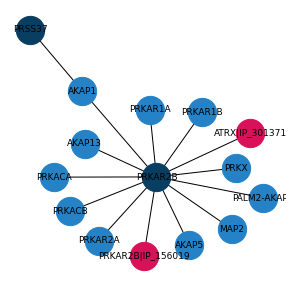

In [136]:
node_size = 800
margin = 0.1
clust_n = 56
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

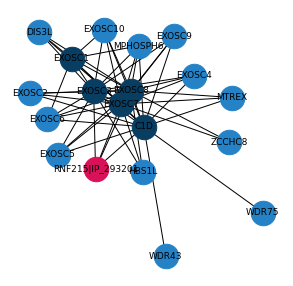

In [154]:
node_size = 600
margin = 0.1
clust_n = 27
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.4, 'iterations':100},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

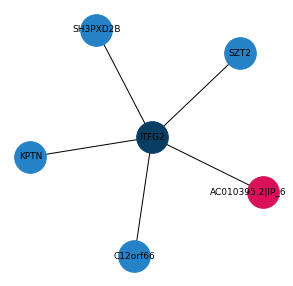

In [139]:
node_size = 1000
margin = 0.1
clust_n = 368
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

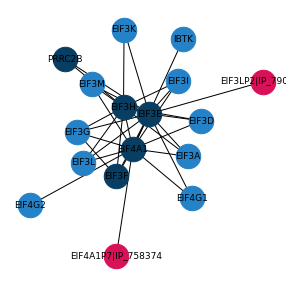

In [144]:
node_size = 600
margin = 0.1
clust_n = 42
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.2, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

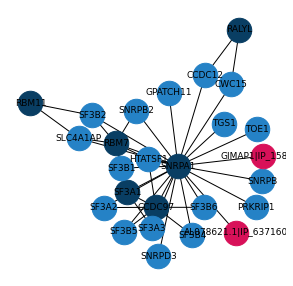

In [141]:
node_size = 600
margin = 0.1
clust_n = 8
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.2, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

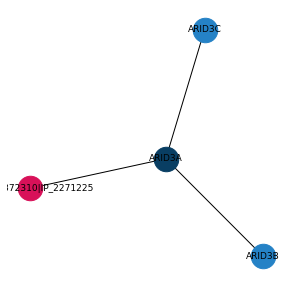

In [142]:
node_size = 600
margin = 0.1
clust_n = 708
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

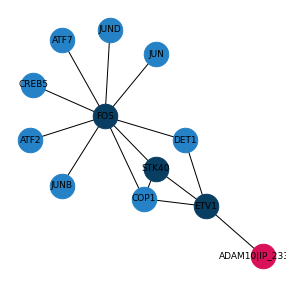

In [159]:
node_size = 600
margin = 0.1
clust_n = 78
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

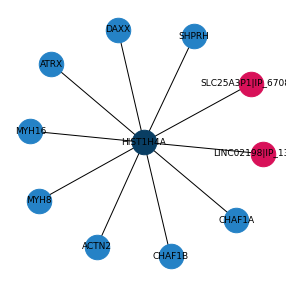

In [160]:
node_size = 600
margin = 0.1
clust_n = 96
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

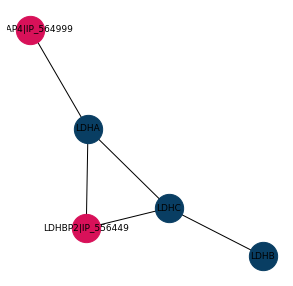

In [158]:
node_size = 800
margin = 0.1
node = 'LDHC'
G_neig = get_2degneigb(G_o, node)
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.35, 'iterations':50},
                file_name='second_neighb_{}_withalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=True,
                margin=margin,
        )